# **TripleH's Project**
#####Dataset : IMDB 5000 Dataset from Kaggle
######Question : If we were directors of a movie, how can we maximise our movie's success rate ? 


In [ ]:
# Sandhiya Sukumaran U2120682B
# Koh Zi En U2122351K
# Yap Shen Hwei U2140630E

In [ ]:
# importing libraries 
import numpy as np
import pandas as pd 
import seaborn as sb 
import matplotlib.pyplot as plt 
import sklearn as sk
sb.set()
sb.reset_orig

<function seaborn.rcmod.reset_orig>

In [ ]:
# to display all the results not just the last (useful when there are multiple graphs involved in a cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# General utility functions & vars






In [ ]:
# Bins to categorise the imdb_score ranges

# Multi bins
imdb_bins = [0, 3, 5, 7, 10]
imdb_labels = ["horrendous", "ok", "good", "very good"]

# Binary bins
# 6.5 = 1-6.5 (Bad) 10 = 6.6-10 (Good)
bins = (2, 6.5, 10)

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] >= low) & (df_in[col_name] <= high)]
    return df_out

# Dataset : IMDB 5000

In [ ]:
# importing the dataset from github 
url = 'https://raw.githubusercontent.com/imaginaryBuddy/tripleH/main/movie_metadata.csv'
imdbData = pd.read_csv(url)
imdbData.head()

color      director_name  num_critic_for_reviews  duration  \
0  Color      James Cameron                   723.0     178.0   
1  Color     Gore Verbinski                   302.0     169.0   
2  Color         Sam Mendes                   602.0     148.0   
3  Color  Christopher Nolan                   813.0     164.0   
4    NaN        Doug Walker                     NaN       NaN   

   director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
0                      0.0                   855.0  Joel David Moore   
1                    563.0                  1000.0     Orlando Bloom   
2                      0.0                   161.0      Rory Kinnear   
3                  22000.0                 23000.0    Christian Bale   
4                    131.0                     NaN        Rob Walker   

   actor_1_facebook_likes      gross                           genres  ...  \
0                  1000.0  7.605e+08  Action|Adventure|Fantasy|Sci-Fi  ...   
1                 40000.0  3.094e+08         Action|Adventure|Fantasy  ...   
2                 11000.0  2.001e+08        Action|Adventure|Thriller  ...   
3                 27000.0  4.481e+08                  Action|Thriller  ...   
4                   131.0        NaN                      Documentary  ...   

  num_user_for_reviews language  country  content_rating     budget  \
0               3054.0  English      USA           PG-13  2.370e+08   
1               1238.0  English      USA           PG-13  3.000e+08   
2                994.0  English       UK           PG-13  2.450e+08   
3               2701.0  English      USA           PG-13  2.500e+08   
4                  NaN      NaN      NaN             NaN        NaN   

   title_year actor_2_facebook_likes imdb_score  aspect_ratio  \
0      2009.0                  936.0        7.9          1.78   
1      2007.0                 5000.0        7.1          2.35   
2      2015.0                  393.0        6.8          2.35   
3      2012.0                23000.0        8.5          2.35   
4         NaN                   12.0        7.1           NaN   

  movie_facebook_likes  
0                33000  
1                    0  
2                85000  
3               164000  
4                    0  

[5 rows x 28 columns]

In [ ]:
imdbData.isnull().sum()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

As the gross has a lot of null values, and the type of gross is inconsistent across each movie, we are dropping the gross variable entirely.

## standardising budget using CPI

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
url = "https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/"

r = requests.get(url)
data = r.text
soup = BeautifulSoup(data, 'html.parser')

table = soup.find('table')
rows = table.tbody.findAll('tr');

years = []
cpis = []

for row in rows:
    year = row.findAll('td')[0].get_text()
    if year.isdigit() and int(year) < 2017:
        years.append(int(year))
        cpis.append(float(row.findAll('td')[13].get_text()))

cpi_table = pd.DataFrame({
    "year": years,
    "avg_annual_cpi": cpis
})

cpi_table.tail()

year  avg_annual_cpi
99   2012         229.594
100  2013         232.957
101  2014         236.736
102  2015         237.017
103  2016         240.007

In [ ]:
def get_real_value(nominal_amt, old_cpi, new_cpi):
    real_value = (nominal_amt * new_cpi) / old_cpi
    return real_value

In [ ]:
# replace na values with 0
imdbData["budget"].fillna(0, inplace = True)
imdbData["title_year"].fillna(0, inplace = True)

# only consider movies made in the USA. Drop all other rows
imdbData = imdbData[imdbData['country'].str.contains('USA') == True]

imdbData.drop(imdbData[(imdbData["budget"] == 0) | (imdbData["title_year"] == 0)].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
CPI_2016 = float(cpi_table[cpi_table['year'] == 2016]['avg_annual_cpi'])

In [ ]:
real_budget_values = []

# must transform gross and budget values into real 2016 dollar terms
for index, row in imdbData.iterrows():
    budget = row['budget']
    year = row['title_year']
    cpi = float(cpi_table[cpi_table['year'] == int(year)]['avg_annual_cpi'])
    
    real_budget = get_real_value(budget, cpi, CPI_2016)
    real_budget_values.append(real_budget)   

# place the converted budget values into the original budget column
imdbData["budget"] = real_budget_values

In [ ]:
# remove duplicates
# keep='first' drops duplicates except for the first occurence
imdbData.drop_duplicates(subset=['movie_title'], keep='first', inplace=True)
imdbData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3411 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      3400 non-null   object 
 1   director_name              3411 non-null   object 
 2   num_critic_for_reviews     3384 non-null   float64
 3   duration                   3408 non-null   float64
 4   director_facebook_likes    3411 non-null   float64
 5   actor_3_facebook_likes     3402 non-null   float64
 6   actor_2_name               3406 non-null   object 
 7   actor_1_facebook_likes     3408 non-null   float64
 8   gross                      2993 non-null   float64
 9   genres                     3411 non-null   object 
 10  actor_1_name               3408 non-null   object 
 11  movie_title                3411 non-null   object 
 12  num_voted_users            3411 non-null   int64  
 13  cast_total_facebook_likes  3411 non-null   int64

## Splitting the dataset

In [ ]:
# split the whole dataset into train and test 
from sklearn.model_selection import train_test_split 

train_data, test_data = train_test_split(imdbData, test_size = 0.2, random_state = 55)

# let's see what we have here in our train and test datasets 
print("Train Dataset : ")
print("Data type : ", type(train_data))
print("Data dims : ", train_data.shape)
print('-------------------------------------------------------')
print("Test Dataset : ")
print("Data type : ", type(test_data))
print("Data dims : ", test_data.shape)


Train Dataset : 
Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (2728, 28)
-------------------------------------------------------
Test Dataset : 
Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (683, 28)


In [ ]:
# rename the train dataset for simplicity 
imdb = train_data.drop_duplicates(subset = "movie_title")

In [ ]:
# from google.colab import drive
# drive.mount('drive', force_remount = True)
# imdb.to_csv('imdbTrain.csv')
# !cp imdbTrain.csv "drive/My Drive/SC1015 Project TripleH/"

In [ ]:
# drive.mount('drive', force_remount = True)
# test_data.to_csv('imdb_test.csv')
# !cp imdb_test.csv "drive/My Drive/SC1015 Project TripleH"

In [ ]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      2719 non-null   object 
 1   director_name              2728 non-null   object 
 2   num_critic_for_reviews     2702 non-null   float64
 3   duration                   2725 non-null   float64
 4   director_facebook_likes    2728 non-null   float64
 5   actor_3_facebook_likes     2719 non-null   float64
 6   actor_2_name               2723 non-null   object 
 7   actor_1_facebook_likes     2725 non-null   float64
 8   gross                      2393 non-null   float64
 9   genres                     2728 non-null   object 
 10  actor_1_name               2725 non-null   object 
 11  movie_title                2728 non-null   object 
 12  num_voted_users            2728 non-null   int64  
 13  cast_total_facebook_likes  2728 non-null   int

In [ ]:
# importing the clean test dataset from github 
url = 'https://raw.githubusercontent.com/imaginaryBuddy/imdbMoviesDSAI/main/imdb_test_clean.csv'
imdb_test_clean = pd.read_csv(url)
imdb_test_clean.head()

Unnamed: 0  Unnamed: 0.1  color    director_name  num_critic_for_reviews  \
0           0         488.0  Color       Tim Burton                   132.0   
1           1         168.0  Color       Jon M. Chu                   351.0   
2           2        1790.0  Color  Martin Scorsese                    85.0   
3           3        2707.0  Color      David Raynr                    50.0   
4           5        1630.0  Color     Luis Mandoki                    85.0   

   duration  director_facebook_likes  actor_3_facebook_likes  \
0     106.0                  13000.0                   733.0   
1     122.0                    209.0                   934.0   
2     134.0                  17000.0                     0.0   
3      94.0                      9.0                   612.0   
4     131.0                     43.0                   362.0   

                 actor_2_name  actor_1_facebook_likes  ...  Animation Music  \
0                Martin Short                 20000.0  ...          0     0   
1              Dwayne Johnson                 17000.0  ...          0     0   
2  Tulku Jamyang Kunga Tenzin                     2.0  ...          0     0   
3            Jodi Lyn O'Keefe                 11000.0  ...          0     0   
4                 John Savage                 18000.0  ...          0     0   

  Sport Musical  History  War Western  Documentary Film-Noir Short  
0     0       0        0    0       0            0         0     0  
1     0       0        0    0       0            0         0     0  
2     0       0        1    1       0            0         0     0  
3     0       0        0    0       0            0         0     0  
4     0       0        0    0       0            0         0     0  

[5 rows x 53 columns]

Let's extract the Variables & perform EDA ! 

#Univariate EDA


## 1. director_name //
   the most frequently appeared names: 
```
Steven Spielberg        22
Woody Allen             18
Clint Eastwood          17
Spike Lee               15
Ridley Scott            15
Martin Scorsese         15
Steven Soderbergh       12
Renny Harlin            12
Robert Zemeckis         12

```

In [ ]:
director_name = pd.DataFrame(imdb[["director_name", "imdb_score"]]).copy()
director_name[["director_name"]].describe()

director_name
count               2728
unique              1477
top     Steven Spielberg
freq                  17

In [ ]:
director_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   director_name  2728 non-null   object 
 1   imdb_score     2728 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.9+ KB


In [ ]:
director_name["director_name"].isnull().value_counts()

False    2728
Name: director_name, dtype: int64

In [ ]:
# only drop the null values of director_name, because we are doing univariate EDA now

In [ ]:
director_name.dropna(subset = ["director_name"], axis = 0,inplace = True)
director_name.isnull().value_counts()

director_name  imdb_score
False          False         2728
dtype: int64

In [ ]:
director_name["director_name"].value_counts().head(20)

Steven Spielberg        17
Woody Allen             16
Martin Scorsese         16
Clint Eastwood          15
Spike Lee               12
Tim Burton              12
Robert Zemeckis         12
Renny Harlin            11
Francis Ford Coppola    10
Kevin Smith             10
Michael Bay             10
Barry Levinson          10
Robert Rodriguez        10
Steven Soderbergh       10
Ridley Scott             9
Brian De Palma           9
Tony Scott               9
Sam Raimi                9
Lasse Hallström          8
Ron Howard               8
Name: director_name, dtype: int64

## 2. num_critic_for_reviews //



a large proportion of movies receive only a few (close to 0) critic reviews 

In [ ]:
num_critic = pd.DataFrame(imdb[["movie_title", "num_critic_for_reviews"]]).copy().dropna(how = "any", axis = 0)
num_critic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702 entries, 4757 to 549
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   movie_title             2702 non-null   object 
 1   num_critic_for_reviews  2702 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.3+ KB


In [ ]:
num_critic.describe()

num_critic_for_reviews
count                2702.000
mean                  146.564
std                   121.934
min                     1.000
25%                    56.000
50%                   118.000
75%                   202.000
max                   813.000

In [ ]:
num_critic.sort_values("num_critic_for_reviews", ascending = False)

movie_title  num_critic_for_reviews
3            The Dark Knight Rises                    813.0
296               Django Unchained                    765.0
15                    Man of Steel                    733.0
0                           Avatar                    723.0
96                    Interstellar                    712.0
...                             ...                     ...
4630                   A Fine Step                      1.0
4702  The Hadza: Last of the First                      1.0
4777      The Little Ponderosa Zoo                      1.0
5017                     Dry Spell                      1.0
4623        Doc Holliday's Revenge                      1.0

[2702 rows x 2 columns]

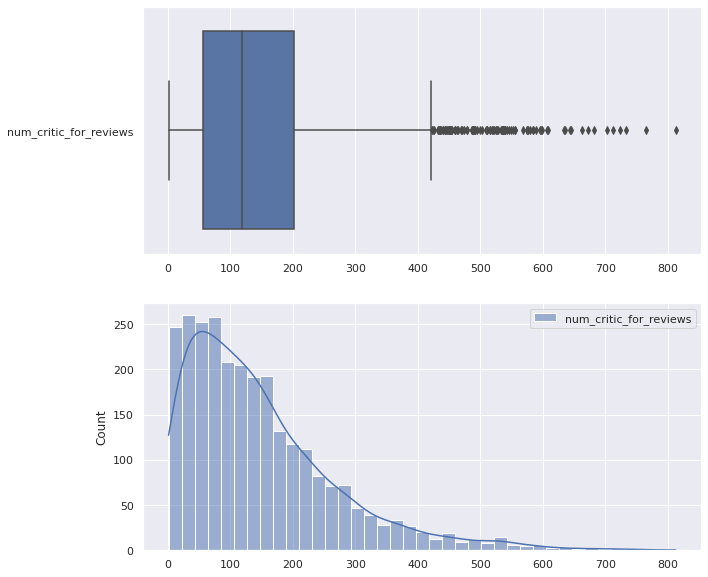

In [ ]:
f , axes = plt.subplots (2,1, figsize = (10,10))
sb.boxplot(data = num_critic, orient = "h", ax = axes[0])
sb.histplot(data = num_critic, kde = True, ax = axes[1])

In [ ]:
num_critic_clean = remove_outlier(num_critic, "num_critic_for_reviews")

In [ ]:
f , axes = plt.subplots (2,1, figsize = (10,10))
sb.boxplot(data = num_critic_clean, orient = "h", ax = axes[0])
sb.histplot(data = num_critic_clean, kde = True, ax = axes[1])

## 3. duration //
50% of all movies lie around 95 ~ 117 minutes

In [ ]:
duration = pd.DataFrame(imdb["duration"]).copy().dropna(how = "any", axis = 0)
duration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2725 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  2725 non-null   float64
dtypes: float64(1)
memory usage: 42.6 KB


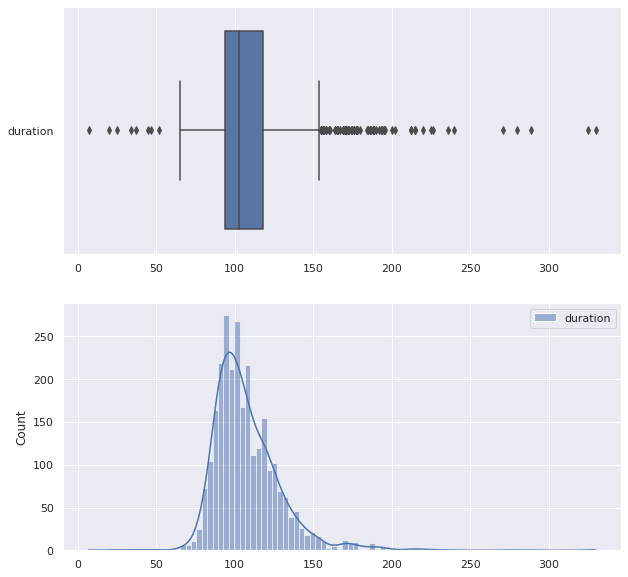

In [ ]:
f , axes = plt.subplots (2,1, figsize = (10,10))
sb.boxplot(data = duration, orient = "h", ax = axes[0])
sb.histplot(data = duration, kde = True, ax = axes[1])

In [ ]:
# removing outliers from the duration data 
q1 = duration.quantile(0.25)
q3 = duration.quantile(0.75)
IQR = q3-q1
lower = q1 - 1.5 * IQR 
upper = q3 + 1.5 * IQR
duration_clean= duration[~((duration < (q1 - 1.5 * IQR)) |(duration > (q3 + 1.5 * IQR))).any(axis=1)]
duration_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2629 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  2629 non-null   float64
dtypes: float64(1)
memory usage: 41.1 KB


In [ ]:
duration_clean.describe()

duration
count  2629.000
mean    105.589
std      16.458
min      65.000
25%      93.000
50%     103.000
75%     116.000
max     154.000

In [ ]:
f , axes = plt.subplots (2,1, figsize = (10,10))
sb.boxplot(data = duration_clean, orient = "h", ax = axes[0])
sb.histplot(data = duration_clean, kde = True, ax = axes[1])

## 4. director_facebook_likes //

like duration, data is very skewed to the left, this could be due to the fact that most directors dont get recognition that much. 

perhaps, we would have to extract a portion of the data for to analyse in the future 

In [ ]:
director_likes = pd.DataFrame(imdb["director_facebook_likes"]).copy().dropna(axis = 0, how = "any")
director_likes.info()
len1 = len(imdb)
len2 = len(director_likes)
print("# of NaN: ", len1-len2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   director_facebook_likes  2728 non-null   float64
dtypes: float64(1)
memory usage: 42.6 KB
# of NaN:  0


In [ ]:
f , axes = plt.subplots (2,1, figsize = (10,10))
sb.boxplot(data = director_likes, orient = "h", ax = axes[0])
sb.kdeplot(data = director_likes, ax = axes[1])

In [ ]:
director_likes_clean = remove_outlier(director_likes, "director_facebook_likes")
f , axes = plt.subplots (2,1, figsize = (10,10))
sb.boxplot(data = director_likes_clean, orient = "h", ax = axes[0])
sb.kdeplot(data = director_likes_clean, ax = axes[1])

In [ ]:
# using log transform to visualise data better 
dir_likes_log = np.log(director_likes)
sb.kdeplot(data = dir_likes_log)


this could mean that there are different behaviours between different proportions of the data. This is not unexpected as success is itself a measure of outliers

## 4. most frequently acted actor/ actress //
concatenate data from actor_1_name, actor_2_name, actor_3_name

In [ ]:
actor_name_combined = imdb[["actor_1_name","actor_2_name", "actor_3_name"]].copy()
actor_name_combined = actor_name_combined.stack().reset_index()[["level_1", 0]].rename(columns = {0: "actor_name"}).drop(axis = 1, columns = "level_1")

In [ ]:
display(actor_name_combined)

actor_name
0           Jim Gaffigan
1               Ann Dowd
2         Matthew Cowles
3     Sylvester Stallone
4         Kurtwood Smith
...                  ...
8162        William Hurt
8163      Kevin Corrigan
8164        Adam Sandler
8165            Paz Vega
8166        Sarah Steele

[8167 rows x 1 columns]

In [ ]:
actor_name_combined.describe()

actor_name
count             8167
unique            3755
top     Robert De Niro
freq                36

In [ ]:
display(pd.DataFrame(actor_name_combined.value_counts(ascending = False).head(n=20)))

0
actor_name             
Robert De Niro       36
Bruce Willis         30
Morgan Freeman       29
Steve Buscemi        26
Johnny Depp          26
Will Ferrell         26
Bill Murray          24
Denzel Washington    23
Nicolas Cage         22
J.K. Simmons         21
Matthew McConaughey  21
Harrison Ford        21
Robert Downey Jr.    21
James Franco         20
Brad Pitt            20
Matt Damon           20
Sylvester Stallone   19
Meryl Streep         19
Robin Williams       19
Julia Roberts        19

In [ ]:
# note to self (SH) to insert the pictures of the actors/ actresses!

## 5. genres //
most common genre : Drama 
we asked ourselves, why? is it because it is the most profitable?

```
1. The most common genre seems to be Drama, 
hypothesis: assuming that the movies industry follows demand and supply, there is high demand for Dramas, 
so this genre will be the most popular with the highest ratings amngs the other genres
```



In [ ]:
genres = pd.DataFrame(imdb["genres"]).copy()
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genres  2728 non-null   object
dtypes: object(1)
memory usage: 107.2+ KB


In [ ]:
genres.head()

genres
4757                         Comedy
819   Action|Adventure|Thriller|War
4268                          Drama
3872               Action|Adventure
3537  Comedy|Fantasy|Horror|Mystery

In [ ]:
# get the genre frequencies 
from collections import Counter
genreDi = Counter()

for strGenre in imdb["genres"] :
  wds = strGenre.split("|")
  for w in wds :
    if w in genreDi:
      genreDi[w] = genreDi[w] + 1
    else:
      genreDi[w] = 1 

print(genreDi)

Counter({'Drama': 1302, 'Comedy': 1113, 'Thriller': 772, 'Action': 647, 'Romance': 613, 'Adventure': 517, 'Crime': 491, 'Sci-Fi': 356, 'Fantasy': 345, 'Family': 315, 'Horror': 305, 'Mystery': 261, 'Animation': 134, 'Biography': 133, 'Music': 127, 'Sport': 98, 'War': 88, 'Musical': 82, 'History': 74, 'Documentary': 55, 'Western': 51, 'Film-Noir': 5, 'Short': 2, 'News': 1})


In [ ]:
# convert the dictionary into pandasdataframes + sort in descending order 

genreFreq = pd.DataFrame.from_records(genreDi.most_common(), columns = ["Genre", "Count"])

genreFreq.head(n=10)

Genre  Count
0      Drama   1302
1     Comedy   1113
2   Thriller    772
3     Action    647
4    Romance    613
5  Adventure    517
6      Crime    491
7     Sci-Fi    356
8    Fantasy    345
9     Family    315

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

<Figure size 7200x3600 with 0 Axes>

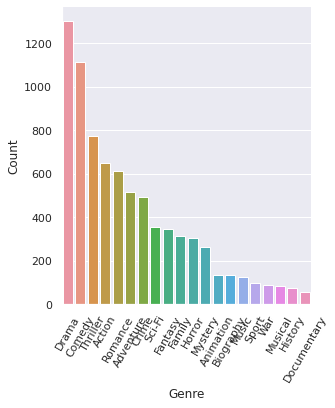

In [ ]:
f = plt.figure(figsize = (100,50))
sb.catplot(data = genreFreq[:20], y = "Count", x = "Genre", kind = "bar")
plt.xticks(rotation=60)

## gross

In [ ]:
gross = pd.DataFrame(imdb["gross"]).copy()
gross.head()

gross
4757  1.206e+04
819   5.372e+07
4268  4.600e+06
3872  8.691e+03
3537        NaN

In [ ]:
print ("Data type : ", type(gross))
print ("Data dims : ", gross.size)
print()
gross.info()

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  2728

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gross   2393 non-null   float64
dtypes: float64(1)
memory usage: 107.2 KB


In [ ]:
gross_clean = gross.copy()
gross_clean.dropna(axis = 0, inplace = True)
gross_clean.head()

gross
4757  1.206e+04
819   5.372e+07
4268  4.600e+06
3872  8.691e+03
1419  6.005e+07

In [ ]:
f , axes = plt.subplots(figsize = (24,4))
sb.boxplot(data = gross_clean, orient = 'h')

In [ ]:
# describe 
gross_clean.describe()

gross
count  2.393e+03
mean   5.632e+07
std    7.337e+07
min    7.030e+02
25%    1.030e+07
50%    3.289e+07
75%    7.300e+07
max    7.605e+08

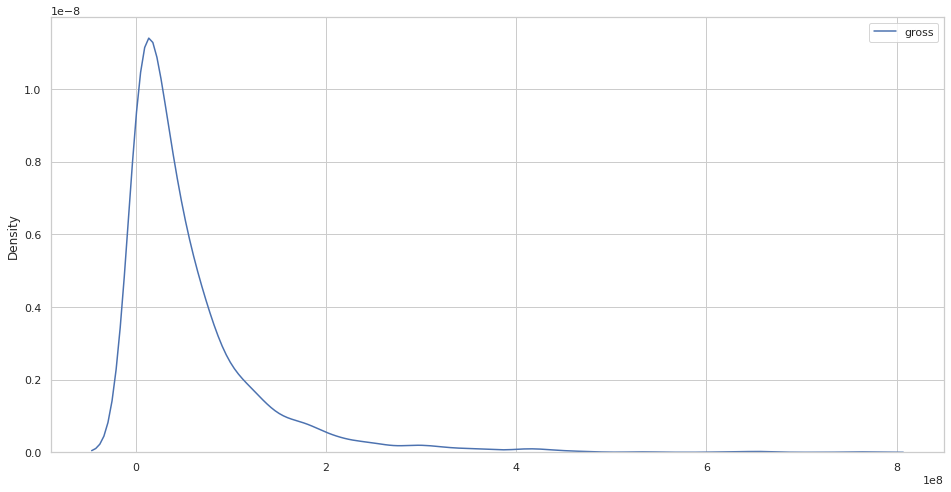

In [ ]:
f = plt.figure(figsize=(16,8))
sb.set_style("whitegrid")
sb.kdeplot(data = gross_clean)
# need to think of a way to create more grid lines 

In [ ]:
# looks positively skewed, and a lot of outliers, but we are not going to remove them, 
# because these outliers may be telling us the secret to become successful
print ("skewness : ", gross_clean.skew())

skewness :  gross    3.06
dtype: float64


##num_voted_users // 
-->Number of people who voted for the movie

In [ ]:
numVoted= pd.DataFrame(imdb["num_voted_users"]).copy()
numVoted.head()

num_voted_users
4757              739
819             92106
4268            68222
3872             4952
3537             8589

In [ ]:
print ("Data type : ", type(numVoted))
print ("Data dims : ", numVoted.size)
print()
numVoted.info()

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  2728

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   num_voted_users  2728 non-null   int64
dtypes: int64(1)
memory usage: 107.2 KB


In [ ]:
numVoted.describe()

num_voted_users
count        2.728e+03
mean         9.605e+04
std          1.556e+05
min          5.000e+00
25%          1.166e+04
50%          4.266e+04
75%          1.104e+05
max          1.690e+06

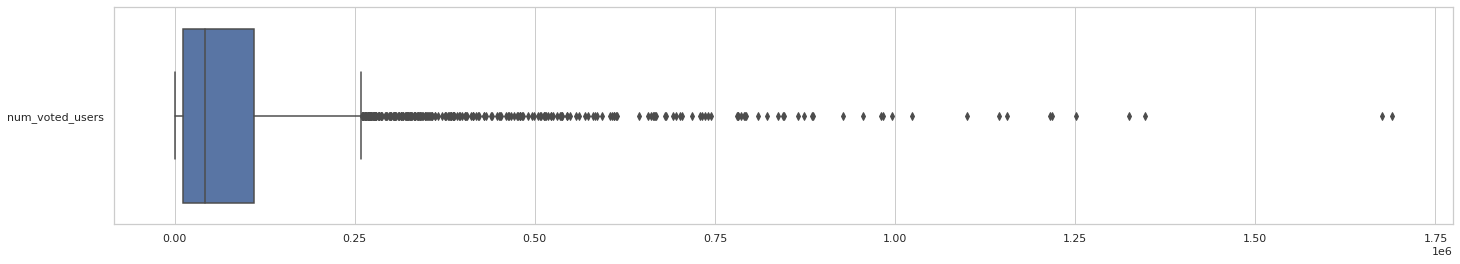

In [ ]:
f , axes = plt.subplots(figsize = (24,4))
sb.boxplot(data = numVoted, orient = 'h')
#many outliers

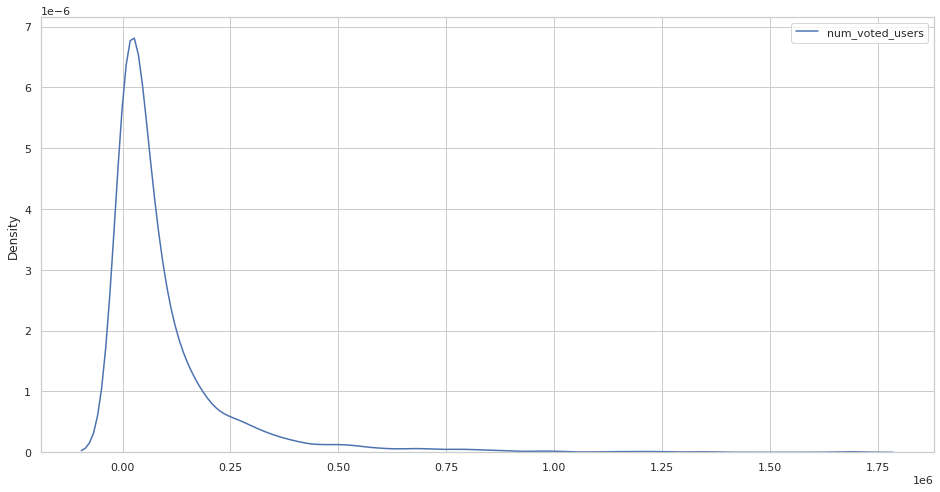

In [ ]:
f = plt.figure(figsize=(16, 8))
sb.kdeplot(data = numVoted)

In [ ]:
print ("skewness : ", numVoted.skew())

skewness :  num_voted_users    3.879
dtype: float64


In [ ]:
#lets try to remove the outliers
Q1=(numVoted["num_voted_users"]).quantile(0.25)  #
Q3=(numVoted['num_voted_users']).quantile(0.75)
IQR=Q3-Q1



lowlimit=(Q1 - 1.5 * IQR)
uplimit= (Q3 + 1.5 * IQR)

print("Number of outliers is: ", len(numVoted[(numVoted['num_voted_users']>uplimit) | (numVoted[ 'num_voted_users']<lowlimit)]))
numVotedclean= numVoted.loc[(numVoted['num_voted_users']<uplimit) & (numVoted['num_voted_users']>lowlimit)]

Number of outliers is:  259


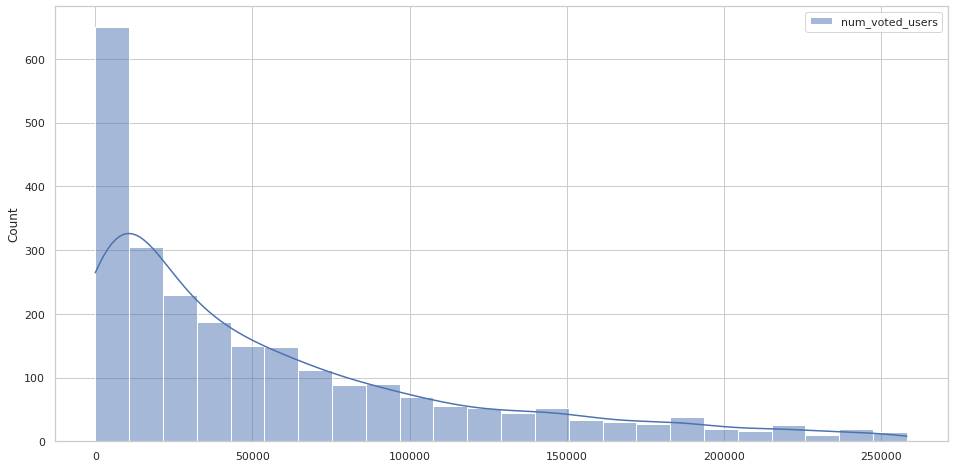

In [ ]:
f = plt.figure(figsize=(16, 8))
sb.histplot(data = numVotedclean,kde= True )

In [ ]:
print ("skewness after remove: ", numVotedclean.skew())

skewness after remove:  num_voted_users    1.344
dtype: float64


## total cast likes // to cluster + include



In [ ]:
castLikes= pd.DataFrame(imdb["cast_total_facebook_likes"]).copy()
castLikes.describe()

cast_total_facebook_likes
count                   2728.000
mean                   11122.055
std                    20049.050
min                        0.000
25%                     1862.000
50%                     3784.500
75%                    15369.500
max                   656730.000

In [ ]:
print ("Data type : ", type(castLikes))
print ("Data dims : ", castLikes.size)
print()
castLikes.info()

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  2728

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   cast_total_facebook_likes  2728 non-null   int64
dtypes: int64(1)
memory usage: 107.2 KB


In [ ]:
castLikes.describe()

cast_total_facebook_likes
count                   2728.000
mean                   11122.055
std                    20049.050
min                        0.000
25%                     1862.000
50%                     3784.500
75%                    15369.500
max                   656730.000

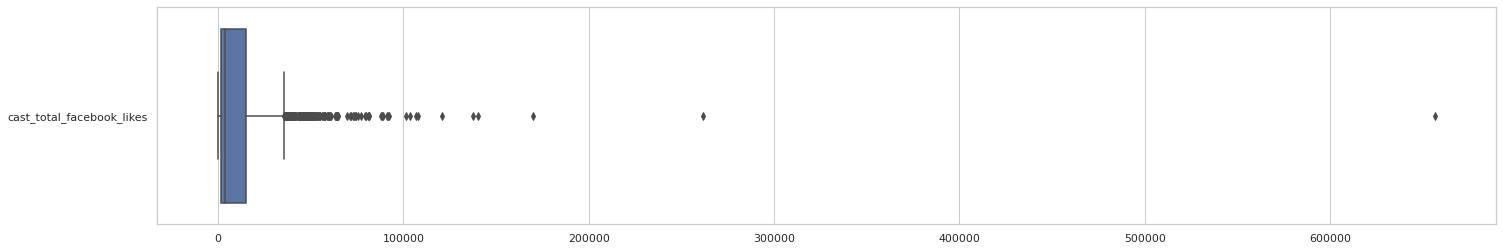

In [ ]:
f , axes = plt.subplots(figsize = (24,4))
sb.boxplot(data = castLikes, orient = 'h')
#many outliers

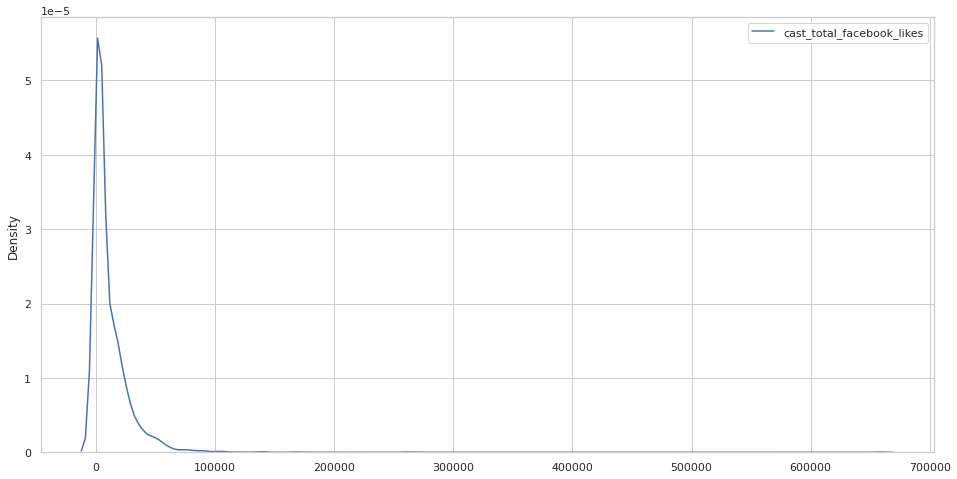

In [ ]:
f = plt.figure(figsize=(16,8))
sb.set_style("whitegrid")
sb.kdeplot(data = castLikes)

In [ ]:
print ("skewness : ", castLikes.skew())

skewness :  cast_total_facebook_likes    14.224
dtype: float64


In [ ]:
# removing outliers
Q1=(castLikes["cast_total_facebook_likes"]).quantile(0.25)  #
Q3=(castLikes['cast_total_facebook_likes']).quantile(0.75)
IQR=Q3-Q1



lowlimit=(Q1 - 1.5 * IQR)
uplimit= (Q3 + 1.5 * IQR)

print("Number of outliers is: ", len(castLikes[(castLikes['cast_total_facebook_likes']>uplimit) | (castLikes['cast_total_facebook_likes']<lowlimit)]))
castLikesclean= castLikes.loc[(castLikes['cast_total_facebook_likes']<uplimit) & (castLikes['cast_total_facebook_likes']>lowlimit)]

Number of outliers is:  179


In [ ]:
print ("skewness after remove outliers: ", castLikesclean.skew())

skewness after remove outliers:  cast_total_facebook_likes    1.317
dtype: float64


## Plot keywords

In [ ]:
keywords= pd.DataFrame(imdb['plot_keywords']).copy()
keywords.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   plot_keywords  2667 non-null   object
dtypes: object(1)
memory usage: 107.2+ KB


In [ ]:
keywordsclean=keywords.dropna()
keywordsclean.head()

plot_keywords
4757                                artist|black comedy
819             afghanistan|colonel|rambo|rescue|soviet
4268  13 year olds|adolescence|friend|peer pressure|...
3537  ghost|hotel|murder|stake|what happened to epil...
3578  crematorium|female frontal nudity|naked dead w...

In [ ]:
from collections import Counter
plotkeys = Counter()

for ind, strKey in keywordsclean.iterrows() :
  wds = strKey["plot_keywords"].split("|")
  for w in wds :
    if w in plotkeys:
      plotkeys[w] = plotkeys[w] + 1
    else:
      plotkeys[w] = 1

plotkeysdf = pd.DataFrame.from_dict(plotkeys, orient = "index").reset_index()\
          .rename(columns = {"index": "key", 0 :"count"})
plotkeysdf.head()

key  count
0        artist      9
1  black comedy      9
2   afghanistan      5
3       colonel      7
4         rambo      2

In [ ]:
display(plotkeysdf.sort_values("count", ascending = False).head(n=20))

key  count
237           love    102
9           friend     97
14          murder     95
143          death     73
354         police     63
41     high school     62
64   new york city     60
22           alien     54
290            fbi     50
363         school     42
242            boy     41
225            dog     39
77           drugs     38
447        revenge     37
514       marriage     36
272     friendship     35
583      detective     34
154         prison     33
545          party     33
339         island     32

In [ ]:
plotkeys = Counter()

i = 0
for strKey in imdb["plot_keywords"] :
  wds = str(strKey).split("|")
  for w in wds :
    if i < 10:
      print(w)
    if w in plotkeys:
      plotkeys[w] = plotkeys[w] + 1
    else:
      plotkeys[w] = 1
  i+=1

artist
black comedy
afghanistan
colonel
rambo
rescue
soviet
13 year olds
adolescence
friend
peer pressure
teacher
nan
ghost
hotel
murder
stake
what happened to epilogue
crematorium
female frontal nudity
naked dead woman
paramedic
poison gas
alien
interspecies sex
scientist
sexual attraction
train
friend
obscenity
scam
vacant lot
van
bear
breasts
female nudity
grizzly
wilderness
older man younger man relationship
punching bag
school teacher
undressing
unrequited love


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from PIL import Image
import matplotlib.pyplot as plt

<Figure size 1440x576 with 0 Axes>

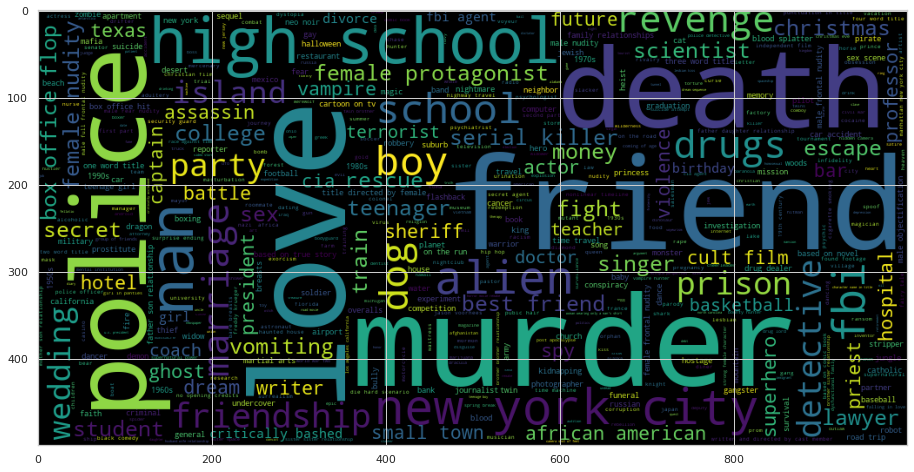

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500,max_words=500, max_font_size= 150).generate_from_frequencies(plotkeys)
 
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)

##facenumber_in_poster
->Number of the actor who featured in the movie poster

In [ ]:
faceNum= pd.DataFrame(imdb["facenumber_in_poster"]).copy()
faceNum.head()

facenumber_in_poster
4757                   2.0
819                    1.0
4268                   2.0
3872                   1.0
3537                   0.0

In [ ]:
print ("Data type : ", type(faceNum))
print ("Data dims : ", faceNum.size)
print()
faceNum.info()

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  2728

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   facenumber_in_poster  2718 non-null   float64
dtypes: float64(1)
memory usage: 107.2 KB


In [ ]:
# drop the NaN rows
faceNumclean=faceNum.dropna()

In [ ]:
faceNumclean.describe()

facenumber_in_poster
count              2718.000
mean                  1.426
std                   2.179
min                   0.000
25%                   0.000
50%                   1.000
75%                   2.000
max                  43.000

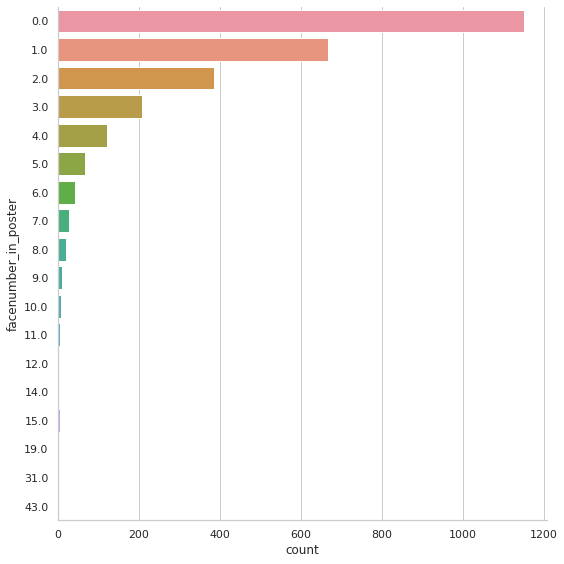

In [ ]:
sb.catplot(y = "facenumber_in_poster", data = faceNumclean, kind = "count", height = 8)
#most posters dont have actors face

## language (x)

In [ ]:
language = pd.DataFrame(imdb['language']).copy()
language.describe()

language
count      2720
unique        9
top     English
freq       2707

<Figure size 2304x1152 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


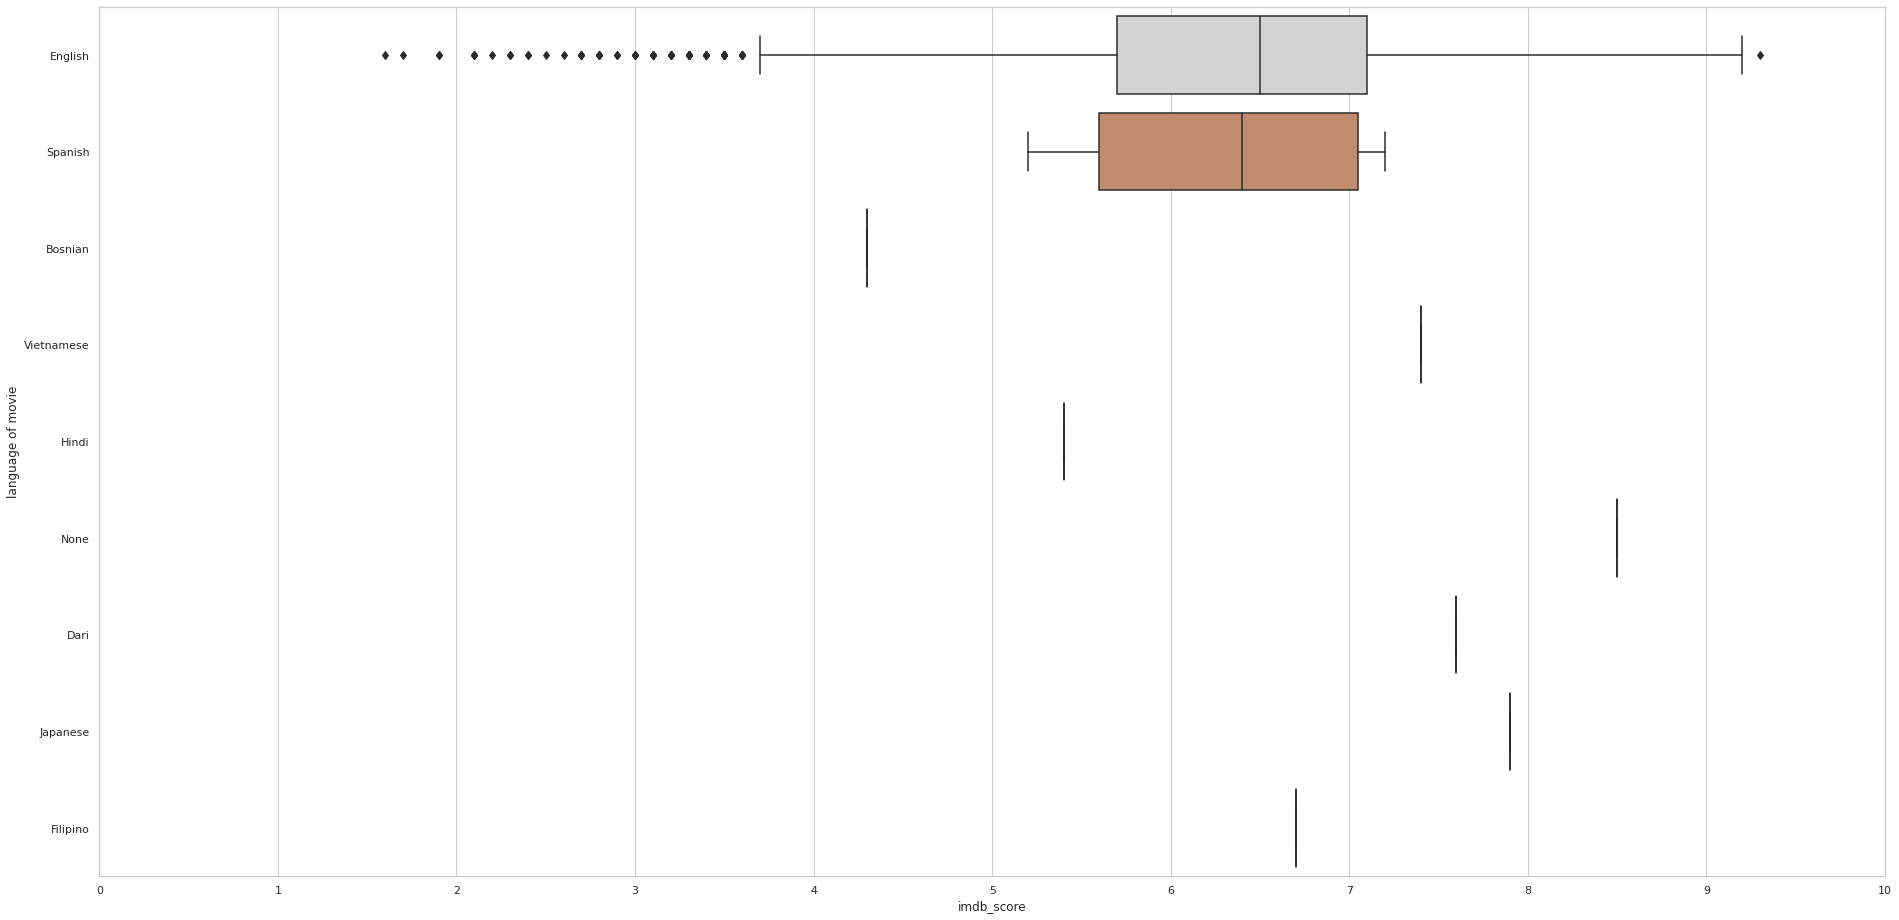

In [ ]:
plt.figure(figsize=(32,16))
p = sb.boxplot("imdb_score", "language", data = imdb, saturation = .6, fliersize = 6., palette = ["lightgray", sb.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "imdb_score", ylabel = "language of movie", xticks = range(11))

# Note: some of the languages do not have a boxplot as there is only 1 movie in the dataset from that language.

We will not be using language as a predictor of success because the dataset for language is highly imbalanced, with english dominating 3761 out of 4034 movies.



## content rating

In [ ]:
content_rating = pd.DataFrame(imdb['content_rating']).copy()
content_rating.describe()

content_rating
count            2636
unique             15
top                 R
freq             1161

In [ ]:
content_imdb = pd.DataFrame(imdb[["content_rating", "imdb_score"]]).copy()
meds = content_imdb.median()
meds.sort_values(ascending=False, inplace=True)
content_imdb = content_imdb[meds.index]


content_imdb.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


imdb_score
4757         6.5
819          5.7
4268         6.8
3872         5.8
3537         4.8

<Figure size 1152x576 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


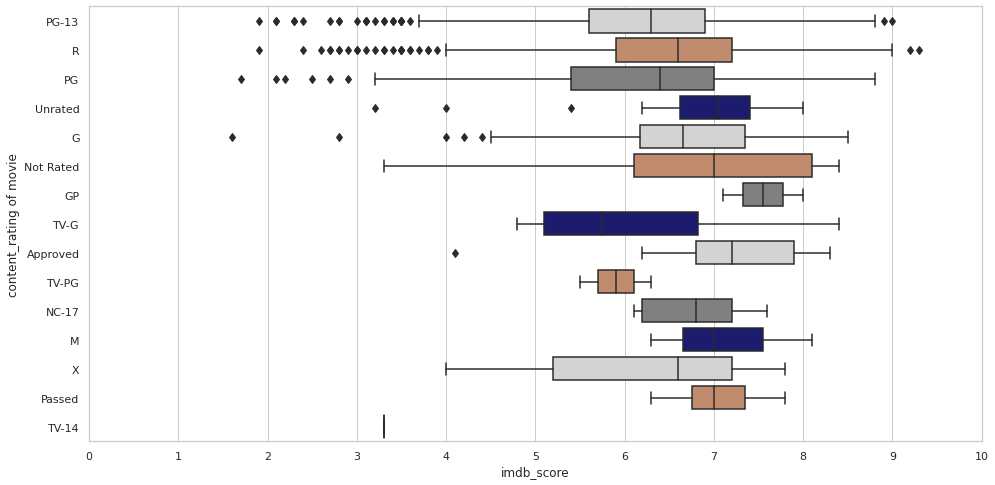

In [ ]:
plt.figure(figsize=(16,8))
p = sb.boxplot("imdb_score", "content_rating", data = imdb, saturation = .6, fliersize = 6., palette = ["lightgray", sb.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "imdb_score", ylabel = "content_rating of movie", xticks = range(11))

# Note: some of the content rating do not have a boxplot as there is only 1 movie in the dataset from that content rating.

## title year

In [ ]:
title_year = pd.DataFrame(imdb['title_year']).copy()
title_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title_year  2728 non-null   float64
dtypes: float64(1)
memory usage: 107.2 KB


<Figure size 4608x1152 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


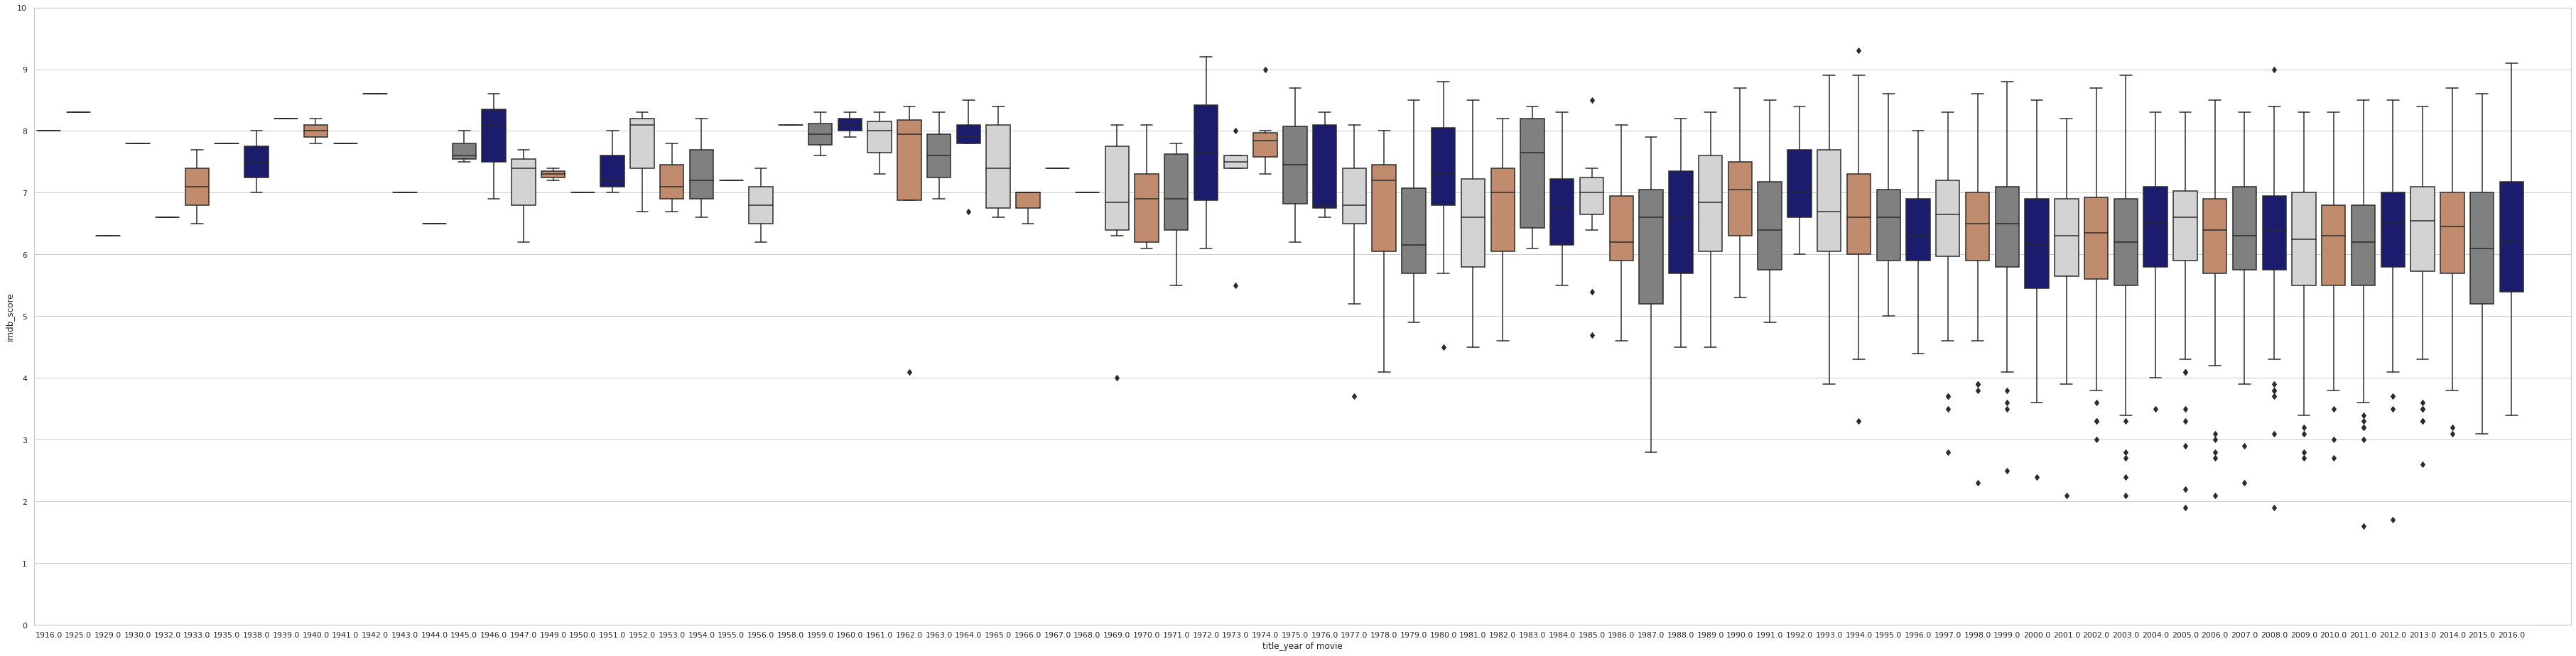

In [ ]:
plt.figure(figsize=(64,16))
p = sb.boxplot("title_year", "imdb_score", data = imdb, saturation = .6, fliersize = 6., palette = ["lightgray", sb.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "title_year of movie", ylabel = "imdb_score", xticks = range(86), yticks = range(11))

# Note: some of the year do not have a boxplot as there is only 1 movie in the dataset from that year.

Observation: seems like the older movies from 1920 to 1967 are more consistent in getting high imdb scores.

```
just an observation, but we won't use it in machine learning.

reason for this observation: 
recall that film noir is the genre that has the highest imdb_score.. 

film noir is popular in the 1940s-1950s



skewness :  title_year   -0.737
dtype: float64


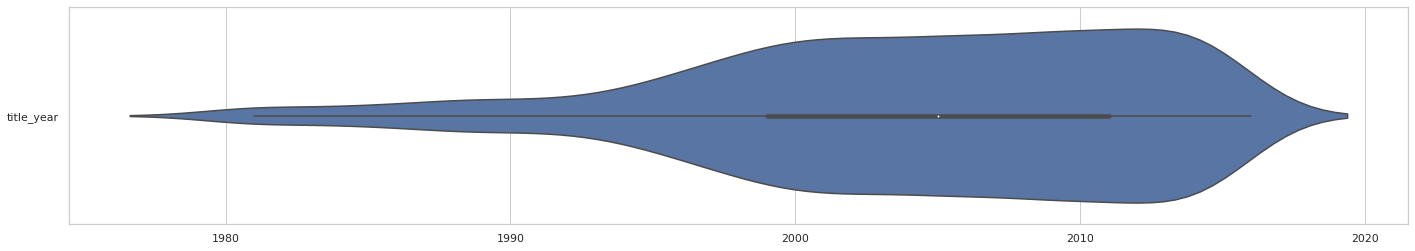

In [ ]:
# removing zero values
year = title_year.copy()
year.dropna(axis = 0, inplace = True)

# removing outliers
year_clean = remove_outlier(year, "title_year")

# box plot
f , axes = plt.subplots(figsize = (24,4))
sb.boxplot(data = year_clean, orient = 'h')

# violin plot
f , axes = plt.subplots(figsize = (24,4))
sb.violinplot(data = year_clean, orient = 'h')

# checking skewness
print ("skewness : ", year_clean.skew())

## budget

We are only keeping the american movies for budget as we realise that the budget for other movies are recorded in euros or nok etc. ie. it is not standardised, and since most of the movies are from usa, we are thus keeping the american movies for a standardised budget.

In [ ]:
budget = pd.DataFrame(imdb['budget']).copy()
budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   budget  2728 non-null   float64
dtypes: float64(1)
memory usage: 107.2 KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2566 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   budget  2566 non-null   float64
dtypes: float64(1)
memory usage: 40.1 KB



skewness :  budget    1.108
dtype: float64


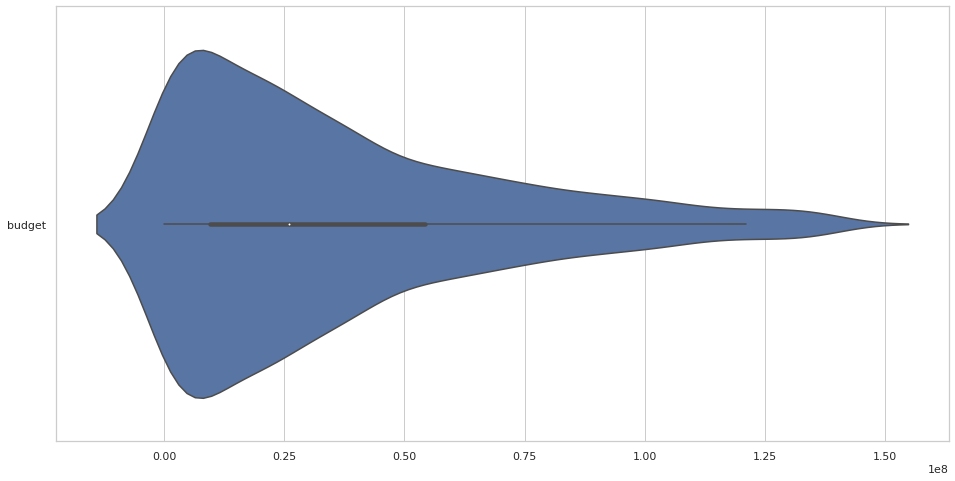

In [ ]:
# removing zero values
budget_clean = budget.copy()
budget_clean.dropna(axis = 0, inplace = True)

# removing outliers
budget_filtered = remove_outlier(budget_clean, "budget")
budget_filtered.info()
print()

# box plot
f , axes = plt.subplots(figsize = (24,4))
sb.boxplot(data = budget_filtered, orient = 'h')

# violin plot
f = plt.figure(figsize=(16, 8))
sb.violinplot(data = budget_filtered, orient = "h")

# check skewness
print ("skewness : ", budget_filtered.skew())

## imdb_score
```
score           counts
[1.6, 3.18)        45
[3.18, 4.76)      257
[4.76, 6.34)     1363
[6.34, 7.92)     2005
[7.92, 9.508)     263
```

In [ ]:
imdb_score = pd.DataFrame(imdb['imdb_score']).copy()
imdb_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   imdb_score  2728 non-null   float64
dtypes: float64(1)
memory usage: 107.2 KB


In [ ]:
imdb_score.describe()

imdb_score
count    2728.000
mean        6.351
std         1.125
min         1.600
25%         5.700
50%         6.500
75%         7.100
max         9.300

skewness :  imdb_score   -0.243
dtype: float64


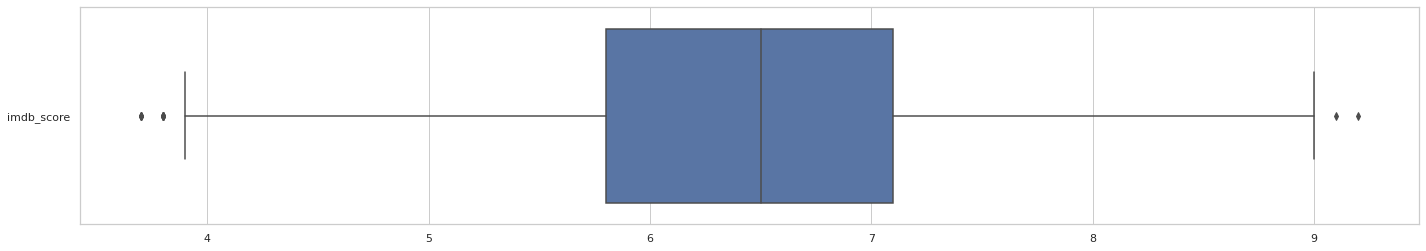

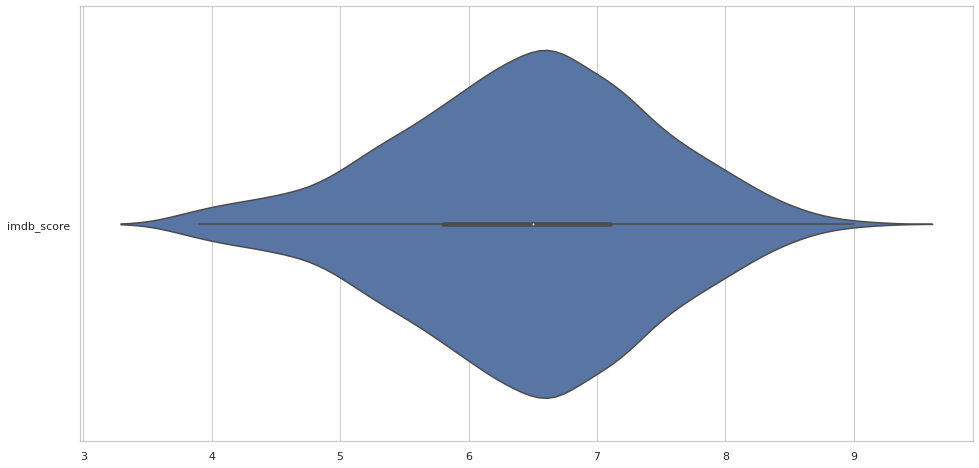

In [ ]:
# no zero/missing values

# removing outliers
imdb_score_clean = remove_outlier(imdb_score, "imdb_score")

# box plot
f , axes = plt.subplots(figsize = (24,4))
sb.boxplot(data = imdb_score_clean, orient = 'h')

# violin plot
f = plt.figure(figsize=(16, 8))
sb.violinplot(data = imdb_score_clean, orient = "h")

# check skewness
print ("skewness : ", imdb_score_clean.skew())

[Text(0, 0, 'horrendous'),
 Text(0, 0, 'ok'),
 Text(0, 0, 'good'),
 Text(0, 0, 'very good')]

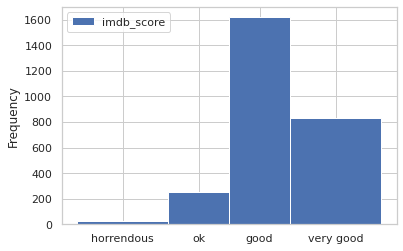

In [ ]:
h = imdb_score.plot.hist(by = "imdb_score", bins = imdb_bins)
h.set_xticks([1.5, 4, 6, 8.5])
h.set_xticklabels(imdb_labels)

In [ ]:
imdb_bin = imdb_score["imdb_score"].copy().to_numpy()
imdb_bin_counts = pd.cut(x = imdb_bin, bins = 5, right = False).value_counts()
display(imdb_bin_counts)

[1.6, 3.14)        34
[3.14, 4.68)      174
[4.68, 6.22)      930
[6.22, 7.76)     1347
[7.76, 9.308)     243
dtype: int64

large proportion of movies with ratings [6.24, 7.92)

## movie fb likes



```
can consider splitting them 
into categories to see whether 
there is any rs 
```



In [ ]:
movie_likes = pd.DataFrame(imdb['movie_facebook_likes']).copy()
movie_likes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   movie_facebook_likes  2728 non-null   int64
dtypes: int64(1)
memory usage: 107.2 KB


In [ ]:
movie_likes.describe()

movie_facebook_likes
count              2728.000
mean               7944.398
std               20144.752
min                   0.000
25%                   0.000
50%                 195.500
75%                5000.000
max              349000.000

skewness :  movie_facebook_likes    3.36
dtype: float64


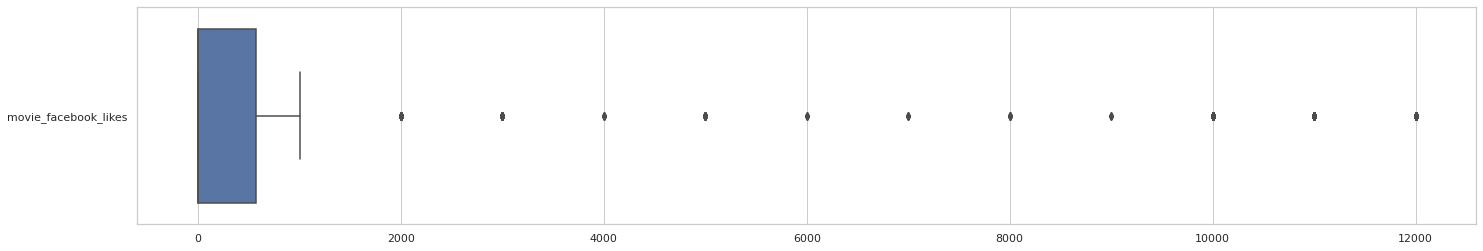

In [ ]:
# removing zero values
movie = movie_likes.copy()
movie.dropna(axis = 0, inplace = True)

# removing outliers
movie_clean = remove_outlier(movie, "movie_facebook_likes")

# box plot
f , axes = plt.subplots(figsize = (24,4))
sb.boxplot(data = movie_clean, orient = 'h')

# violin plot
f = plt.figure(figsize=(16, 8))
sb.violinplot(data = movie_clean, orient = "h")

# check skewness
print ("skewness : ", movie_clean.skew())

# Bivariate EDA (imdb_score)
`imdb_score` as response

## duration vs imdb_score 

In [ ]:
imdb_dur_score = imdb[["duration", "imdb_score"]].copy()
imdb_dur_score.describe()
print()
imdb_dur_score.info()

duration  imdb_score
count  2725.000    2728.000
mean    107.999       6.351
std      22.840       1.125
min       7.000       1.600
25%      94.000       5.700
50%     103.000       6.500
75%     118.000       7.100
max     330.000       9.300


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   duration    2725 non-null   float64
 1   imdb_score  2728 non-null   float64
dtypes: float64(2)
memory usage: 128.5 KB


In [ ]:
imdb_dur_score.dropna(inplace = True, axis = 0, how = "any")
imdb_dur_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2725 entries, 4757 to 549
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   duration    2725 non-null   float64
 1   imdb_score  2725 non-null   float64
dtypes: float64(2)
memory usage: 63.9 KB


duration  imdb_score
duration       1.000       0.367
imdb_score     0.367       1.000

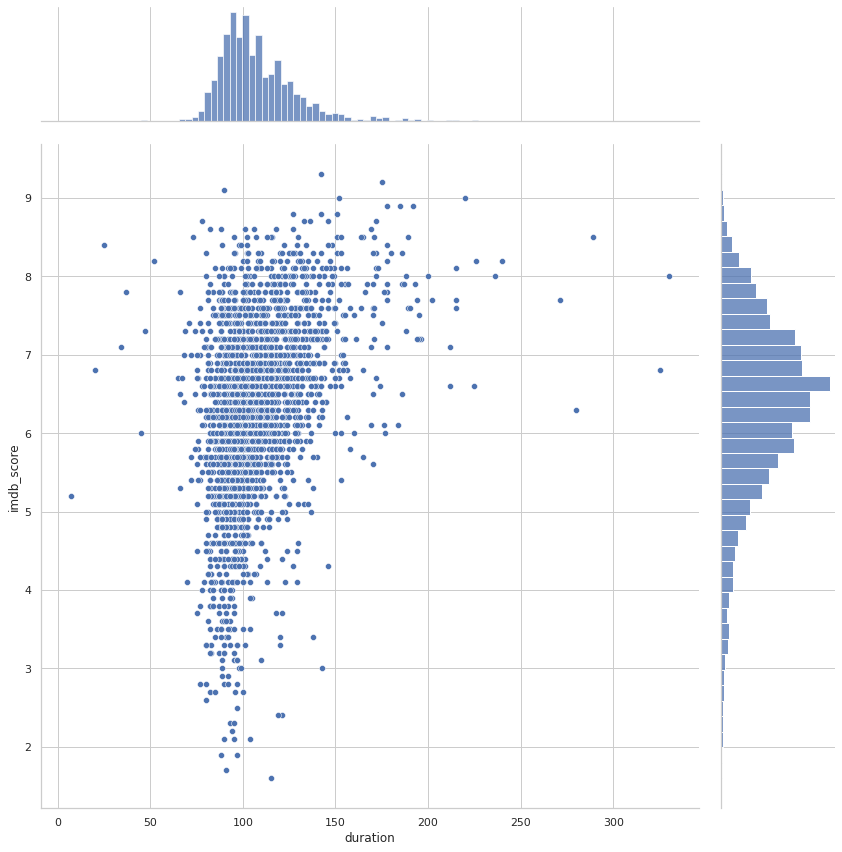

In [ ]:
sb.jointplot(data = imdb_dur_score, x = "duration", y = "imdb_score", height =12)
imdb_dur_score.corr()

Correlation between duration of movie and imdb_score is 0.37
--> slightly low correlation

In [ ]:
imdb_dur_score['score_cat'] = pd.cut(imdb_dur_score["imdb_score"], \
                                     bins = imdb_bins, labels = imdb_labels)
imdb_dur_score.head()

duration  imdb_score score_cat
4757      91.0         6.5      good
819       87.0         5.7      good
4268     100.0         6.8      good
3872     103.0         5.8      good
3537      88.0         4.8        ok

<Figure size 7200x2160 with 0 Axes>

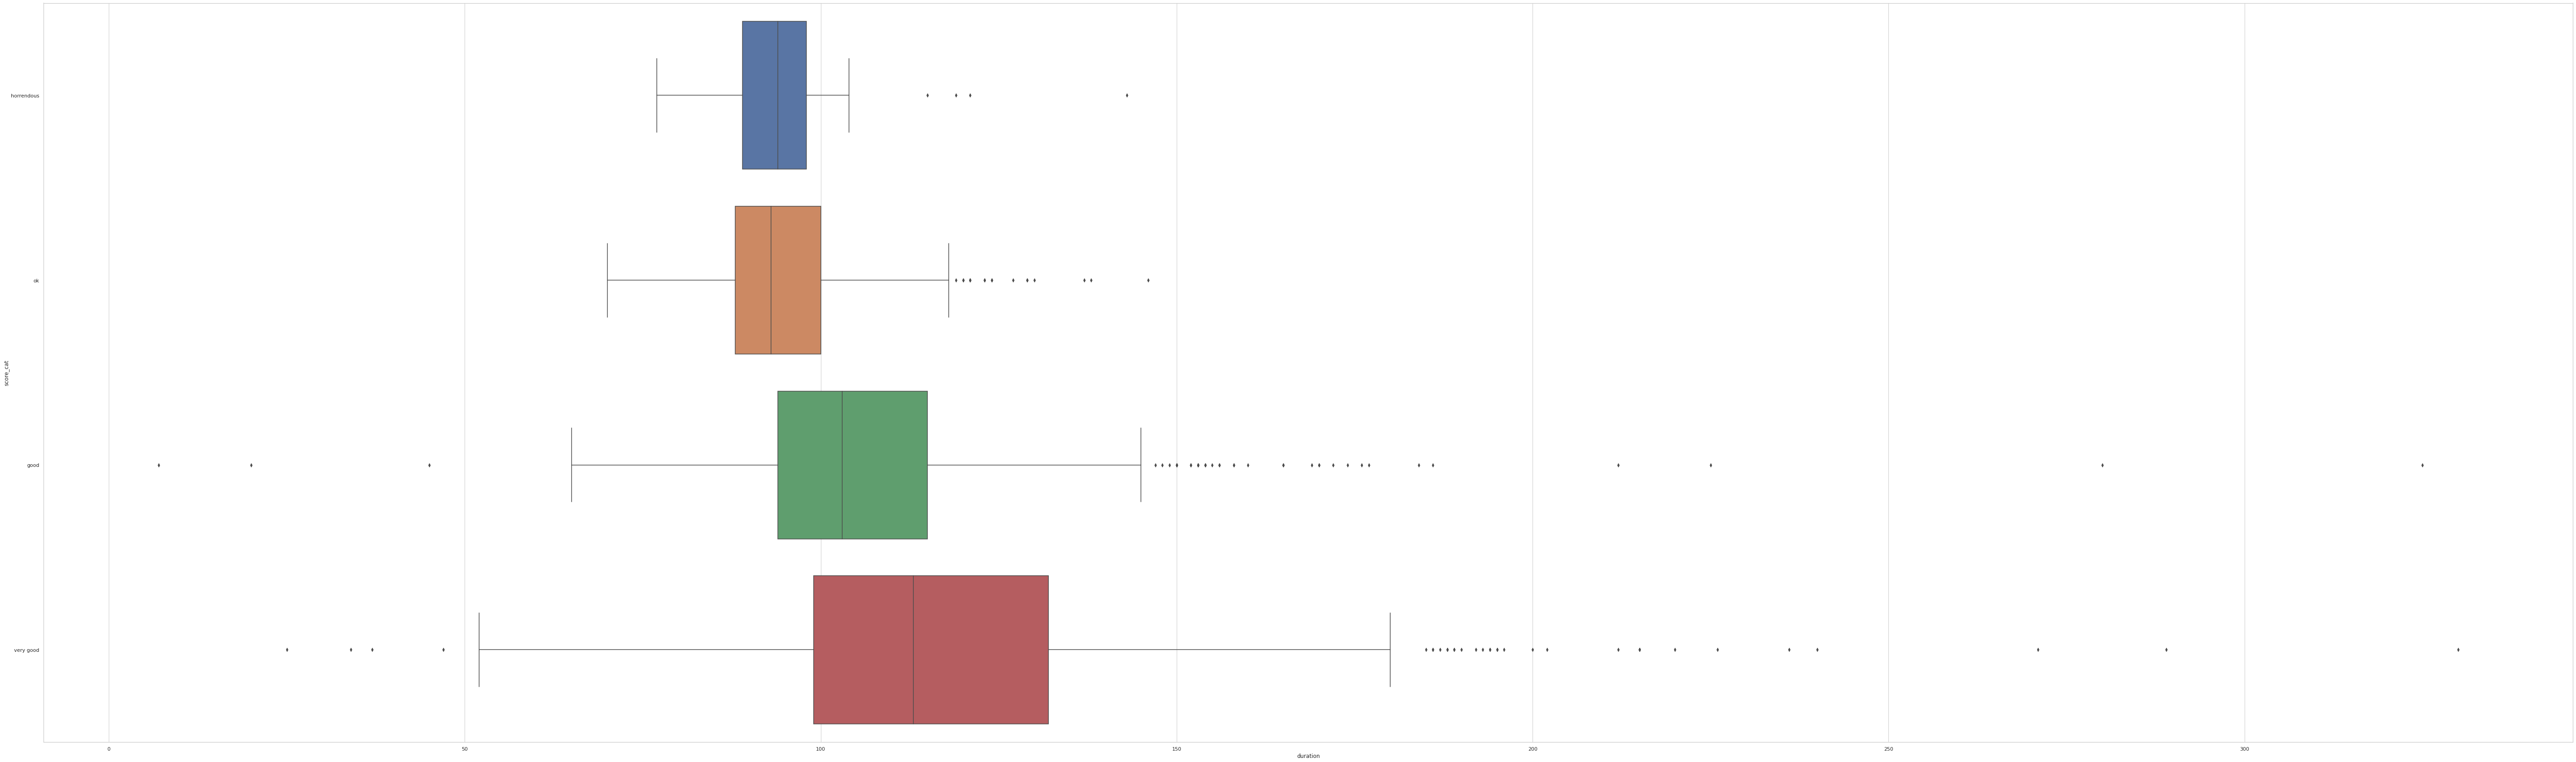

In [ ]:
plt.figure(figsize = (100,30))
p = sb.boxplot(x = "duration", y = "score_cat", data = imdb_dur_score)
_ = p.set(xlabel = "duration", ylabel = "score_cat")

it does seem like there is slight correlation! <- which agrees with our random tree feature importance thing



## budget vs imdbscore **(unwanted)**

budget  imdb_score
budget       1.000       0.033
imdb_score   0.033       1.000

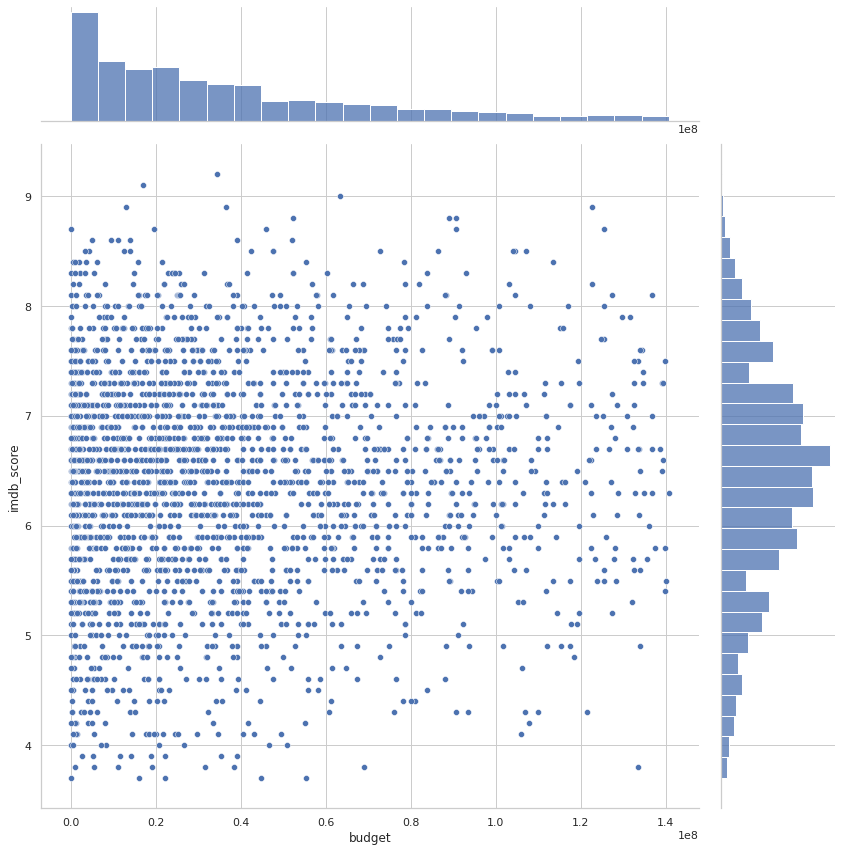

In [ ]:
budgetVSimdbscore = pd.concat([budget_filtered,imdb_score_clean], axis=1).reindex(imdb_score_clean.index)
newBudgetIMDB = budgetVSimdbscore.dropna(axis = 0, how = 'any')

sb.jointplot(data = newBudgetIMDB, x = "budget", y = "imdb_score", height = 12)
newBudgetIMDB.corr()

budget vs imdb corr value = 0.03257

horrible correlation, shows that a high budget does not guarantee success.

## movie fb likes vs imdbscore

movie_facebook_likes  imdb_score
movie_facebook_likes                 1.000       0.291
imdb_score                           0.291       1.000

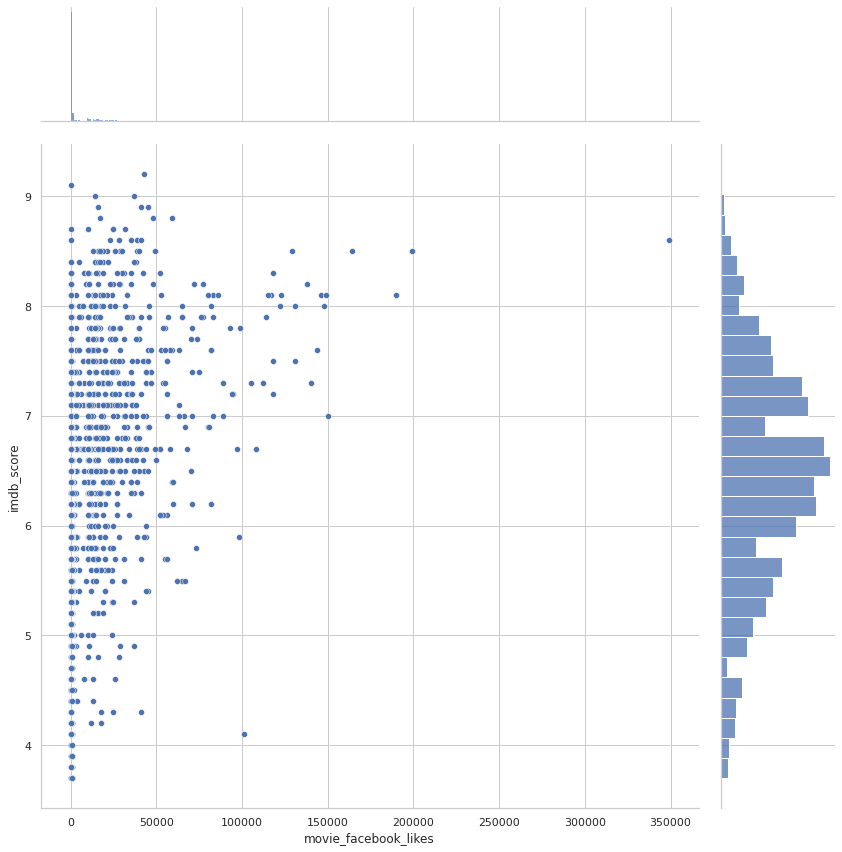

In [ ]:
movielikesVSimdbscore=pd.concat([movie_likes,imdb_score_clean], axis=1).reindex(imdb_score_clean.index)
newMovielikesIMDB = movielikesVSimdbscore.dropna(axis = 0, how = 'any')

sb.jointplot(data=newMovielikesIMDB,x="movie_facebook_likes", y="imdb_score", height =12)
newMovielikesIMDB.corr()

movies likes vs imdb corr value = 0.2911

Popularity of the movie does not indicate that the movie is good

## num of users voted vs imdbscore

In [ ]:
votesVsImdb=pd.concat([numVoted, imdb_score], join="outer",axis=1)
votesVsImdb.describe()

num_voted_users  imdb_score
count        2.728e+03    2728.000
mean         9.605e+04       6.351
std          1.556e+05       1.125
min          5.000e+00       1.600
25%          1.166e+04       5.700
50%          4.266e+04       6.500
75%          1.104e+05       7.100
max          1.690e+06       9.300

In [ ]:
votesVsImdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_voted_users  2728 non-null   int64  
 1   imdb_score       2728 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 128.5 KB


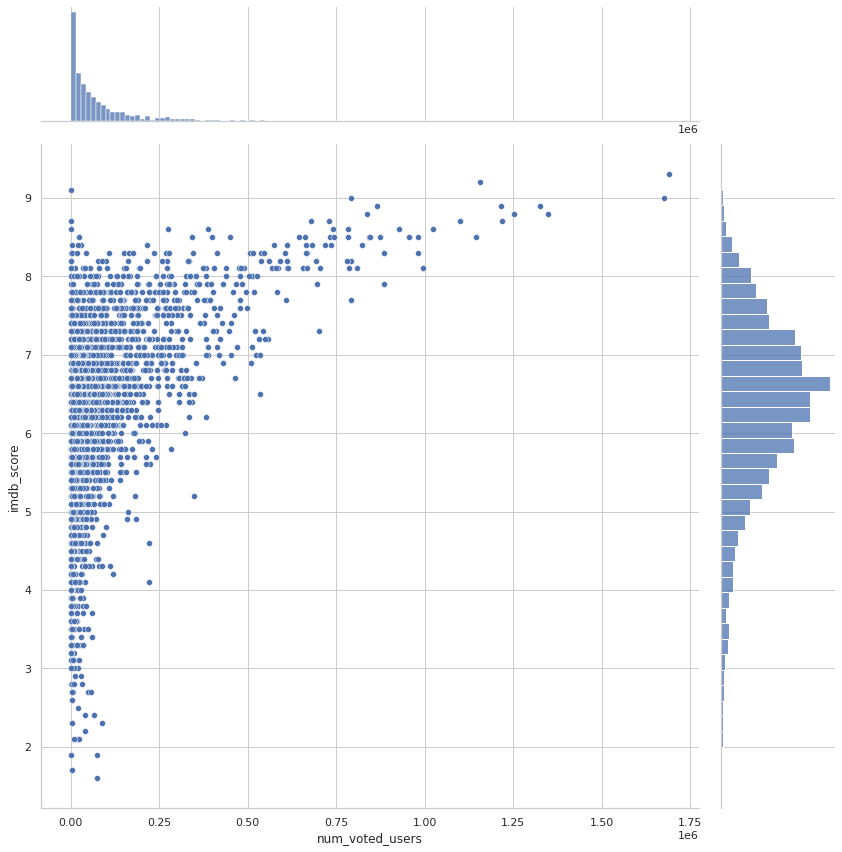

In [ ]:
sb.jointplot(data=votesVsImdb,x="num_voted_users", y="imdb_score", height =12)

In [ ]:
votesVsImdb.corr()

num_voted_users  imdb_score
num_voted_users            1.000       0.471
imdb_score                 0.471       1.000

In [ ]:
#compare with the cleaned num of users voted data
votesVsImdb2=pd.concat([numVotedclean, imdb_score], join="outer",axis=1)
votesVsImdb2.dropna(axis = 0, how = "any", inplace = True)
votesVsImdb2.head()

num_voted_users  imdb_score
5          212204.0         6.6
11         240396.0         6.1
16         149922.0         6.6
24         149019.0         6.1
28         202382.0         5.9

In [ ]:
votesVsImdb2.corr()
#correlation became worse after removing outlier

num_voted_users  imdb_score
num_voted_users            1.000       0.341
imdb_score                 0.341       1.000

## number of cast likes vs imdbscore

In [ ]:
castLikesVsImdb=pd.concat([castLikes, imdb_score], join="outer",axis=1)
castLikesVsImdb.head()

cast_total_facebook_likes  imdb_score
4757                       1047         6.5
819                       14574         5.7
4268                       2186         6.8
3872                       3089         5.8
3537                       3150         4.8

In [ ]:
castLikesVsImdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cast_total_facebook_likes  2728 non-null   int64  
 1   imdb_score                 2728 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 128.5 KB


In [ ]:
castLikesVsImdb.corr()
#bad correlation

cast_total_facebook_likes  imdb_score
cast_total_facebook_likes                      1.000       0.144
imdb_score                                     0.144       1.000

In [ ]:
#lets try the correlation between cast likes with removed outlier and imdb score
castLikesVsImdb2=pd.concat([castLikesclean, imdb_score], join="outer",axis=1)
castLikesVsImdb2.corr()
#only slight improvement

cast_total_facebook_likes  imdb_score
cast_total_facebook_likes                       1.00        0.17
imdb_score                                      0.17        1.00

## director_name vs imdb_score (SH)
```
which director has the highest imdb_score? 
does the frequency of director also have higher imdb_score? 
i.e: is there a relationship between the frequency of the director and imdb_score? 
```
recall from director_name eda: 
```
  Director:             Count:
  Steven Spielberg        22
  Woody Allen             18
  Clint Eastwood          17
  Spike Lee               15
  Ridley Scott            15
  Martin Scorsese         15
  Steven Soderbergh       12
  Renny Harlin            12
  Robert Zemeckis         12

```

In [ ]:
# get the top 100 most frequently appeared directors 
director_top100 = pd.DataFrame(director_name["director_name"].copy().value_counts(ascending = False).head(100)).reset_index()
director_top100.rename(columns = {'director_name' : 'count', 'index' : 'director_name'}, inplace = True)
director_top100.head()

director_name  count
0  Steven Spielberg     17
1       Woody Allen     16
2   Martin Scorsese     16
3    Clint Eastwood     15
4         Spike Lee     12

In [ ]:
# calculate the mean and median imdb_scores for each director in the top 100 

for ind, info in director_top100.iterrows():
  total_score = director_name.loc[director_name["director_name"]\
                                                     == info[0], "imdb_score"].sum()
  director_top100.loc[ind, "total_score"] = total_score
  director_top100.loc[ind, "mean_score"] = total_score/ info[1] #info[1] == count
  #director_top100.loc[ind, "median_score"] = np.median(imdb.loc[imdb["director_name"] == info[0], "imdb_score")
  

In [ ]:
director_top100.sort_values(by = "mean_score", inplace = False, ascending = False, axis = 0).head(20)

director_name  count  total_score  mean_score
33     Christopher Nolan      7         58.6       8.371
26     Quentin Tarantino      7         57.5       8.214
25         David Fincher      7         55.2       7.886
88         James Cameron      5         38.9       7.780
97      Darren Aronofsky      4         31.1       7.775
2        Martin Scorsese     16        123.3       7.706
55          Wes Anderson      6         45.7       7.617
0       Steven Spielberg     17        128.3       7.547
8   Francis Ford Coppola     10         74.4       7.440
68          Michael Mann      5         37.1       7.420
59       Alexander Payne      5         37.1       7.420
73             James Wan      5         37.0       7.400
3         Clint Eastwood     15        109.7       7.313
6        Robert Zemeckis     12         87.7       7.308
54          Bryan Singer      6         43.7       7.283
56            Mel Brooks      5         36.3       7.260
42          Marc Forster      6         43.5       7.250
58      Alfred Hitchcock      5         36.1       7.220
57        Gore Verbinski      5         35.8       7.160
22          Gus Van Sant      7         49.9       7.129

it seems like Steven Spielberg (director with highest count) is one of the top5

In [ ]:
pd.set_option("display.precision", 3)
director_top100.describe()

count  total_score  mean_score
count  100.000      100.000     100.000
mean     6.680       44.797       6.638
std      2.689       20.457       0.669
min      4.000       23.200       4.760
25%      5.000       32.775       6.165
50%      6.000       38.000       6.692
75%      7.000       48.850       6.962
max     17.000      128.300       8.371

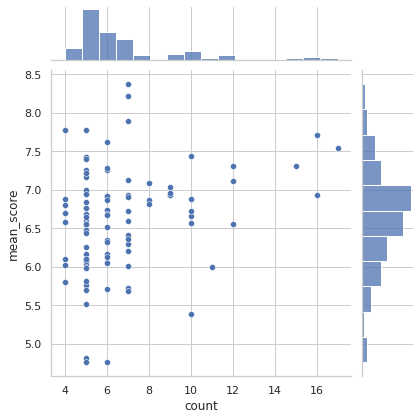

In [ ]:
sb.jointplot(data = director_top100, x = "count", y = "mean_score")

In [ ]:
director_top100[["count", "mean_score"]].corr()

count  mean_score
count       1.000       0.255
mean_score  0.255       1.000

**Comments**

from here, it doesn't seem like there's much correlation between the director_name count and the mean imdb_score for each director. Although, it is good to note that: 
1. We are dealing with a very small dataset, therefore it is not representative of the whole movie industry 
2. We can see that there are a few outliers that have both high frequency and high mean_score, maybe a better EDA would be to use decision tree. 



## num_critic_for_reviews vs imdb_score

In [ ]:
numCritic = pd.DataFrame(imdb['num_critic_for_reviews'])
imdb_score = pd.DataFrame(imdb['imdb_score'])
criticsVsImdb = pd.concat([numCritic, imdb_score], join="outer", axis=1)
criticsVsImdb.head()

num_critic_for_reviews  imdb_score
4757                    28.0         6.5
819                     84.0         5.7
4268                   126.0         6.8
3872                    29.0         5.8
3537                   112.0         4.8

num_critic_for_reviews  imdb_score
num_critic_for_reviews                   1.000       0.343
imdb_score                               0.343       1.000

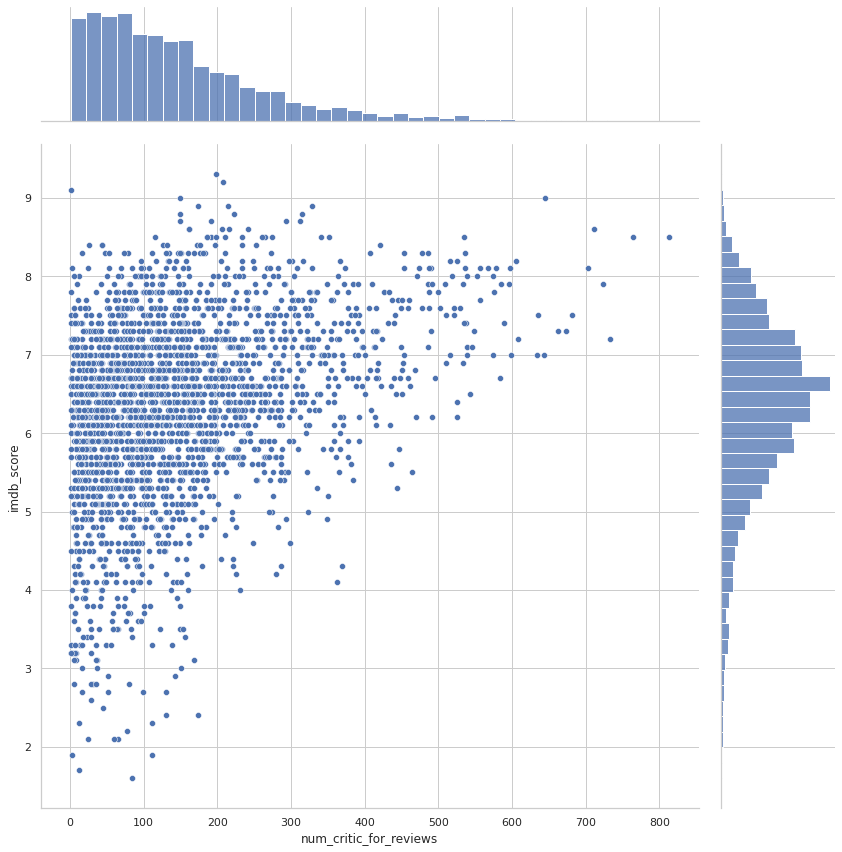

In [ ]:
sb.jointplot(data=criticsVsImdb, x = "num_critic_for_reviews", y = "imdb_score", height=12)
criticsVsImdb.corr()


## genres vs imdb_score
previously from genre EDA, we found out that: 

|index|Genre|Count|
|---|---|---|
|0|Drama|2020|**bold text**
|1|Comedy|1461|
|2|Thriller|1127|
|3|Action|896|
|4|Romance|866|
|5|Crime|709|
|6|Adventure|702|
|7|Sci-Fi|469|
|8|Fantasy|461|
|9|Horror|436|



In [ ]:
from collections import defaultdict
values = defaultdict(list)
for ind, row in imdb.iterrows():
    for genre in row['genres'].split('|'):
        values[genre].append(row['imdb_score'])
        
        
genre_lst, score_lst = [], []
for key, item in values.items():
    if key not in [0, 1]:
        genre_lst.append(key)
        score_lst.append(np.mean(item))
        
genres_with_score = pd.DataFrame([genre_lst, score_lst]).T
genres_with_score.columns = ['Genre', 'Mean_score']
genres_with_score.sort_values("Mean_score", ascending = False, inplace = True, axis = 0)
genres_with_score.head()

Genre Mean_score
22  Film-Noir       7.72
17  Biography      7.135
21       News        7.1
18    History      7.099
4         War      7.074

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

<Figure size 12960x3600 with 0 Axes>

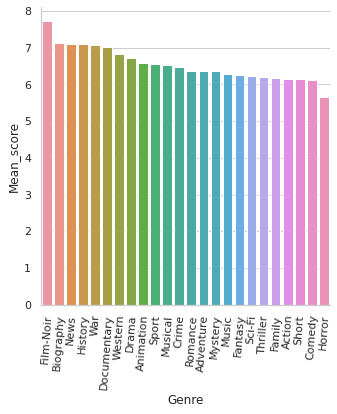

In [ ]:
f = plt.figure(figsize = (180,50))
sb.catplot(data = genres_with_score, y = "Mean_score", x = "Genre", kind = "bar")
plt.xticks(rotation=86)


  It seems like drama, the most common genre is placed 7th in terms of mean_score

let's check whether the frequency of a type of genre implies better mean_score

In [ ]:
# add another column to the dataframe 
for ind, info in genres_with_score.iterrows():
  genres_with_score.loc[ind, "count"] = genreFreq.loc[genreFreq["Genre"] == info[0], "Count"].item()

display(genres_with_score)

Genre Mean_score   count
22    Film-Noir       7.72     5.0
17    Biography      7.135   133.0
21         News        7.1     1.0
18      History      7.099    74.0
4           War      7.074    88.0
19  Documentary       7.02    55.0
13      Western      6.818    51.0
5         Drama      6.709  1302.0
15    Animation       6.57   134.0
10        Sport      6.561    98.0
20      Musical      6.518    82.0
14        Crime      6.474   491.0
11      Romance      6.372   613.0
2     Adventure      6.368   517.0
8       Mystery      6.353   261.0
16        Music      6.285   127.0
6       Fantasy      6.254   345.0
9        Sci-Fi      6.223   356.0
3      Thriller      6.215   772.0
12       Family      6.183   315.0
1        Action      6.154   647.0
23        Short       6.15     2.0
0        Comedy      6.128  1113.0
7        Horror       5.67   305.0

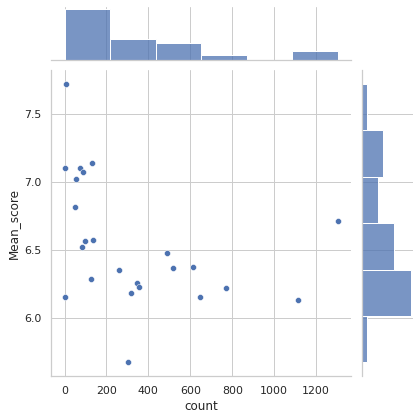

In [ ]:
sb.jointplot(data = genres_with_score, x = "count", y = "Mean_score")

In [ ]:
genres_with_score[["count", "Mean_score"]].astype(int).corr()

count  Mean_score
count       1.000      -0.387
Mean_score -0.387       1.000

no correlation bw frequency of genre and its mean_score. 

## director_facebook_likes vs imdb_score

In [ ]:
dir_likes_score = imdb[["director_facebook_likes", "imdb_score"]].copy()
dir_likes_score.dropna(axis = 0, how = "any", inplace = True)
dir_likes_score["score_cat"] = pd.cut(dir_likes_score["imdb_score"].copy(), \
                                     bins = imdb_bins, labels = imdb_labels)
dir_likes_score.head()

director_facebook_likes  imdb_score score_cat
4757                      0.0         6.5      good
819                      10.0         5.7      good
4268                    308.0         6.8      good
3872                    249.0         5.8      good
3537                      0.0         4.8        ok

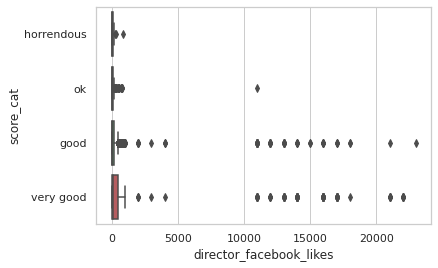

In [ ]:
sb.boxplot(data = dir_likes_score, x = "director_facebook_likes", y = "score_cat")

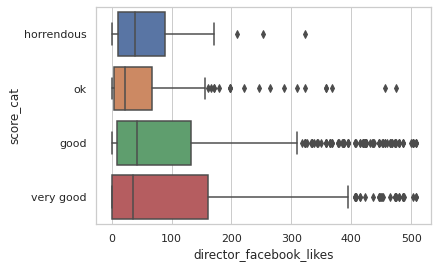

In [ ]:
dir_likes_score_copy = remove_outlier(dir_likes_score, "director_facebook_likes")
sb.boxplot(data = dir_likes_score_copy, x = "director_facebook_likes", y = "score_cat")

In [ ]:
# hmm, still seems like there's not much correlation, but, maybe we can see which 
# has larger proportion of outliers! 

In [ ]:
dir_likes_score["score_cat"].value_counts()

good          1693
very good      731
ok             275
horrendous      29
Name: score_cat, dtype: int64

# Multivariate EDA

In [ ]:
# Create a new DataFrame with all the relevant variables included
NewDF = pd.DataFrame(imdb[["director_name", "num_critic_for_reviews", "duration", "director_facebook_likes", 
                            "actor_3_facebook_likes", "actor_2_name", "actor_1_facebook_likes", "gross", "genres", "actor_1_name",
                            "num_voted_users", "cast_total_facebook_likes", "actor_3_name", "facenumber_in_poster", "plot_keywords",
                            "num_user_for_reviews", "language", "country", "content_rating", "budget", "title_year", "actor_2_facebook_likes",
                            "imdb_score", "aspect_ratio", "movie_facebook_likes"]]).copy()

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(40, 40))
sb.heatmap(NewDF.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

From the heat map it seems like some variables affecting imdb_score are:
- num_critic_for_reviews
- duration
- num_voted_users
- num_user_for_reviews
- movie_facebook likes

Although their indivdual correlation values are objective moderate, it is higher and more significant compared to the other variables.

#Machine learning and model building

In [ ]:
# rename the ACTUAL test dataset for simplicity 
imdb_test = imdb_test_clean.drop_duplicates(subset = "movie_title")
imdb_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 0 to 585
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 586 non-null    int64  
 1   Unnamed: 0.1               586 non-null    float64
 2   color                      586 non-null    object 
 3   director_name              586 non-null    object 
 4   num_critic_for_reviews     586 non-null    float64
 5   duration                   586 non-null    float64
 6   director_facebook_likes    586 non-null    float64
 7   actor_3_facebook_likes     586 non-null    float64
 8   actor_2_name               586 non-null    object 
 9   actor_1_facebook_likes     586 non-null    float64
 10  gross                      586 non-null    float64
 11  genres                     586 non-null    object 
 12  actor_1_name               586 non-null    object 
 13  movie_title                586 non-null    object 

## Linear Regression



cast_total_facebook_likes vs imdb_score

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
imdb_score = pd.DataFrame(imdb['imdb_score'])  # Response
castfblikes = pd.DataFrame(imdb['cast_total_facebook_likes']) #predictor

# Split the Dataset into Train and Test
castLikes_train, castLikes_test, imdb1_train, imdb1_test = train_test_split(castfblikes, imdb_score, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(castLikes_train, imdb1_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict imdb_score corresponding to castfblikes
imdb1_train_pred = linreg.predict(castLikes_train)
imdb1_test_pred = linreg.predict(castLikes_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(castLikes_train, imdb1_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(imdb1_train, imdb1_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(castLikes_test, imdb1_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(imdb1_test, imdb1_test_pred))
print()


LinearRegression()

Intercept of Regression 	: b =  [6.26287927]
Coefficients of Regression 	: a =  [[7.2794522e-06]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.02035977140748646
Mean Squared Error (MSE) 	: 1.2042410507594552

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.020296290381221826
Mean Squared Error (MSE) 	: 1.340452422735572



In [ ]:
#predict imdb score corresponding to total cast likes train
f = plt.figure(figsize=(16, 8))
plt.scatter(castLikes_train, imdb1_train)
plt.scatter(castLikes_train, imdb1_train_pred, color = "r")
plt.show()


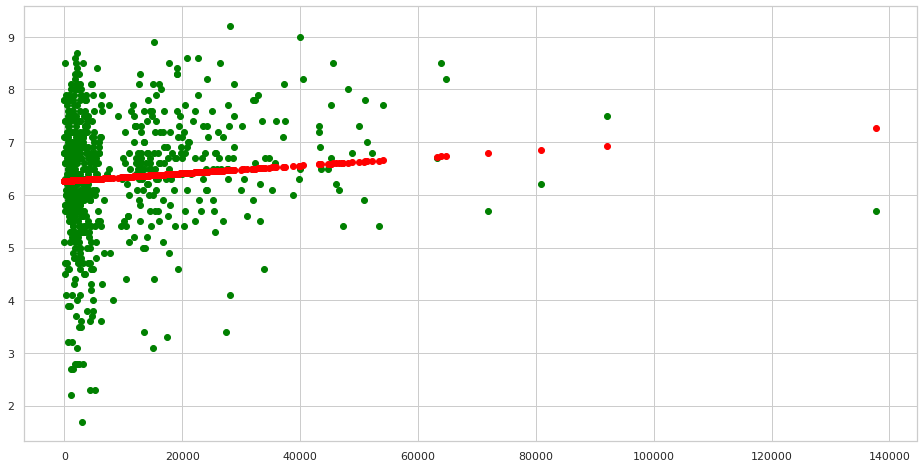

In [ ]:
# Predict imdb score corresponding to total cast likes Test
imdb1_test_pred = linreg.predict(castLikes_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(castLikes_test, imdb1_test, color = "green")
plt.scatter(castLikes_test, imdb1_test_pred, color = "red")
plt.show()

num_voted_users vs imdb_score

In [ ]:
imdb_score = pd.DataFrame(imdb['imdb_score'])  # Response
numVoted = pd.DataFrame(imdb['num_voted_users']) #predictor

# Split the Dataset into Train and Test
numVoted_train, numVoted_test, imdb_train, imdb_test = train_test_split(numVoted, imdb_score, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(numVoted_train, imdb_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict imdb_score corresponding to castfblikes
imdb_train_pred = linreg.predict(numVoted_train)
imdb_test_pred = linreg.predict(numVoted_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(numVoted_train, imdb_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(imdb_train, imdb_train_pred))
print()


# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(numVoted_test, imdb_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(imdb_test, imdb_test_pred))
print()




LinearRegression()

Intercept of Regression 	: b =  [6.0366686]
Coefficients of Regression 	: a =  [[3.42889242e-06]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.22208628941152975
Mean Squared Error (MSE) 	: 0.9685399553356702

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.21746431569744906
Mean Squared Error (MSE) 	: 1.0320333452689046



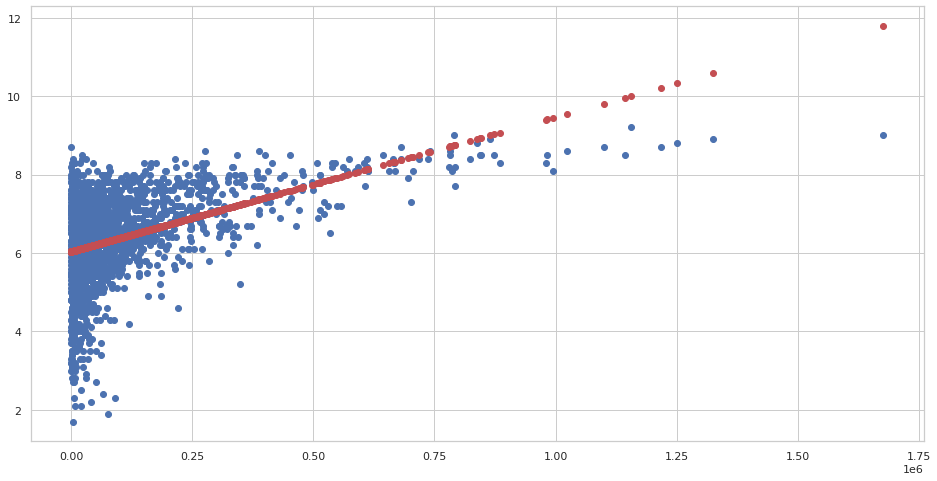

In [ ]:
#Predict imdb score corresponding to numVoted train
f = plt.figure(figsize=(16, 8))
plt.scatter(numVoted_train, imdb_train)
plt.scatter(numVoted_train, imdb_train_pred, color = "r")
plt.show()

In [ ]:
# Predict imdb score corresponding to numVoted Test
imdb_test_pred = linreg.predict(numVoted_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(numVoted_test, imdb_test, color = "green")
plt.scatter(numVoted_test, imdb_test_pred, color = "red")
plt.show()

movie_facebook_likes vs imdb score

In [ ]:
imdb_score = pd.DataFrame(imdb['imdb_score'])  # Response
movieLikes = pd.DataFrame(imdb['movie_facebook_likes']) #predictor

# Split the Dataset into Train and Test
movieLikes_train, movieLikes_test, imdb_train, imdb_test = train_test_split(movieLikes, imdb_score, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(movieLikes_train, imdb_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict imdb_score corresponding to castfblikes
imdb_train_pred = linreg.predict(movieLikes_train)
imdb_test_pred = linreg.predict(movieLikes_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(movieLikes_train, imdb_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(imdb_train, imdb_train_pred))
print()


# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(movieLikes_test, imdb_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(imdb_test, imdb_test_pred))
print()




LinearRegression()

Intercept of Regression 	: b =  [6.21526743]
Coefficients of Regression 	: a =  [[1.70477522e-05]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0895583673491126
Mean Squared Error (MSE) 	: 1.167091931693715

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.019877677528622684
Mean Squared Error (MSE) 	: 1.1865456200549467



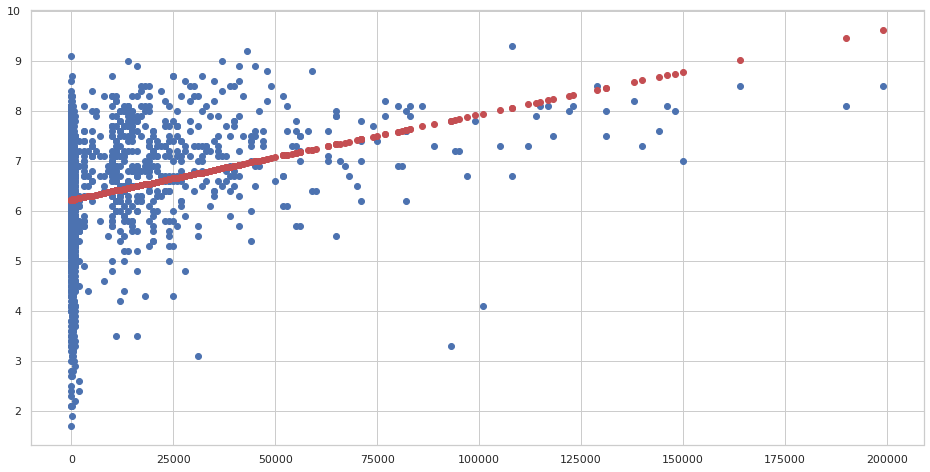

In [ ]:
#predict imdb score from movie likes
f = plt.figure(figsize=(16, 8))
plt.scatter(movieLikes_train, imdb_train)
plt.scatter(movieLikes_train, imdb_train_pred, color = "r")
plt.show()

In [ ]:
# Predict imdb score corresponding to movieLikes Test
imdb_test_pred = linreg.predict(movieLikes_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(movieLikes_test, imdb_test, color = "green")
plt.scatter(movieLikes_test, imdb_test_pred, color = "red")
plt.show()

In [ ]:
# here, we see that there are missing values in different variables. 
## dk what to talk about here, will fill it in some day 

# seems like we can use movie_facebook_likes, num_user_for_reviews (etc, will type out more to refine this) to determine its popularity 
# content_rating, imdb_score, gross as measures of success rate?

duration vs imdb score

In [ ]:
imdb_score = pd.DataFrame(imdb['imdb_score'])  # Response
duration = pd.DataFrame(imdb['duration']) #predictor

# Split the Dataset into Train and Test
duration_train, duration_test, imdb_train, imdb_test = train_test_split(movieLikes, imdb_score, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(duration_train, imdb_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict imdb_score corresponding to castfblikes
imdb_train_pred = linreg.predict(duration_train)
imdb_test_pred = linreg.predict(duration_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(duration_train, imdb_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(imdb_train, imdb_train_pred))
print()


# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(duration_test, imdb_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(imdb_test, imdb_test_pred))
print()



LinearRegression()

Intercept of Regression 	: b =  [6.26335573]
Coefficients of Regression 	: a =  [[1.41019655e-05]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.06850044931416865
Mean Squared Error (MSE) 	: 1.1694607589381611

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.07933015412603861
Mean Squared Error (MSE) 	: 1.1780678751540437



In [ ]:
#predict imdb score from duration
f = plt.figure(figsize=(16, 8))
plt.scatter(duration_train, imdb_train)
plt.scatter(duration_train, imdb_train_pred, color = "r")
plt.show()

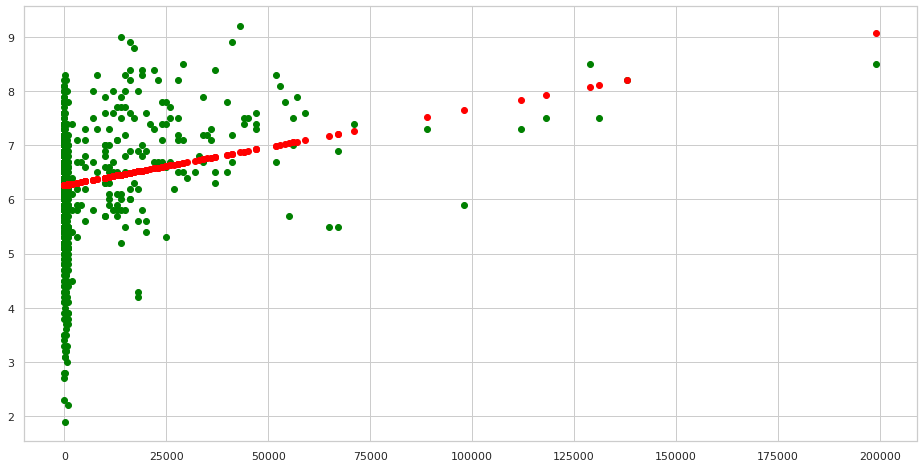

In [ ]:
# Predict imdb score corresponding to movieLikes Test
imdb_test_pred = linreg.predict(duration_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(duration_test, imdb_test, color = "green")
plt.scatter(duration_test, imdb_test_pred, color = "red")
plt.show()

## Multi Linear regression

In [ ]:
# cleaning the num variables
imdb_nums = imdb[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'num_voted_users', 'actor_3_facebook_likes',
                 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'cast_total_facebook_likes', 'num_user_for_reviews', 'budget',
                 'movie_facebook_likes', 'imdb_score']].copy()

# filling in null values with median
imdb_nums.fillna(imdb_nums.median(), inplace = True)

# remove remaining null
imdb_nums.dropna(inplace = True, axis = 0, how = "any")

# sanity check
imdb_nums.isnull().sum()
imdb_nums.info()

num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
num_voted_users              0
actor_3_facebook_likes       0
actor_1_facebook_likes       0
actor_2_facebook_likes       0
cast_total_facebook_likes    0
num_user_for_reviews         0
budget                       0
movie_facebook_likes         0
imdb_score                   0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_critic_for_reviews     2728 non-null   float64
 1   duration                   2728 non-null   float64
 2   director_facebook_likes    2728 non-null   float64
 3   num_voted_users            2728 non-null   int64  
 4   actor_3_facebook_likes     2728 non-null   float64
 5   actor_1_facebook_likes     2728 non-null   float64
 6   actor_2_facebook_likes     2728 non-null   float64
 7   cast_total_facebook_likes  2728 non-null   int64  
 8   num_user_for_reviews       2728 non-null   float64
 9   budget                     2728 non-null   float64
 10  movie_facebook_likes       2728 non-null   int64  
 11  imdb_score                 2728 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 277.1 KB


LinearRegression()

Intercept of Regression 	: b =  [4.78720659]
Coefficients of Regression 	: a =  [[ 1.63562146e-03  1.26525355e-02  1.13903095e-05  3.69418817e-06
   2.91186538e-05  2.91186538e-05  7.16386797e-05  6.94097508e-05
  -6.63645084e-05 -5.60689941e-04 -3.76907231e-09 -2.81809117e-06]]

                   Predictors  Coefficients
0      num_critic_for_reviews     1.636e-03
1                    duration     1.265e-02
2     director_facebook_likes     1.139e-05
3             num_voted_users     3.694e-06
4      actor_3_facebook_likes     2.912e-05
5      actor_3_facebook_likes     2.912e-05
6      actor_2_facebook_likes     7.164e-05
7      actor_1_facebook_likes     6.941e-05
8   cast_total_facebook_likes    -6.636e-05
9        num_user_for_reviews    -5.607e-04
10                     budget    -3.769e-09
11       movie_facebook_likes    -2.818e-06



Text(0.5, 0, 'True values of the Response Variable (Train)')

Text(0, 0.5, 'Predicted values of the Response Variable (Train)')

Text(0.5, 0, 'True values of the Response Variable (Test)')

Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

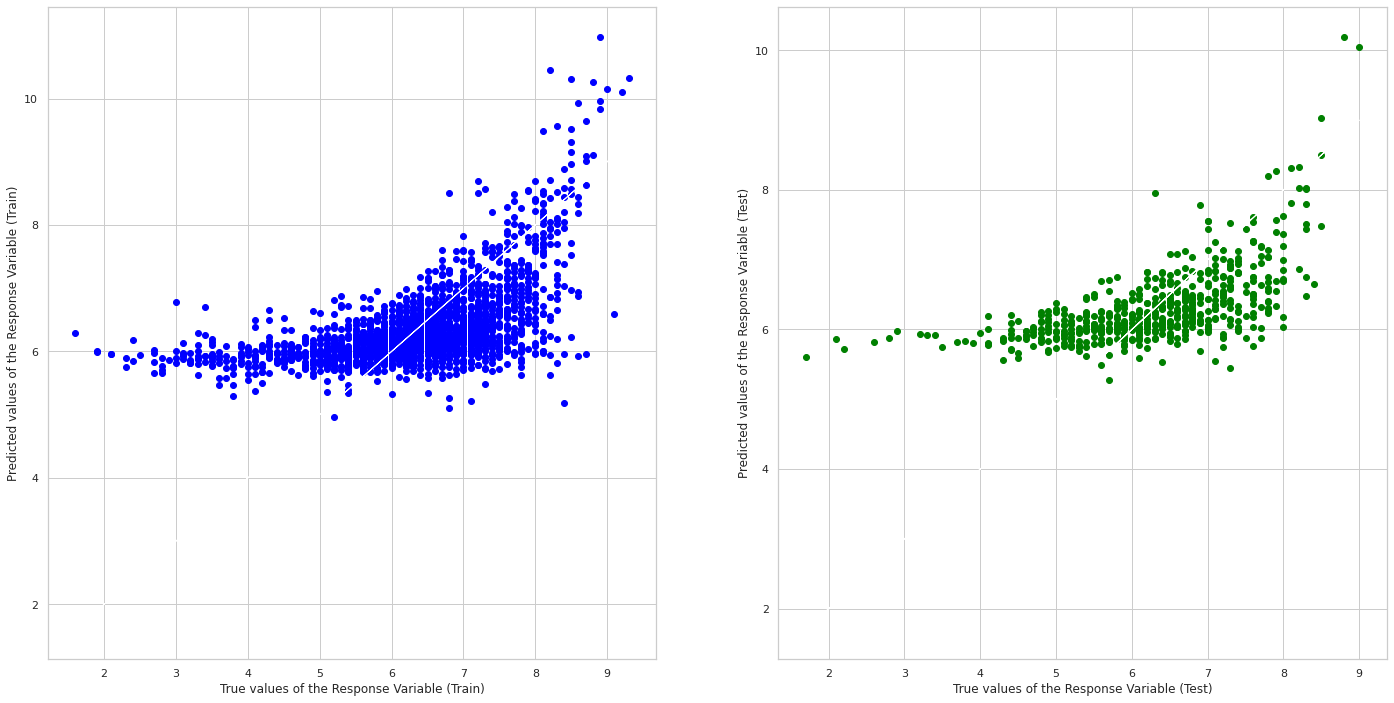

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3084720928806496
Mean Squared Error (MSE) 	: 0.8759536285443179

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.35346620610753576
Mean Squared Error (MSE) 	: 0.8074834844507471



In [ ]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
y = pd.DataFrame(imdb_nums["imdb_score"])
X = pd.DataFrame(imdb_nums[["num_critic_for_reviews", "duration", "director_facebook_likes", 
                            "num_voted_users", "actor_3_facebook_likes", "actor_3_facebook_likes",
                            "actor_2_facebook_likes", "actor_1_facebook_likes", "cast_total_facebook_likes",
                            "num_user_for_reviews", "budget", "movie_facebook_likes"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

In [ ]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
predictors = ["num_critic_for_reviews", "duration", "director_facebook_likes", 
              "num_voted_users", "actor_3_facebook_likes", "actor_3_facebook_likes",
              "actor_2_facebook_likes", "actor_1_facebook_likes", "cast_total_facebook_likes",
              "num_user_for_reviews", "budget", "movie_facebook_likes"]

y = pd.DataFrame(imdb_nums["imdb_score"])
X = pd.DataFrame(imdb_nums[predictors])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

LinearRegression()

Intercept of Regression 	: b =  [4.70299997]
Coefficients of Regression 	: a =  [[ 1.67601328e-03  1.35852263e-02  1.51833063e-05  3.86874034e-06
   4.35045016e-05  4.35045016e-05  9.35291303e-05  8.70760645e-05
  -8.53186873e-05 -5.84998929e-04 -4.05019615e-09 -3.50216213e-06]]

                   Predictors  Coefficients
0      num_critic_for_reviews     1.676e-03
1                    duration     1.359e-02
2     director_facebook_likes     1.518e-05
3             num_voted_users     3.869e-06
4      actor_3_facebook_likes     4.350e-05
5      actor_3_facebook_likes     4.350e-05
6      actor_2_facebook_likes     9.353e-05
7      actor_1_facebook_likes     8.708e-05
8   cast_total_facebook_likes    -8.532e-05
9        num_user_for_reviews    -5.850e-04
10                     budget    -4.050e-09
11       movie_facebook_likes    -3.502e-06



Text(0.5, 0, 'True values of the Response Variable (Train)')

Text(0, 0.5, 'Predicted values of the Response Variable (Train)')

Text(0.5, 0, 'True values of the Response Variable (Test)')

Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.31265921427488486
Mean Squared Error (MSE) 	: 0.8681264303975

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.33765926511249056
Mean Squared Error (MSE) 	: 0.8400590119249085



## Logistic Regression

independent var vs imdb_score

independent vars: 
* director_name
* duration
* plot_keywords 
* facenumber_in_poster 
* num_critic_for_reviews 
* director_facebook_likes
* genres 


conclusions & observations: there does not seem to be a clear linear cut between groups, therefore, logistic 



In [ ]:
def f(row):
    if row['imdb_score'] >= 6.6:
        rating = 1
    else:
        rating = 0
    return rating

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
def log_reg_f(X, y) :
  import sklearn 
  from sklearn.linear_model import LogisticRegression
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import accuracy_score
  from scipy.special import expit 
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import classification_report 

  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y.values.ravel(), test_size = 0.2, random_state = 33) 
                                                                                                            
                                                      
  scaler = StandardScaler()
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred_logr = logreg.predict(X_test)

  cm = confusion_matrix(y_test, y_pred_logr)
  sb.heatmap(cm, annot = True, fmt=".0f", annot_kws={"size": 18})
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()
  print(classification_report(y_test, y_pred_logr))
  TN = cm[0][0]
  FN = cm[1][0]
  TP = cm[1][1]
  FP = cm[0][1]
  print("accuracy : %.2f \t" %accuracy_score(y_test, y_pred_logr))
  print("FPR : %.2f \t"%(FP/(TN+FP)))
  print("FNR : %.2f \t"%(FN/(TP+FN)))
  print("TPR : %.2f \t"%(TP/(TP+FN)))
  print("TNR : %.2f \t"%(TN/(TN+FP)))


#### **duration**

In [ ]:
duration_logr = imdb[["duration", "imdb_score"]].copy()
duration_logr.isnull().sum()

duration      3
imdb_score    0
dtype: int64

In [ ]:
# clean the dataset 
duration_logr_clean = duration_logr.dropna(how = "any", axis = 0).copy()
duration_logr_clean.isnull().sum()

duration      0
imdb_score    0
dtype: int64

In [ ]:
duration_logr_clean["imdb_goodbad"] = duration_logr.apply(f, axis = 1)
duration_logr_clean.head()

duration  imdb_score  imdb_goodbad
4757      91.0         6.5             0
819       87.0         5.7             0
4268     100.0         6.8             1
3872     103.0         5.8             0
3537      88.0         4.8             0

In [ ]:
X = duration_logr_clean.drop(columns = ["imdb_score", "imdb_goodbad"], axis = 1)
y = duration_logr_clean[["imdb_goodbad"]]

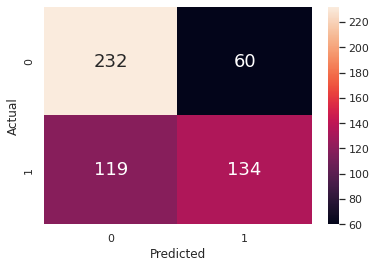

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       292
           1       0.69      0.53      0.60       253

    accuracy                           0.67       545
   macro avg       0.68      0.66      0.66       545
weighted avg       0.67      0.67      0.66       545

accuracy : 0.67 	
FPR : 0.21 	
FNR : 0.47 	
TPR : 0.53 	
TNR : 0.79 	


In [ ]:
log_reg_f(X,y)

### num_critic_for_reviews

In [ ]:
num_reviews_logr = imdb[["imdb_score", "num_critic_for_reviews"]].copy()
num_reviews_logr["imdb_goodbad"] = num_reviews_logr.apply(f,axis = 1)

In [ ]:
num_reviews_logr.dropna(how = "any", inplace = True, axis = 0)

In [ ]:
X = num_reviews_logr.drop(columns = ["imdb_score", "imdb_goodbad"], axis = 1)
y = num_reviews_logr[["imdb_goodbad"]]

In [ ]:
log_reg_f(X, y)

              precision    recall  f1-score   support

           0       0.61      0.77      0.68       295
           1       0.61      0.42      0.50       246

    accuracy                           0.61       541
   macro avg       0.61      0.60      0.59       541
weighted avg       0.61      0.61      0.60       541

accuracy : 0.61 	
FPR : 0.23 	
FNR : 0.58 	
TPR : 0.42 	
TNR : 0.77 	


In [ ]:
num_reviews_logr_removed = remove_outlier(num_reviews_logr, "num_critic_for_reviews")

### budget 

In [ ]:
budget_logr = imdb[["budget", "imdb_score"]].copy()
budget_logr["imdb_goodbad"] = budget_logr.apply(f, axis = 1)

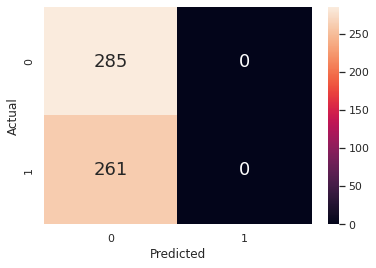

              precision    recall  f1-score   support

           0       0.52      1.00      0.69       285
           1       0.00      0.00      0.00       261

    accuracy                           0.52       546
   macro avg       0.26      0.50      0.34       546
weighted avg       0.27      0.52      0.36       546

accuracy : 0.52 	
FPR : 0.00 	
FNR : 1.00 	
TPR : 0.00 	
TNR : 1.00 	


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
log_reg_f(budget_logr[["budget"]], budget_logr[["imdb_goodbad"]])

### num_voted_users

In [ ]:
num_voted_users_logr = imdb[["num_voted_users", "imdb_score"]].copy() 
num_voted_users_logr["imdb_goodbad"] = num_voted_users_logr.apply(f, 1)

In [ ]:
num_voted_users_logr.isnull().sum()

num_voted_users    0
imdb_score         0
imdb_goodbad       0
dtype: int64

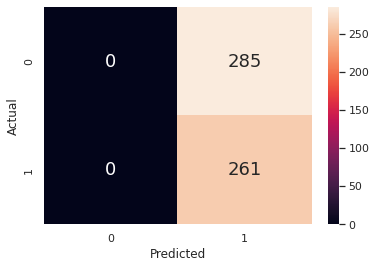

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       285
           1       0.48      1.00      0.65       261

    accuracy                           0.48       546
   macro avg       0.24      0.50      0.32       546
weighted avg       0.23      0.48      0.31       546

accuracy : 0.48 	
FPR : 1.00 	
FNR : 0.00 	
TPR : 1.00 	
TNR : 0.00 	


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
log_reg_f(num_voted_users_logr[["num_voted_users"]], num_voted_users_logr[["imdb_goodbad"]])

## Multivariate **Logistic** Regression 

In [ ]:
def f(row):
    if row['imdb_score'] >= 6.6:
        rating = "good"
    else:
        rating = "bad"
    return rating

In [ ]:
# define the dataset 
imdb_clean_logr = imdb[[ "num_critic_for_reviews", "director_facebook_likes", "num_user_for_reviews", "imdb_score", "duration", "budget"]].dropna(inplace = False, how = "any", axis = 0).reset_index()
imdb_clean_logr['imdb_goodbad'] = imdb_clean_logr.apply(f, axis=1)
X_logr,y_logr = imdb_clean_logr[["num_critic_for_reviews", "director_facebook_likes", "num_user_for_reviews", "duration", "budget"]], imdb_clean_logr[["imdb_goodbad"]]

In [ ]:
imdb_clean_logr.head()

index  num_critic_for_reviews  director_facebook_likes  \
0   4757                    28.0                      0.0   
1    819                    84.0                     10.0   
2   4268                   126.0                    308.0   
3   3872                    29.0                    249.0   
4   3537                   112.0                      0.0   

   num_user_for_reviews  imdb_score  duration     budget imdb_goodbad  
0                  10.0         6.5      91.0  5.789e+05          bad  
1                 171.0         5.7      87.0  1.278e+08          bad  
2                 545.0         6.8     100.0  1.957e+06         good  
3                  32.0         5.8     103.0  4.562e+06          bad  
4                  70.0         4.8      88.0  7.469e+06          bad

In [ ]:
X_logr.isnull().sum()

num_critic_for_reviews     0
director_facebook_likes    0
num_user_for_reviews       0
duration                   0
budget                     0
dtype: int64

In [ ]:
y_logr.isnull().sum()

imdb_goodbad    0
dtype: int64

In [ ]:
# evaluate multinomial logistic regression model
from numpy import mean
from numpy import std
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# split the dataset into train and validation 
X_train_logr, X_test_logr, y_train_logr, y_test_logr = sklearn.model_selection.train_test_split(X_logr, y_logr, test_size = 0.2 )
# define the multinomial logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_logr, y_train_logr)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
logreg.fit(X_train_logr, y_train_logr)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
y_pred_logr = logreg.predict(X_test_logr)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_logr, y_pred_logr)

0.6025878003696857

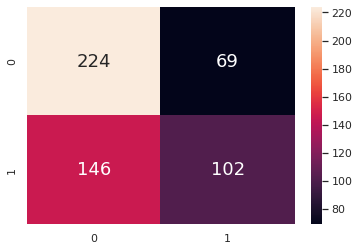

In [ ]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_logr, y_pred_logr)
sb.heatmap(cm, annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
print(classification_report(y_test_logr, y_pred_logr))

              precision    recall  f1-score   support

         bad       0.61      0.76      0.68       293
        good       0.60      0.41      0.49       248

    accuracy                           0.60       541
   macro avg       0.60      0.59      0.58       541
weighted avg       0.60      0.60      0.59       541



In [ ]:
X_train_s = scaler.fit_transform(X_train_logr)
X_test_s = scaler.transform(X_test_logr) 

In [ ]:
logreg.fit(X_train_s, y_train_logr)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
y_pred_logr2 = logreg.predict(X_test_s)

In [ ]:
accuracy_score(y_test_logr, y_pred_logr2)

0.6765249537892791

In [ ]:
print(classification_report(y_test_logr, y_pred_logr2))
print("accuracy score: ", accuracy_score(y_test_logr, y_pred_logr2))

              precision    recall  f1-score   support

         bad       0.67      0.78      0.72       293
        good       0.68      0.55      0.61       248

    accuracy                           0.68       541
   macro avg       0.68      0.67      0.67       541
weighted avg       0.68      0.68      0.67       541

accuracy score:  0.6765249537892791


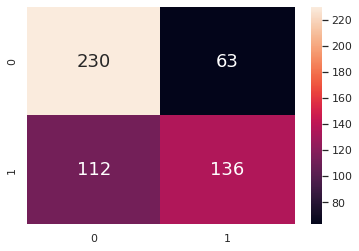

In [ ]:
cm2 = confusion_matrix(y_test_logr, y_pred_logr2)
sb.heatmap(cm2, annot = True, fmt=".0f", annot_kws={"size": 18})

Running multivariate log reg using K-folds

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

 
k = 7
kf = sklearn.model_selection.KFold(n_splits=k, random_state=None)
model = LogisticRegression(solver= 'liblinear')
 
result = cross_val_score(model , X_logr, y_logr.values.ravel(), cv = kf)
 
print("Avg accuracy without scaling: {}".format(result.mean()))


Avg accuracy without scaling: 0.626069193574745


## Multiclass Logistic Regression 

In [ ]:

imdb_bins = [0, 3, 5, 7, 10] 
imdb_labels = ["horrendous","bad", "good", "very good"]
imdb_clean_logr["score_cat"] = pd.cut(imdb_clean_logr["imdb_score"].copy(), \
                                     bins = imdb_bins, labels = imdb_labels)
imdb_clean_logr.head()
    

index  num_critic_for_reviews  director_facebook_likes  \
0   4757                    28.0                      0.0   
1    819                    84.0                     10.0   
2   4268                   126.0                    308.0   
3   3872                    29.0                    249.0   
4   3537                   112.0                      0.0   

   num_user_for_reviews  imdb_score  duration     budget imdb_goodbad  \
0                  10.0         6.5      91.0  5.789e+05          bad   
1                 171.0         5.7      87.0  1.278e+08          bad   
2                 545.0         6.8     100.0  1.957e+06         good   
3                  32.0         5.8     103.0  4.562e+06          bad   
4                  70.0         4.8      88.0  7.469e+06          bad   

  score_cat  
0      good  
1      good  
2      good  
3      good  
4       bad

In [ ]:
X_multi, y_multi = imdb_clean_logr[["num_critic_for_reviews", "director_facebook_likes", "num_user_for_reviews"]], imdb_clean_logr[["score_cat"]]

In [ ]:
# split the dataset into train and validation 
X_train_multi, X_test_multi, y_train_multi, y_test_multi = sklearn.model_selection.train_test_split(X_multi, y_multi, test_size = 0.2 )
# define the multinomial logistic regression model
logreg2 = LogisticRegression(multi_class = 'ovr', solver = 'lbfgs')
logreg2.fit(X_train_multi, y_train_multi)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(multi_class='ovr')

In [ ]:
y_predlr_multi = logreg2.predict(X_test_multi)

In [ ]:
accuracy_score(y_test_multi, y_predlr_multi)

0.6229205175600739

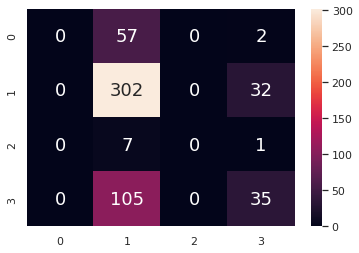

In [ ]:
cm_multi = confusion_matrix(y_test_multi, y_predlr_multi)
sb.heatmap(cm_multi, annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
k = 7
kf = sklearn.model_selection.KFold(n_splits=k, random_state=None)
model = LogisticRegression(solver= 'liblinear')
 
result = cross_val_score(model , X_multi, y_multi.values.ravel(), cv = kf)
 
print("Avg accuracy without scaling: {}".format(result.mean()))

Avg accuracy without scaling: 0.6616051601987946


## Decision tree

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()

imdb_copy1 = imdb.copy()

imdb_res = imdb_copy1[['imdb_score']]
imdb_res.fillna(imdb_res.median(), inplace = True)

imdb_test_clean_res = imdb_test_clean[['imdb_score']]
imdb_test_clean_res.fillna(imdb_test_clean_res.median(), inplace = True)

group_names = ["Bad","Good"] 

imdb_res['imdb_score'] = pd.cut(imdb_res['imdb_score'], bins = bins, labels = group_names)
imdb_test_clean_res['imdb_score'] = pd.cut(imdb_test_clean_res['imdb_score'], bins = bins, labels = group_names)

imdb_test_clean_res.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

imdb_score
Bad           316
Good          269
dtype: int64

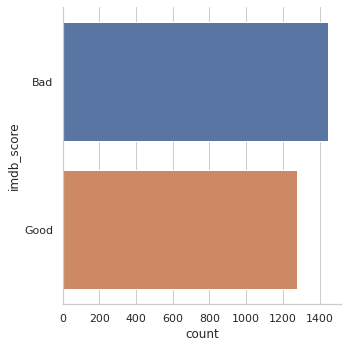

In [ ]:
sb.catplot(y = 'imdb_score', data = imdb_res, kind = "count")

In [ ]:
imdb_copy1.genres

4757                           Comedy
819     Action|Adventure|Thriller|War
4268                            Drama
3872                 Action|Adventure
3537    Comedy|Fantasy|Horror|Mystery
                    ...              
3618                    Drama|Romance
1183                           Comedy
350           Action|Adventure|Comedy
800     Drama|Fantasy|Mystery|Romance
549              Comedy|Drama|Romance
Name: genres, Length: 2728, dtype: object

In [ ]:
# get a list of unique genres to be appended as columns later 
unique_genres = genreFreq.Genre.unique()
print(unique_genres)

['Drama' 'Comedy' 'Thriller' 'Action' 'Romance' 'Adventure' 'Crime'
 'Sci-Fi' 'Fantasy' 'Family' 'Horror' 'Mystery' 'Animation' 'Biography'
 'Music' 'Sport' 'War' 'Musical' 'History' 'Documentary' 'Western'
 'Film-Noir' 'Short' 'News']


In [ ]:
imdb_copy1 = pd.concat([imdb_copy1,pd.DataFrame(columns=unique_genres.tolist())])

In [ ]:
import re 
# iterate through each row and search for the genre 

for ind, data in imdb_copy1.iterrows() :
  for genretype in unique_genres: 
    string = data["genres"]
    genretype_str = str(genretype)
    if bool(re.search(genretype_str, string)): #if movie has the particular genre
      imdb_copy1.at[ind,str(genretype)] = 1 #change the cell value to 1
    else :
      imdb_copy1.at[ind,str(genretype)] = 0 #change the cell value to 0
    

The data type now is object, need to convert to int

In [ ]:
imdb_copy1.iloc[:,28:] = imdb_copy1.iloc[:,28:].astype(int)

In [ ]:
imdb_copy1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 4757 to 549
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      2719 non-null   object 
 1   director_name              2728 non-null   object 
 2   num_critic_for_reviews     2702 non-null   float64
 3   duration                   2725 non-null   float64
 4   director_facebook_likes    2728 non-null   float64
 5   actor_3_facebook_likes     2719 non-null   float64
 6   actor_2_name               2723 non-null   object 
 7   actor_1_facebook_likes     2725 non-null   float64
 8   gross                      2393 non-null   float64
 9   genres                     2728 non-null   object 
 10  actor_1_name               2725 non-null   object 
 11  movie_title                2728 non-null   object 
 12  num_voted_users            2728 non-null   float64
 13  cast_total_facebook_likes  2728 non-null   flo

In [ ]:
# cleaning the num variables
imdb_num = imdb_copy1[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'num_voted_users', 'actor_3_facebook_likes',
                 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'cast_total_facebook_likes', 'num_user_for_reviews', 'budget',
                 'movie_facebook_likes', 'Drama', 'Comedy', 'Thriller', 'Crime', 'War', 'Animation', 'History', 'Music', 'Musical', 'Western',
                 'Sport', 'Documentary', 'History', 'Mystery', 'Family', 'Fantasy', 'Horror', 'Sci-Fi',
                 'Adventure', 'Biography', 'Romance', 'Action', 'Film-Noir', 'Short']]

imdb_test_clean_num = imdb_test_clean[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'num_voted_users', 'actor_3_facebook_likes',
                 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'cast_total_facebook_likes', 'num_user_for_reviews', 'budget',
                 'movie_facebook_likes', 'Drama', 'Comedy', 'Thriller', 'Crime', 'War', 'Animation', 'History', 'Music', 'Musical', 'Western',
                 'Sport', 'Documentary', 'History', 'Mystery', 'Family', 'Fantasy', 'Horror', 'Sci-Fi',
                 'Adventure', 'Biography', 'Romance', 'Action', 'Film-Noir', 'Short']]


# filling in null values with median
imdb_num.fillna(imdb_num.median(), inplace = True)
imdb_test_clean_num.fillna(imdb_test_clean_num.median(), inplace = True)


imdb_test_clean_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_critic_for_reviews     586 non-null    float64
 1   duration                   586 non-null    float64
 2   director_facebook_likes    586 non-null    float64
 3   num_voted_users            586 non-null    float64
 4   actor_3_facebook_likes     586 non-null    float64
 5   actor_1_facebook_likes     586 non-null    float64
 6   actor_2_facebook_likes     586 non-null    float64
 7   cast_total_facebook_likes  586 non-null    float64
 8   num_user_for_reviews       586 non-null    float64
 9   budget                     586 non-null    float64
 10  movie_facebook_likes       586 non-null    float64
 11  Drama                      586 non-null    int64  
 12  Comedy                     586 non-null    int64  
 13  Thriller                   586 non-null    int64  

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# OneHotEncoding of categorical predictors
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ohe = OneHotEncoder()

imdb_cat = imdb_copy1[['facenumber_in_poster','content_rating']]
imdb_test_clean_cat = imdb_test_clean[['facenumber_in_poster','content_rating']]

# removing null values
imdb_cat.dropna(inplace = True, axis = 0, how = "any")
imdb_test_clean_cat.dropna(inplace = True, axis = 0, how = "any")

ohe.fit(imdb_cat)
imdb_cat_ohe = pd.DataFrame(ohe.transform(imdb_cat).toarray(), 
                            columns=ohe.get_feature_names(imdb_cat.columns))

ohe.fit(imdb_test_clean_cat)
imdb_test_cat_ohe = pd.DataFrame(ohe.transform(imdb_test_clean_cat).toarray(),
                                 columns=ohe.get_feature_names(imdb_test_clean_cat.columns))

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


OneHotEncoder()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


OneHotEncoder()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
imdb_ohe = pd.concat([imdb_num, imdb_cat_ohe, imdb_res], 
                           sort = False, axis = 1).reindex(index=imdb_num.index)
imdb_test_ohe = pd.concat([imdb_test_clean_num, imdb_test_cat_ohe, imdb_test_clean_res], 
                           sort = False, axis = 1).reindex(index=imdb_test_clean_num.index)

# Check the final dataframe
imdb_ohe.dropna(inplace = True, axis = 0, how = "any")
imdb_test_ohe.dropna(inplace = True, axis = 0, how = "any")

In [ ]:
imdb_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1594 entries, 819 to 549
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   num_critic_for_reviews     1594 non-null   float64 
 1   duration                   1594 non-null   float64 
 2   director_facebook_likes    1594 non-null   float64 
 3   num_voted_users            1594 non-null   float64 
 4   actor_3_facebook_likes     1594 non-null   float64 
 5   actor_1_facebook_likes     1594 non-null   float64 
 6   actor_2_facebook_likes     1594 non-null   float64 
 7   cast_total_facebook_likes  1594 non-null   float64 
 8   num_user_for_reviews       1594 non-null   float64 
 9   budget                     1594 non-null   float64 
 10  movie_facebook_likes       1594 non-null   float64 
 11  Drama                      1594 non-null   float64 
 12  Comedy                     1594 non-null   float64 
 13  Thriller                   1594 

In [ ]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Dataset
y = pd.DataFrame(imdb_ohe['imdb_score'])                # Response
X = pd.DataFrame(imdb_ohe.drop('imdb_score', axis = 1)) # Predictors

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict y values corresponding to X
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(100,100))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["Bad","Good"])

# FPR AND FNR - TRAIN
CM_train = confusion_matrix(y_train, y_train_pred)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0] 
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]

# FPR AND FNR - TEST
CM_test = confusion_matrix(y_test, y_test_pred)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0] 
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]

# Check the Goodness of Fit (on Train Data)
print()
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print("True Positive Rate \t \t:", TP_train/(TP_train + FN_train))
print("True Negative Rate \t \t:", TN_test/(TN_test + FP_test))
print("False Positive Rate \t \t:", FP_train/(FP_train + TN_train))
print("False Negative Rate \t \t:", FN_train/(FN_train + TP_train))
print()

# Check the Goodness of Fit (on Validation Data)
print("Goodness of Fit of Model \tValidation Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print("True Positive Rate \t \t:", TP_test/(TP_test + FN_test))
print("True Negative Rate \t \t:", TN_test/(TN_test + FP_test))
print("False Positive Rate \t \t:", FP_test/(FP_test + TN_test))
print("False Negative Rate \t \t:", FN_test/(FN_test + TP_test))
print()

DecisionTreeClassifier(max_depth=4)

[Text(0.5, 0.9, 'num_voted_users <= 133070.0\ngini = 0.497\nsamples = 1275\nvalue = [690, 585]\nclass = Bad'),
 Text(0.25, 0.7, 'duration <= 116.5\ngini = 0.424\nsamples = 890\nvalue = [618, 272]\nclass = Bad'),
 Text(0.125, 0.5, 'Animation <= 0.5\ngini = 0.325\nsamples = 651\nvalue = [518, 133]\nclass = Bad'),
 Text(0.0625, 0.3, 'director_facebook_likes <= 491.5\ngini = 0.292\nsamples = 587\nvalue = [483, 104]\nclass = Bad'),
 Text(0.03125, 0.1, 'gini = 0.262\nsamples = 543\nvalue = [459, 84]\nclass = Bad'),
 Text(0.09375, 0.1, 'gini = 0.496\nsamples = 44\nvalue = [24, 20]\nclass = Bad'),
 Text(0.1875, 0.3, 'num_user_for_reviews <= 115.0\ngini = 0.496\nsamples = 64\nvalue = [35, 29]\nclass = Bad'),
 Text(0.15625, 0.1, 'gini = 0.137\nsamples = 27\nvalue = [25, 2]\nclass = Bad'),
 Text(0.21875, 0.1, 'gini = 0.394\nsamples = 37\nvalue = [10, 27]\nclass = Good'),
 Text(0.375, 0.5, 'Drama <= 0.5\ngini = 0.487\nsamples = 239\nvalue = [100, 139]\nclass = Good'),
 Text(0.3125, 0.3, 'movie_fac


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8094117647058824
True Positive Rate 	 	: 0.7555555555555555
True Negative Rate 	 	: 0.8160919540229885
False Positive Rate 	 	: 0.14492753623188406
False Negative Rate 	 	: 0.24444444444444444

Goodness of Fit of Model 	Validation Dataset
Classification Accuracy 	: 0.7617554858934169
True Positive Rate 	 	: 0.696551724137931
True Negative Rate 	 	: 0.8160919540229885
False Positive Rate 	 	: 0.1839080459770115
False Negative Rate 	 	: 0.30344827586206896



In [ ]:
# cross-validation

# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Extract Response and Predictors
y = pd.DataFrame(imdb_ohe['imdb_score'])
X = pd.DataFrame(imdb_ohe.drop('imdb_score', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Define the Hyper-parameter Grid to search on, in case of Decision Forest
param_grid = {# 'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(DecisionTreeClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.imdb_score.ravel())

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='accuracy')

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

DecisionTreeClassifier(max_depth=3)
0.7631372549019607


DecisionTreeClassifier(max_depth=5)


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8345098039215686
True Positive Rate 	 	: 0.7392055267702936
True Negative Rate 	 	: 0.8630952380952381
False Positive Rate 	 	: 0.08620689655172414
False Negative Rate 	 	: 0.2607944732297064

Goodness of Fit of Model 	Validation Dataset
Classification Accuracy 	: 0.8150470219435737
True Positive Rate 	 	: 0.7615894039735099
True Negative Rate 	 	: 0.8630952380952381
False Positive Rate 	 	: 0.13690476190476192
False Negative Rate 	 	: 0.23841059602649006



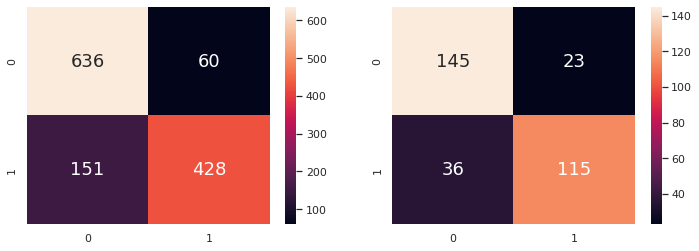

In [ ]:
# Dataset
y = pd.DataFrame(imdb_ohe['imdb_score'])                # Response
X = pd.DataFrame(imdb_ohe.drop('imdb_score', axis = 1)) # Predictors

# Split the CA - SP Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 5)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict CA values corresponding to SP
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# FPR AND FNR - TRAIN
CM_train = confusion_matrix(y_train, y_train_pred)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0] 
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]

# FPR AND FNR - TEST
CM_test = confusion_matrix(y_test, y_test_pred)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0] 
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]
print()
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print("True Positive Rate \t \t:", TP_train/(TP_train + FN_train))
print("True Negative Rate \t \t:", TN_test/(TN_test + FP_test))
print("False Positive Rate \t \t:", FP_train/(FP_train + TN_train))
print("False Negative Rate \t \t:", FN_train/(FN_train + TP_train))
print()

# Check the Goodness of Fit (on Validation Data)
print("Goodness of Fit of Model \tValidation Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print("True Positive Rate \t \t:", TP_test/(TP_test + FN_test))
print("True Negative Rate \t \t:", TN_test/(TN_test + FP_test))
print("False Positive Rate \t \t:", FP_test/(FP_test + TN_test))
print("False Negative Rate \t \t:", FN_test/(FN_test + TP_test))
print()

ACTUAL TEST

In [ ]:
# cross-validation

# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Extract Response and Predictors
y = pd.DataFrame(imdb_test_ohe['imdb_score'])
X = pd.DataFrame(imdb_test_ohe.drop('imdb_score', axis = 1))

# Define the Hyper-parameter Grid to search on, in case of Decision Forest
param_grid = {# 'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(DecisionTreeClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X, y.imdb_score.ravel())

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='accuracy')

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

DecisionTreeClassifier(max_depth=5)
0.7401709401709402


In [ ]:
# Dataset
y = pd.DataFrame(imdb_test_ohe['imdb_score'])                # Response
X = pd.DataFrame(imdb_test_ohe.drop('imdb_score', axis = 1)) # Predictors

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 6)  # create the decision tree object
dectree.fit(X, y)                    # train the decision tree model

# Predict CA values corresponding to SP
y_test_pred = dectree.predict(X)

# Plot the Confusion Matrix for  Test
sb.heatmap(confusion_matrix(y, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# FPR AND FNR - TEST
CM_test = confusion_matrix(y, y_test_pred)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0] 
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X, y))
print("True Positive Rate \t \t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t \t:", FP_test/(FP_test + TN_test))
print("False Negative Rate \t \t:", FN_test/(FN_test + TP_test))
print()

DecisionTreeClassifier(max_depth=6)

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8905982905982905
True Positive Rate 	 	: 0.8661710037174721
False Positive Rate 	 	: 0.08860759493670886
False Negative Rate 	 	: 0.13382899628252787



In [ ]:
# TRYING MULTI CLASS RESPONSE
imdb_bins = [0, 3, 5, 7, 10]
imdb_labels = ["horrendous", "ok", "good", "very good"]

imdb_copy3 = imdb_copy1.copy()

imdb_res3 = imdb_copy3[['imdb_score']]
imdb_res3.fillna(imdb_res.median(), inplace = True)

imdb_res3['imdb_score'] = pd.cut(imdb_res3['imdb_score'], bins = imdb_bins, labels = imdb_labels)

# cleaning the num variables
imdb_num3 = imdb_copy3[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'num_voted_users', 'actor_3_facebook_likes',
                 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'cast_total_facebook_likes', 'num_user_for_reviews', 'budget',
                 'movie_facebook_likes', 'Drama', 'Comedy', 'Thriller', 'Crime', 'War', 'Animation', 'History', 'Music', 'Musical', 'Western',
                 'Sport', 'Short', 'Documentary', 'History', 'Mystery', 'Family', 'Fantasy', 'Horror', 'Sci-Fi',
                 'Adventure', 'Biography', 'Romance', 'Action', 'Film-Noir']]
                 
# filling in null values with median
imdb_num3.fillna(imdb_num3.median(), inplace = True)

imdb_cat3 = imdb_copy3[['facenumber_in_poster','content_rating']]

# removing null values
imdb_cat3.dropna(inplace = True, axis = 0, how = "any")

ohe.fit(imdb_cat3)
imdb_cat3_ohe = pd.DataFrame(ohe.transform(imdb_cat3).toarray(), 
                            columns=ohe.get_feature_names(imdb_cat3.columns))

imdb_ohe3 = pd.concat([imdb_num3, imdb_cat3_ohe, imdb_res3], 
                      sort = False, axis = 1).reindex(index=imdb_num3.index)

imdb_ohe3.dropna(inplace = True, axis = 0, how = "any")

# imdb_ohe3.head() for checking

# Dataset
y = pd.DataFrame(imdb_ohe3['imdb_score'])                # Response
X = pd.DataFrame(imdb_ohe3.drop('imdb_score', axis = 1)) # Predictors

# Split the CA - SP Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 9)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict CA values corresponding to SP
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["horrendous", "ok", "good", "very good"])

# FPR AND FNR - TRAIN
CM_train = confusion_matrix(y_train, y_train_pred)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0] 
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]

# FPR AND FNR - TEST
CM_test = confusion_matrix(y_test, y_test_pred)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0] 
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print("True Positive Rate \t \t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t \t:", FP_train/(FP_train + TN_train))
print("False Negative Rate \t \t:", FN_train/(FN_train + TP_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print("True Positive Rate \t \t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t \t:", FP_test/(FP_test + TN_test))
print("False Negative Rate \t \t:", FN_test/(FN_test + TP_test))
print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self

OneHotEncoder()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


DecisionTreeClassifier(max_depth=9)

[Text(0.6864406779661016, 0.95, 'num_voted_users <= 186242.0\ngini = 0.502\nsamples = 1276\nvalue = [832, 11, 106, 327]\nclass = horrendous'),
 Text(0.4565677966101695, 0.85, 'duration <= 125.5\ngini = 0.427\nsamples = 1017\nvalue = [747, 11, 105, 154]\nclass = horrendous'),
 Text(0.2725988700564972, 0.75, 'duration <= 91.5\ngini = 0.394\nsamples = 856\nvalue = [652, 11, 103, 90]\nclass = horrendous'),
 Text(0.13135593220338984, 0.65, 'num_voted_users <= 52060.5\ngini = 0.574\nsamples = 155\nvalue = [89, 5, 45, 16]\nclass = horrendous'),
 Text(0.07062146892655367, 0.55, 'num_user_for_reviews <= 151.5\ngini = 0.57\nsamples = 100\nvalue = [50, 4, 42, 4]\nclass = horrendous'),
 Text(0.029661016949152543, 0.45, 'budget <= 20859624.0\ngini = 0.533\nsamples = 69\nvalue = [41, 3, 23, 2]\nclass = horrendous'),
 Text(0.011299435028248588, 0.35, 'Adventure <= 0.5\ngini = 0.278\nsamples = 6\nvalue = [0, 0, 5, 1]\nclass = good'),
 Text(0.005649717514124294, 0.25, 'gini = 0.0\nsamples = 5\nvalue = 

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9302507836990596
True Positive Rate 	 	: 0.3333333333333333
False Positive Rate 	 	: 0.0
False Negative Rate 	 	: 0.6666666666666666

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.709375
True Positive Rate 	 	: 0.0
False Positive Rate 	 	: 0.0
False Negative Rate 	 	: 1.0



In [ ]:
# multi class response cross validation

# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Extract Response and Predictors
y = pd.DataFrame(imdb_ohe3['imdb_score'])
X = pd.DataFrame(imdb_ohe3.drop('imdb_score', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Define the Hyper-parameter Grid to search on, in case of Decision Forest
param_grid = {# 'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(DecisionTreeClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.imdb_score.ravel())

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='accuracy')

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

DecisionTreeClassifier(max_depth=3)
0.7500030637254902


DecisionTreeClassifier(max_depth=3)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7468652037617555
True Positive Rate 	 	: 0.0
False Positive Rate 	 	: 0.0
False Negative Rate 	 	: 1.0

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7625
True Positive Rate 	 	: 0.0
False Positive Rate 	 	: 0.0
False Negative Rate 	 	: 1.0



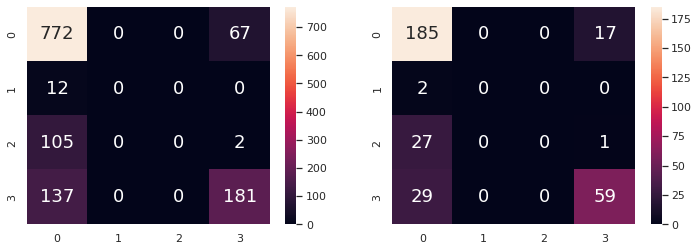

In [ ]:
# Dataset
y = pd.DataFrame(imdb_ohe3['imdb_score'])                # Response
X = pd.DataFrame(imdb_ohe3.drop('imdb_score', axis = 1)) # Predictors

# Split the CA - SP Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict CA values corresponding to SP
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# FPR AND FNR - TRAIN
CM_train = confusion_matrix(y_train, y_train_pred)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0] 
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]

# FPR AND FNR - TEST
CM_test = confusion_matrix(y_test, y_test_pred)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0] 
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print("True Positive Rate \t \t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t \t:", FP_train/(FP_train + TN_train))
print("False Negative Rate \t \t:", FN_train/(FN_train + TP_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print("True Positive Rate \t \t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t \t:", FP_test/(FP_test + TN_test))
print("False Negative Rate \t \t:", FN_test/(FN_test + TP_test))
print()

In [ ]:
# cross-validation

# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Extract Response and Predictors
y = pd.DataFrame(imdb_test_ohe['imdb_score'])
X = pd.DataFrame(imdb_test_ohe.drop('imdb_score', axis = 1))

# Define the Hyper-parameter Grid to search on, in case of Decision Forest
param_grid = {# 'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(DecisionTreeClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X, y.imdb_score.ravel())

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='accuracy')

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

DecisionTreeClassifier(max_depth=5)
0.7435897435897436


DecisionTreeClassifier(max_depth=6)

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8905982905982905
True Positive Rate 	 	: 0.8661710037174721
False Positive Rate 	 	: 0.08860759493670886
False Negative Rate 	 	: 0.13382899628252787



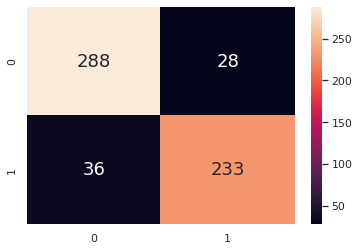

In [ ]:
# Dataset
y = pd.DataFrame(imdb_test_ohe['imdb_score'])                # Response
X = pd.DataFrame(imdb_test_ohe.drop('imdb_score', axis = 1)) # Predictors

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 6)  # create the decision tree object
dectree.fit(X, y)                    # train the decision tree model

# Predict CA values corresponding to SP
y_test_pred = dectree.predict(X)

# Plot the Confusion Matrix for  Test
sb.heatmap(confusion_matrix(y, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# FPR AND FNR - TEST
CM_test = confusion_matrix(y, y_test_pred)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0] 
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X, y))
print("True Positive Rate \t \t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t \t:", FP_test/(FP_test + TN_test))
print("False Negative Rate \t \t:", FN_test/(FN_test + TP_test))
print()

Observation: the accuracy is better using binary class response, I suspect this is because for the multi class response, the classes are heavily distorted. In my opinion, balancing the classes is not ideal as clearly majority of the movies lie within the 'good' and 'very good' range, so I believe it will be better to stick to binary class response for this dataset.

## Random forest

In [ ]:
# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Dataset
y = pd.DataFrame(imdb_ohe['imdb_score'])                # Response
X = pd.DataFrame(imdb_ohe.drop('imdb_score', axis = 1)) # Predictors


# Split the CA - SP Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(200,1001,200),   # number of trees 100, 200, ..., 500
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.imdb_score.ravel())
#12 mins 52 seconds to run

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 200,  400,  600,  800, 1000])},
             scoring='accuracy')

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=10, n_estimators=1000)
0.7937254901960784


In [ ]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(imdb_ohe['imdb_score'])
X = pd.DataFrame(imdb_ohe.drop('imdb_score', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 600,   # found using GridSearchCV
                                 max_depth = 10)       # found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.imdb_score.ravel())


RandomForestClassifier(max_depth=10, n_estimators=600)

Train Data
Accuracy  :	 0.9701960784313726

TPR Train :	 0.9337979094076655
TNR Train :	 1.0

FPR Train :	 0.0
FNR Train :	 0.06620209059233449


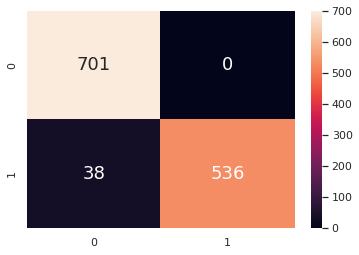

In [ ]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8087774294670846

TPR Test :	 0.7884615384615384
TNR Test :	 0.8282208588957055

FPR Test :	 0.17177914110429449
FNR Test :	 0.21153846153846154


In [ ]:
from sklearn.ensemble import RandomForestClassifier
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rforest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

importance
feature                              
num_voted_users                 0.183
duration                        0.099
num_user_for_reviews            0.092
num_critic_for_reviews          0.070
movie_facebook_likes            0.061
director_facebook_likes         0.057
budget                          0.049
cast_total_facebook_likes       0.044
actor_3_facebook_likes          0.041
actor_1_facebook_likes          0.039
actor_2_facebook_likes          0.038
Drama                           0.037
Biography                       0.015
Action                          0.014
Animation                       0.012

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

         Bad       0.95      1.00      0.97       701
        Good       1.00      0.93      0.97       574

    accuracy                           0.97      1275
   macro avg       0.97      0.97      0.97      1275
weighted avg       0.97      0.97      0.97      1275



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         Bad       0.80      0.83      0.82       163
        Good       0.81      0.79      0.80       156

    accuracy                           0.81       319
   macro avg       0.81      0.81      0.81       319
weighted avg       0.81      0.81      0.81       319



Interesting observation that the duration is the second most important feature in the random forest decision making.

Now let's test on the actual test set!

In [ ]:
# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Dataset
y = pd.DataFrame(imdb_test_ohe['imdb_score'])                # Response
X = pd.DataFrame(imdb_test_ohe.drop('imdb_score', axis = 1)) # Predictors

In [ ]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(200,1001,200),   # number of trees 100, 200, ..., 500
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X, y.imdb_score.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 200,  400,  600,  800, 1000])},
             scoring='accuracy')

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=9, n_estimators=1000)
0.7846153846153847


In [ ]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(imdb_test_ohe['imdb_score'])
X = pd.DataFrame(imdb_test_ohe.drop('imdb_score', axis = 1))

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 800,   # found using GridSearchCV
                                 max_depth = 10)       # found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X, y.imdb_score.ravel())


RandomForestClassifier(max_depth=10, n_estimators=800)

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X, y))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.9846153846153847

TPR Test :	 0.966542750929368
TNR Test :	 1.0

FPR Test :	 0.0
FNR Test :	 0.03345724907063197


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y, y_test_pred))

              precision    recall  f1-score   support

         Bad       0.97      1.00      0.99       316
        Good       1.00      0.97      0.98       269

    accuracy                           0.98       585
   macro avg       0.99      0.98      0.98       585
weighted avg       0.99      0.98      0.98       585



In [ ]:
from sklearn.ensemble import RandomForestClassifier
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(rforest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

importance
feature                              
num_voted_users                 0.148
duration                        0.092
num_user_for_reviews            0.087
num_critic_for_reviews          0.071
budget                          0.067
movie_facebook_likes            0.053
director_facebook_likes         0.051
actor_3_facebook_likes          0.049
cast_total_facebook_likes       0.047
actor_1_facebook_likes          0.043
actor_2_facebook_likes          0.042
Drama                           0.035
Comedy                          0.024
Action                          0.016
content_rating_PG-13            0.012

## K modes

In [ ]:
imdb_copy2 = imdb.copy()
imdb_catt = imdb_copy2[['director_name', 'actor_2_name', 'genres', 'actor_1_name', 'actor_3_name',
                 'plot_keywords', 'content_rating','title_year', 'imdb_score']].copy()
imdb_catt.head()

director_name       actor_2_name                         genres  \
4757             Sol Tryon           Ann Dowd                         Comedy   
819        Peter MacDonald     Kurtwood Smith  Action|Adventure|Thriller|War   
4268   Catherine Hardwicke       Sarah Clarke                          Drama   
3872       Ernie Barbarash  Michael J. Morris               Action|Adventure   
3537  Francis Ford Coppola         Bruce Dern  Comedy|Fantasy|Horror|Mystery   

            actor_1_name    actor_3_name  \
4757        Jim Gaffigan  Matthew Cowles   
819   Sylvester Stallone  Richard Crenna   
4268        Holly Hunter      Kip Pardue   
3872   Michael Jai White  Lateef Crowder   
3537    Alden Ehrenreich  Joanne Whalley   

                                          plot_keywords content_rating  \
4757                                artist|black comedy          PG-13   
819             afghanistan|colonel|rambo|rescue|soviet              R   
4268  13 year olds|adolescence|friend|peer pressure|...              R   
3872                                                NaN              R   
3537  ghost|hotel|murder|stake|what happened to epil...              R   

      title_year  imdb_score  
4757      2007.0         6.5  
819       1988.0         5.7  
4268      2003.0         6.8  
3872      2014.0         5.8  
3537      2011.0         4.8

In [ ]:
# cleaning null values
imdb_catt.fillna(imdb_catt.median(), inplace = True)
imdb_catt.dropna(inplace = True, axis = 0, how = "any")

imdb_catt.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


director_name     0
actor_2_name      0
genres            0
actor_1_name      0
actor_3_name      0
plot_keywords     0
content_rating    0
title_year        0
imdb_score        0
dtype: int64

In [ ]:
# converting imdb and title year into cat variable
imdb_catt['imdb_score'] = pd.cut(imdb_catt['imdb_score'], bins=[0, 3, 5, 7, 10], 
                                 labels=['0-3', '3-5', '5-7', '7-10'])

imdb_catt['title_year'] = pd.cut(imdb_catt['title_year'], bins=[1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020],
                                 labels=['1920-1930', '1930-1940', '1940-1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990',
                                         '1990-2000', '2000-2010', '2010-2020'])

imdb_catt.head()

director_name    actor_2_name                         genres  \
4757             Sol Tryon        Ann Dowd                         Comedy   
819        Peter MacDonald  Kurtwood Smith  Action|Adventure|Thriller|War   
4268   Catherine Hardwicke    Sarah Clarke                          Drama   
3537  Francis Ford Coppola      Bruce Dern  Comedy|Fantasy|Horror|Mystery   
3578          Dan O'Bannon     Clu Gulager           Comedy|Horror|Sci-Fi   

            actor_1_name      actor_3_name  \
4757        Jim Gaffigan    Matthew Cowles   
819   Sylvester Stallone    Richard Crenna   
4268        Holly Hunter        Kip Pardue   
3537    Alden Ehrenreich    Joanne Whalley   
3578      Linnea Quigley  Beverly Randolph   

                                          plot_keywords content_rating  \
4757                                artist|black comedy          PG-13   
819             afghanistan|colonel|rambo|rescue|soviet              R   
4268  13 year olds|adolescence|friend|peer pressure|...              R   
3537  ghost|hotel|murder|stake|what happened to epil...              R   
3578  crematorium|female frontal nudity|naked dead w...              R   

     title_year imdb_score  
4757  2000-2010        5-7  
819   1980-1990        5-7  
4268  2000-2010        5-7  
3537  2010-2020        3-5  
3578  1980-1990       7-10

In [ ]:
imdb_catt_copy = imdb_catt.copy()

In [ ]:
imdb_catt = imdb_catt.apply(le.fit_transform)
imdb_catt.head()

director_name  actor_2_name  genres  actor_1_name  actor_3_name  \
4757           1199            93     377           528          1269   
819            1030           954      91          1054          1575   
4268            177          1448     508           426          1100   
3537            393           226     450            19           917   
3578            252           332     457           699           174   

      plot_keywords  content_rating  title_year  imdb_score  
4757            624               7           8           2  
819             259               9           6           2  
4268              4               9           8           2  
3537           2350               9           9           1  
3578           1789               9           6           3

In [ ]:
!pip install --upgrade kmodes
from kmodes.kmodes import KModes

# using k modes with cao initialisation
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(imdb_catt)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37, cost: 18429.0


In [ ]:
# Predicted Clusters
fitClusters_cao

array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

In [ ]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = imdb_catt.columns

In [ ]:
# Mode of the clusters
clusterCentroidsDf

director_name  actor_2_name  genres  actor_1_name  actor_3_name  \
0            847           685     377           943           913   
1           1242          1198     465           951          1079   

   plot_keywords  content_rating  title_year  imdb_score  
0            298               9           8           2  
1              1               7           8           2

In [ ]:
# using k modes with huang initialisation
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(imdb_catt)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 46, cost: 18607.0
Run 1, iteration: 2/100, moves: 2, cost: 18607.0


In [ ]:
# Predicted clusters
fitClusters_huang

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [ ]:
# choosing k by comparing cost against each k
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(imdb_catt)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 19363.0


array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37, cost: 18429.0


array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 45, cost: 18036.0


array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 51, cost: 17623.0
Run 1, iteration: 2/100, moves: 6, cost: 17623.0


array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

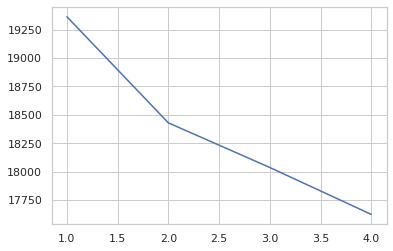

In [ ]:
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

In [ ]:
# choosing k as 2
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(imdb_catt)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37, cost: 18429.0


In [ ]:
fitClusters_cao

array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

In [ ]:
# combining predicted clusters with original dataframe
imdb_catt = imdb_catt_copy.reset_index()

clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([imdb_catt, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

combinedDf.head()

director_name    actor_2_name                         genres  \
0             Sol Tryon        Ann Dowd                         Comedy   
1       Peter MacDonald  Kurtwood Smith  Action|Adventure|Thriller|War   
2   Catherine Hardwicke    Sarah Clarke                          Drama   
3  Francis Ford Coppola      Bruce Dern  Comedy|Fantasy|Horror|Mystery   
4          Dan O'Bannon     Clu Gulager           Comedy|Horror|Sci-Fi   

         actor_1_name      actor_3_name  \
0        Jim Gaffigan    Matthew Cowles   
1  Sylvester Stallone    Richard Crenna   
2        Holly Hunter        Kip Pardue   
3    Alden Ehrenreich    Joanne Whalley   
4      Linnea Quigley  Beverly Randolph   

                                       plot_keywords content_rating  \
0                                artist|black comedy          PG-13   
1            afghanistan|colonel|rambo|rescue|soviet              R   
2  13 year olds|adolescence|friend|peer pressure|...              R   
3  ghost|hotel|murder|stake|what happened to epil...              R   
4  crematorium|female frontal nudity|naked dead w...              R   

  title_year imdb_score  cluster_predicted  
0  2000-2010        5-7                  0  
1  1980-1990        5-7                  0  
2  2000-2010        5-7                  0  
3  2010-2020        3-5                  0  
4  1980-1990       7-10                  0

In [ ]:
# cluster identification
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]
#cluster_2 = combinedDf[combinedDf['cluster_predicted'] == 2]

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f681074d450>)

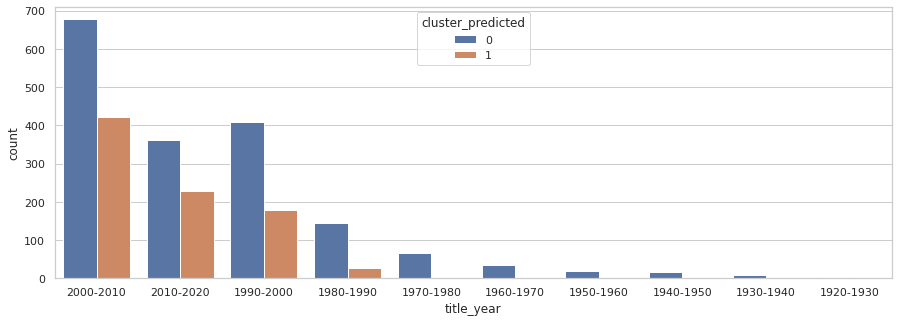

In [ ]:
# title_year
plt.subplots(figsize = (15, 5))
sb.countplot(x=combinedDf['title_year'],order=combinedDf['title_year'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f680f168450>)

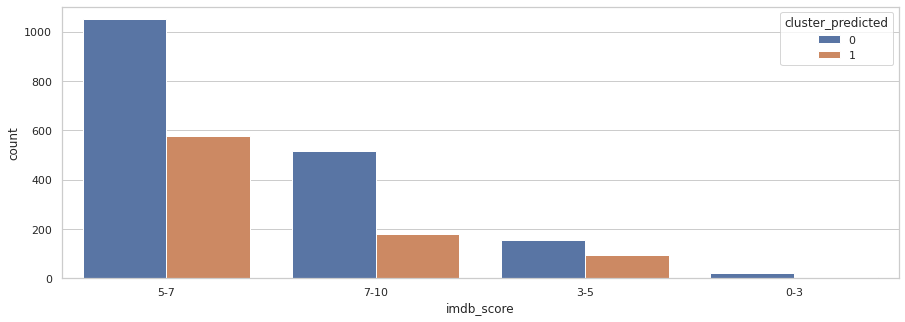

In [ ]:
# imdb_score
plt.subplots(figsize = (15, 5))
sb.countplot(x=combinedDf['imdb_score'],order=combinedDf['imdb_score'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

## K means

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 5)

imdb_copy4 = imdb.copy()

df1 = pd.DataFrame(imdb_copy4[["director_facebook_likes", "cast_total_facebook_likes"]])
df2 = pd.DataFrame(imdb_copy4[["director_facebook_likes", "movie_facebook_likes"]])
df3 = pd.DataFrame(imdb_copy4[["movie_facebook_likes", "cast_total_facebook_likes"]])

df1 = df1.fillna(df1.median())
df2 = df2.fillna(df2.median())
df3 = df3.fillna(df3.median())

# df1.isnull().sum() for checking

KMeans(n_clusters=5)

array([[4.36408221e+02, 2.72265259e+03],
       [1.84344776e+03, 4.48952289e+04],
       [2.85000000e+02, 6.56730000e+05],
       [1.55222359e+03, 1.85920384e+04],
       [2.38271429e+03, 1.08155667e+05]])

array([0, 3, 0, ..., 0, 3, 3], dtype=int32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


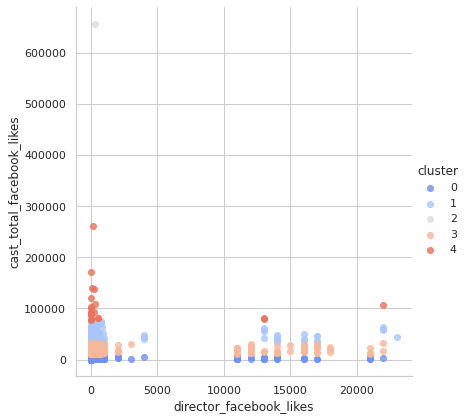

In [ ]:
# DF1
model.fit(df1)
model.cluster_centers_
model.labels_
df1['cluster'] = model.labels_

sb.set_style('whitegrid')
sb.lmplot('director_facebook_likes', 'cast_total_facebook_likes', data = df1, hue = 'cluster', palette = 'coolwarm', size = 6, aspect = 1, fit_reg = False)
plt.show()

In [ ]:
# DF2
model.fit(df2)
model.cluster_centers_
model.labels_
df2['cluster'] = model.labels_

sb.set_style('whitegrid')
sb.lmplot('director_facebook_likes', 'movie_facebook_likes', data = df2, hue = 'cluster', palette = 'coolwarm', size = 6, aspect = 1, fit_reg = False)
plt.show()

KMeans(n_clusters=5)

array([[   606.0313253 ,    389.55084337],
       [  2278.74509804,  51287.58169935],
       [  3217.57142857, 122428.57142857],
       [  1264.45905172,  18066.81034483],
       [ 22000.        , 349000.        ]])

array([0, 0, 0, ..., 0, 3, 0], dtype=int32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


KMeans(n_clusters=5)

array([[  2203.38389072,   5419.13424399],
       [  6620.10461538,  39615.28923077],
       [124150.        ,  34147.625     ],
       [ 41326.35983264,  16479.25104603],
       [     0.        , 656730.        ]])

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


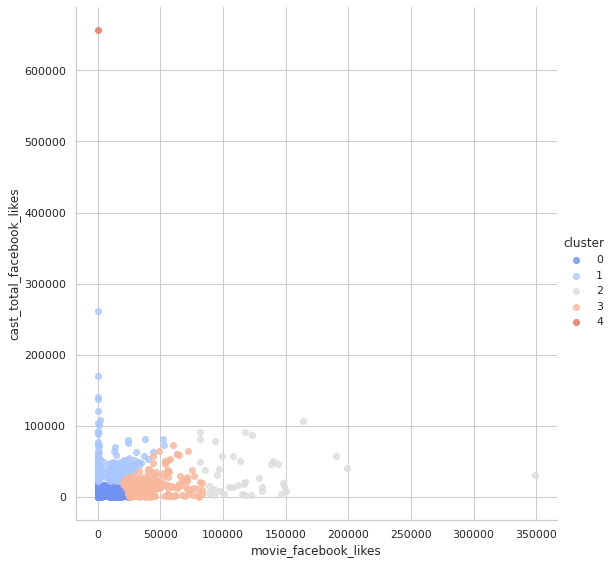

In [ ]:
# DF3
model.fit(df3)
model.cluster_centers_
model.labels_
df3['cluster'] = model.labels_

sb.set_style('whitegrid')
sb.lmplot('movie_facebook_likes', 'cast_total_facebook_likes', data = df3, hue = 'cluster', palette = 'coolwarm', size = 8, aspect = 1, fit_reg = False)
plt.show()

## Multi variate K means

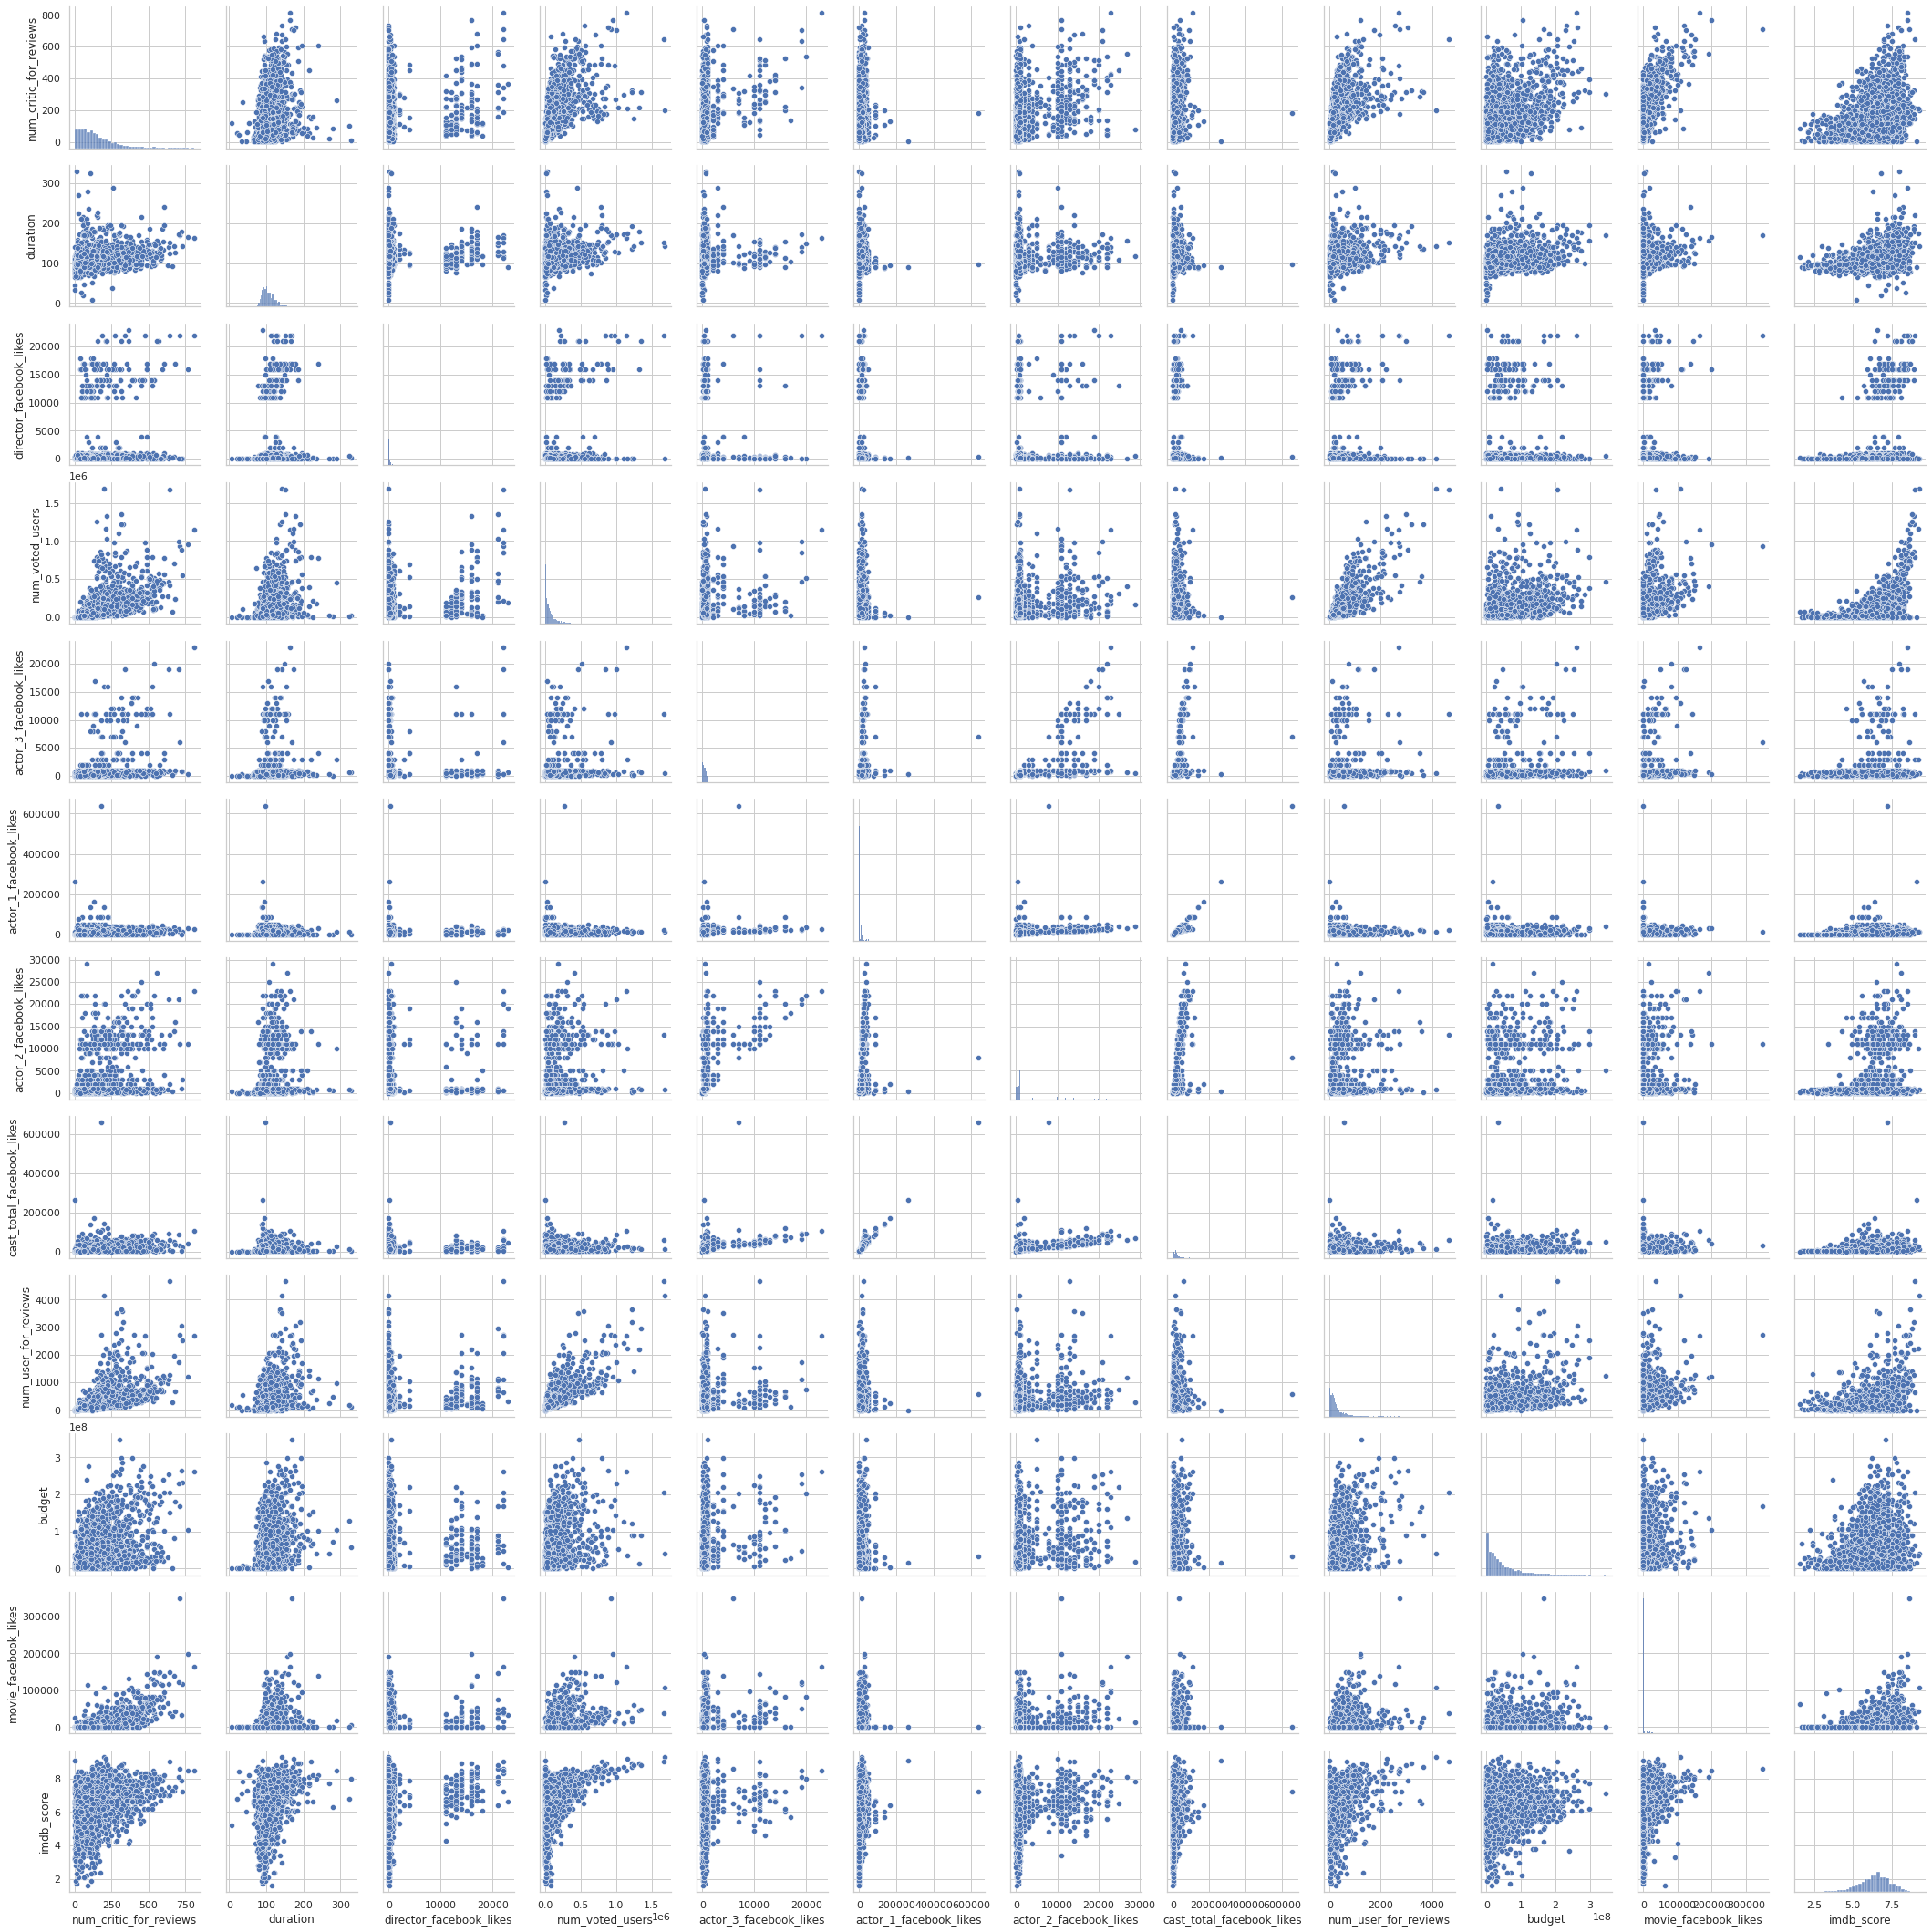

In [ ]:
imdb_numk = imdb_copy1[["num_critic_for_reviews", "duration", "director_facebook_likes", "num_voted_users",
                        "actor_3_facebook_likes", "actor_1_facebook_likes", "actor_2_facebook_likes", 
                        "cast_total_facebook_likes", "num_user_for_reviews", "budget",
                        "movie_facebook_likes", "imdb_score"]].copy()

# filling in null values with median
imdb_numk.fillna(imdb_numk.median(), inplace = True)

# remove remaining null
imdb_numk.dropna(inplace = True, axis = 0, how = "any")

# Plot the Raw Data on 2D grids
sb.pairplot(imdb_numk)

KMeans(n_clusters=1, n_init=5)

KMeans(n_clusters=2, n_init=5)

KMeans(n_clusters=3, n_init=5)

KMeans(n_clusters=4, n_init=5)

KMeans(n_clusters=5, n_init=5)

KMeans(n_clusters=6, n_init=5)

KMeans(n_clusters=7, n_init=5)

KMeans(n_init=5)

KMeans(n_clusters=9, n_init=5)

KMeans(n_clusters=10, n_init=5)

KMeans(n_clusters=11, n_init=5)

KMeans(n_clusters=12, n_init=5)

KMeans(n_clusters=13, n_init=5)

KMeans(n_clusters=14, n_init=5)

KMeans(n_clusters=15, n_init=5)

KMeans(n_clusters=16, n_init=5)

KMeans(n_clusters=17, n_init=5)

KMeans(n_clusters=18, n_init=5)

KMeans(n_clusters=19, n_init=5)

KMeans(n_clusters=20, n_init=5)

KMeans(n_clusters=21, n_init=5)

KMeans(n_clusters=22, n_init=5)

KMeans(n_clusters=23, n_init=5)

KMeans(n_clusters=24, n_init=5)

KMeans(n_clusters=25, n_init=5)

KMeans(n_clusters=26, n_init=5)

KMeans(n_clusters=27, n_init=5)

KMeans(n_clusters=28, n_init=5)

KMeans(n_clusters=29, n_init=5)

KMeans(n_clusters=30, n_init=5)

KMeans(n_clusters=31, n_init=5)

KMeans(n_clusters=32, n_init=5)

KMeans(n_clusters=33, n_init=5)

KMeans(n_clusters=34, n_init=5)

KMeans(n_clusters=35, n_init=5)

KMeans(n_clusters=36, n_init=5)

KMeans(n_clusters=37, n_init=5)

KMeans(n_clusters=38, n_init=5)

KMeans(n_clusters=39, n_init=5)

KMeans(n_clusters=40, n_init=5)

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Within Cluster Sum of Squares')

([<matplotlib.axis.XTick at 0x7f6808fa9c50>,
 <a list of 40 Text major ticklabel objects>)

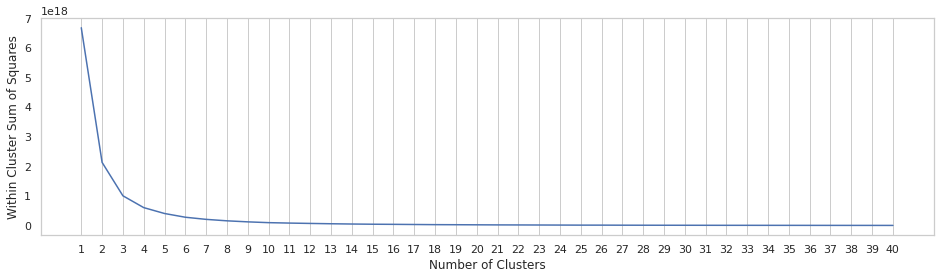

In [ ]:
# Vary the Number of Clusters
min_clust = 1
max_clust = 40
init_algo = 'k-means++'

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust, init = init_algo, n_init = 5)
    kmeans.fit(imdb_numk)
    within_ss.append(kmeans.inertia_)

# Angle Plot : Within SS vs Number of Clusters
f = plt.figure(figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

In [ ]:
# Import essential models from sklearn
from sklearn.cluster import KMeans

# Set "optimal" Clustering Parameters
num_clust = 3
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20)                 

# Fit the Clustering Model on the Data
kmeans.fit(imdb_numk)

KMeans(n_clusters=3, n_init=20)

Features 	critic_reviews 		duration 		director_likes 		voted_users 		actor3_likes 		actor2_likes 		actor1_likes 		cast_total_likes 		user_reviews 		budget 		movie_likes 		imdb_score

Cluster 0:	165.4	 	 	115.92	 	 	1296.3	 	 	133642.42	 	 	921.79	 	 	9263.42	 	 	2459.2	 	 	13770.91	 	 	369.66	 	 	75569828.91	 	 	8996.86	 	 	6.39	 	 	
Cluster 1:	120.99	 	 	102.63	 	 	605.03	 	 	60523.11	 	 	509.11	 	 	6218.9	 	 	1265.72	 	 	8794.04	 	 	210.72	 	 	17626728.89	 	 	5705.11	 	 	6.29	 	 	
Cluster 2:	289.22	 	 	126.23	 	 	1456.99	 	 	263128.32	 	 	1876.5	 	 	12964.56	 	 	4544.48	 	 	21492.09	 	 	776.4	 	 	172656384.53	 	 	22585.0	 	 	6.73	 	 	

Within Cluster Sum of Squares : 1.0047864732231314e+18



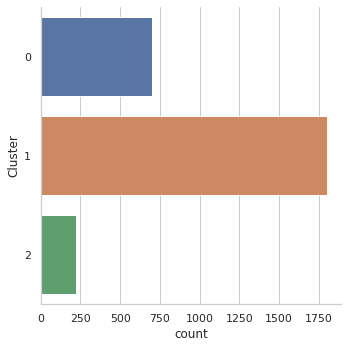

In [ ]:
# Print the Cluster Centers
print("Features", "\tcritic_reviews", "\t\tduration", "\t\tdirector_likes", "\t\tvoted_users",
      "\t\tactor3_likes", "\t\tactor2_likes", "\t\tactor1_likes", "\t\tcast_total_likes",
      "\t\tuser_reviews", "\t\tbudget", "\t\tmovie_likes", "\t\timdb_score")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t \t \t")
    print()
print()

# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)
print()

# Predict the Cluster Labels
labels = kmeans.predict(imdb_numk)

# Append Labels to the Data
imdb_numk_labeled = imdb_numk.copy()
imdb_numk_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.catplot(y = "Cluster", data = imdb_numk_labeled, kind = "count")

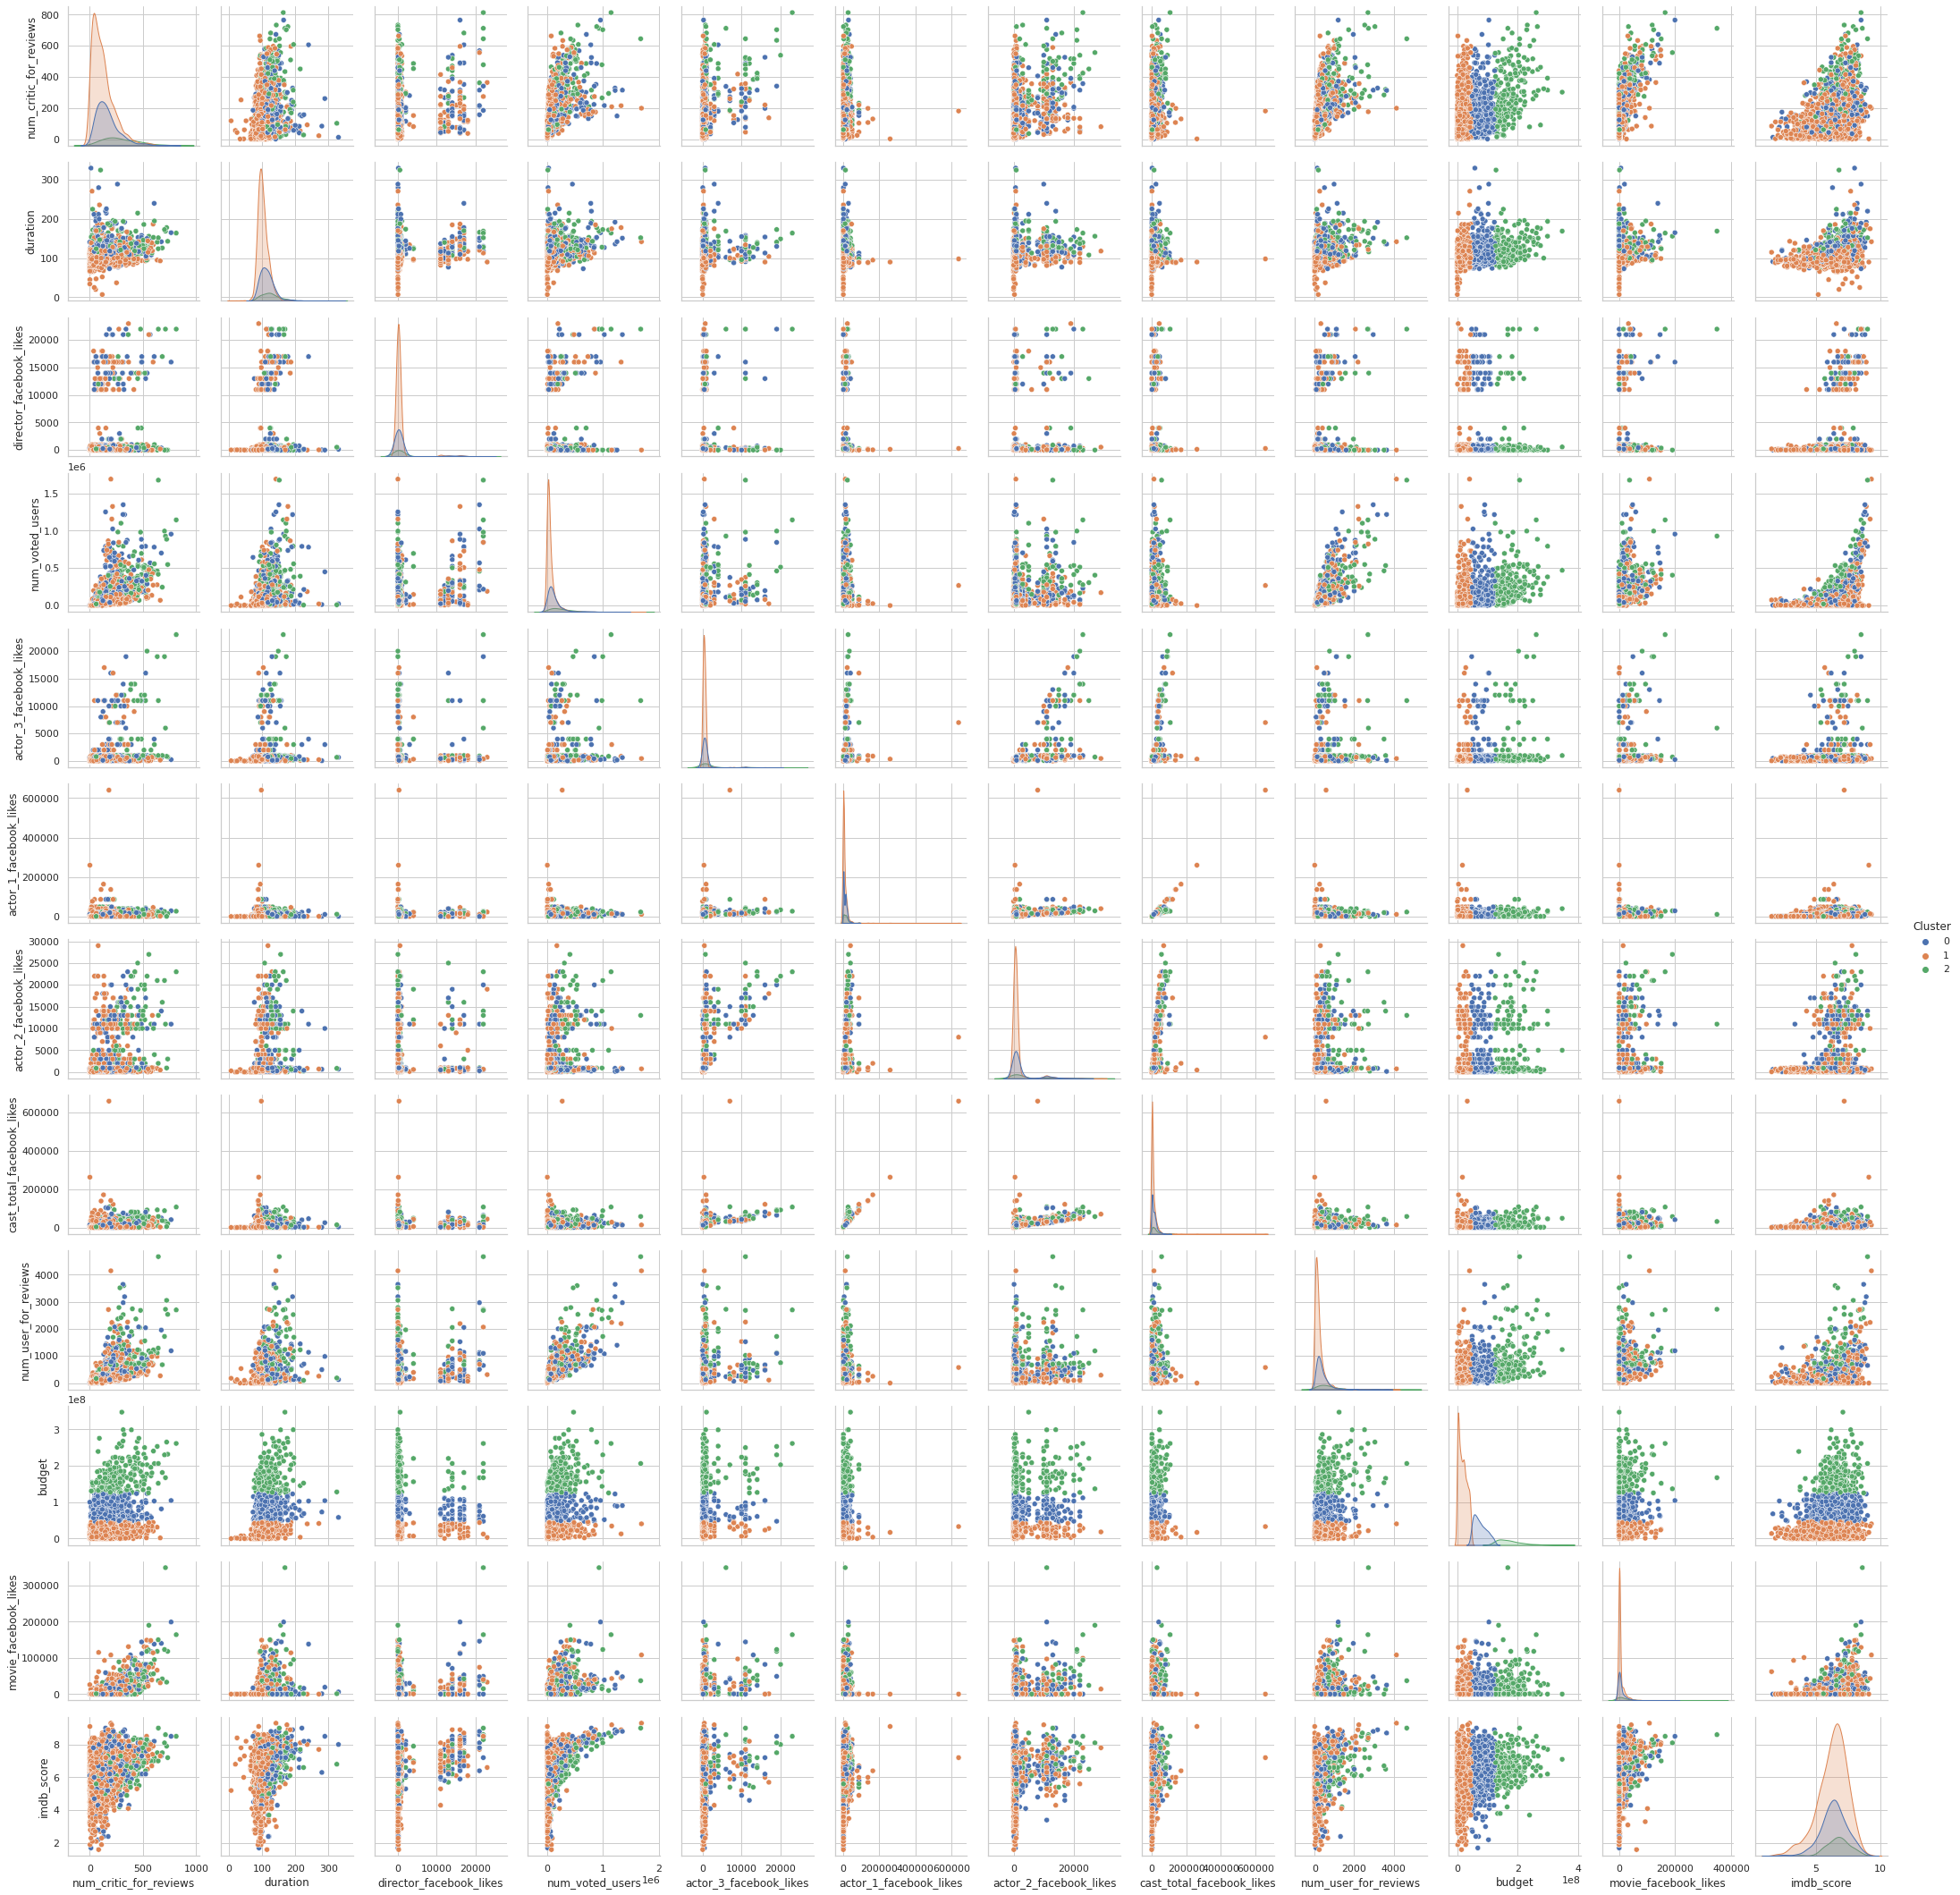

In [ ]:
# Plot the Clusters on 2D grids
sb.pairplot(imdb_numk_labeled, vars = imdb_numk.columns.values, hue = "Cluster")

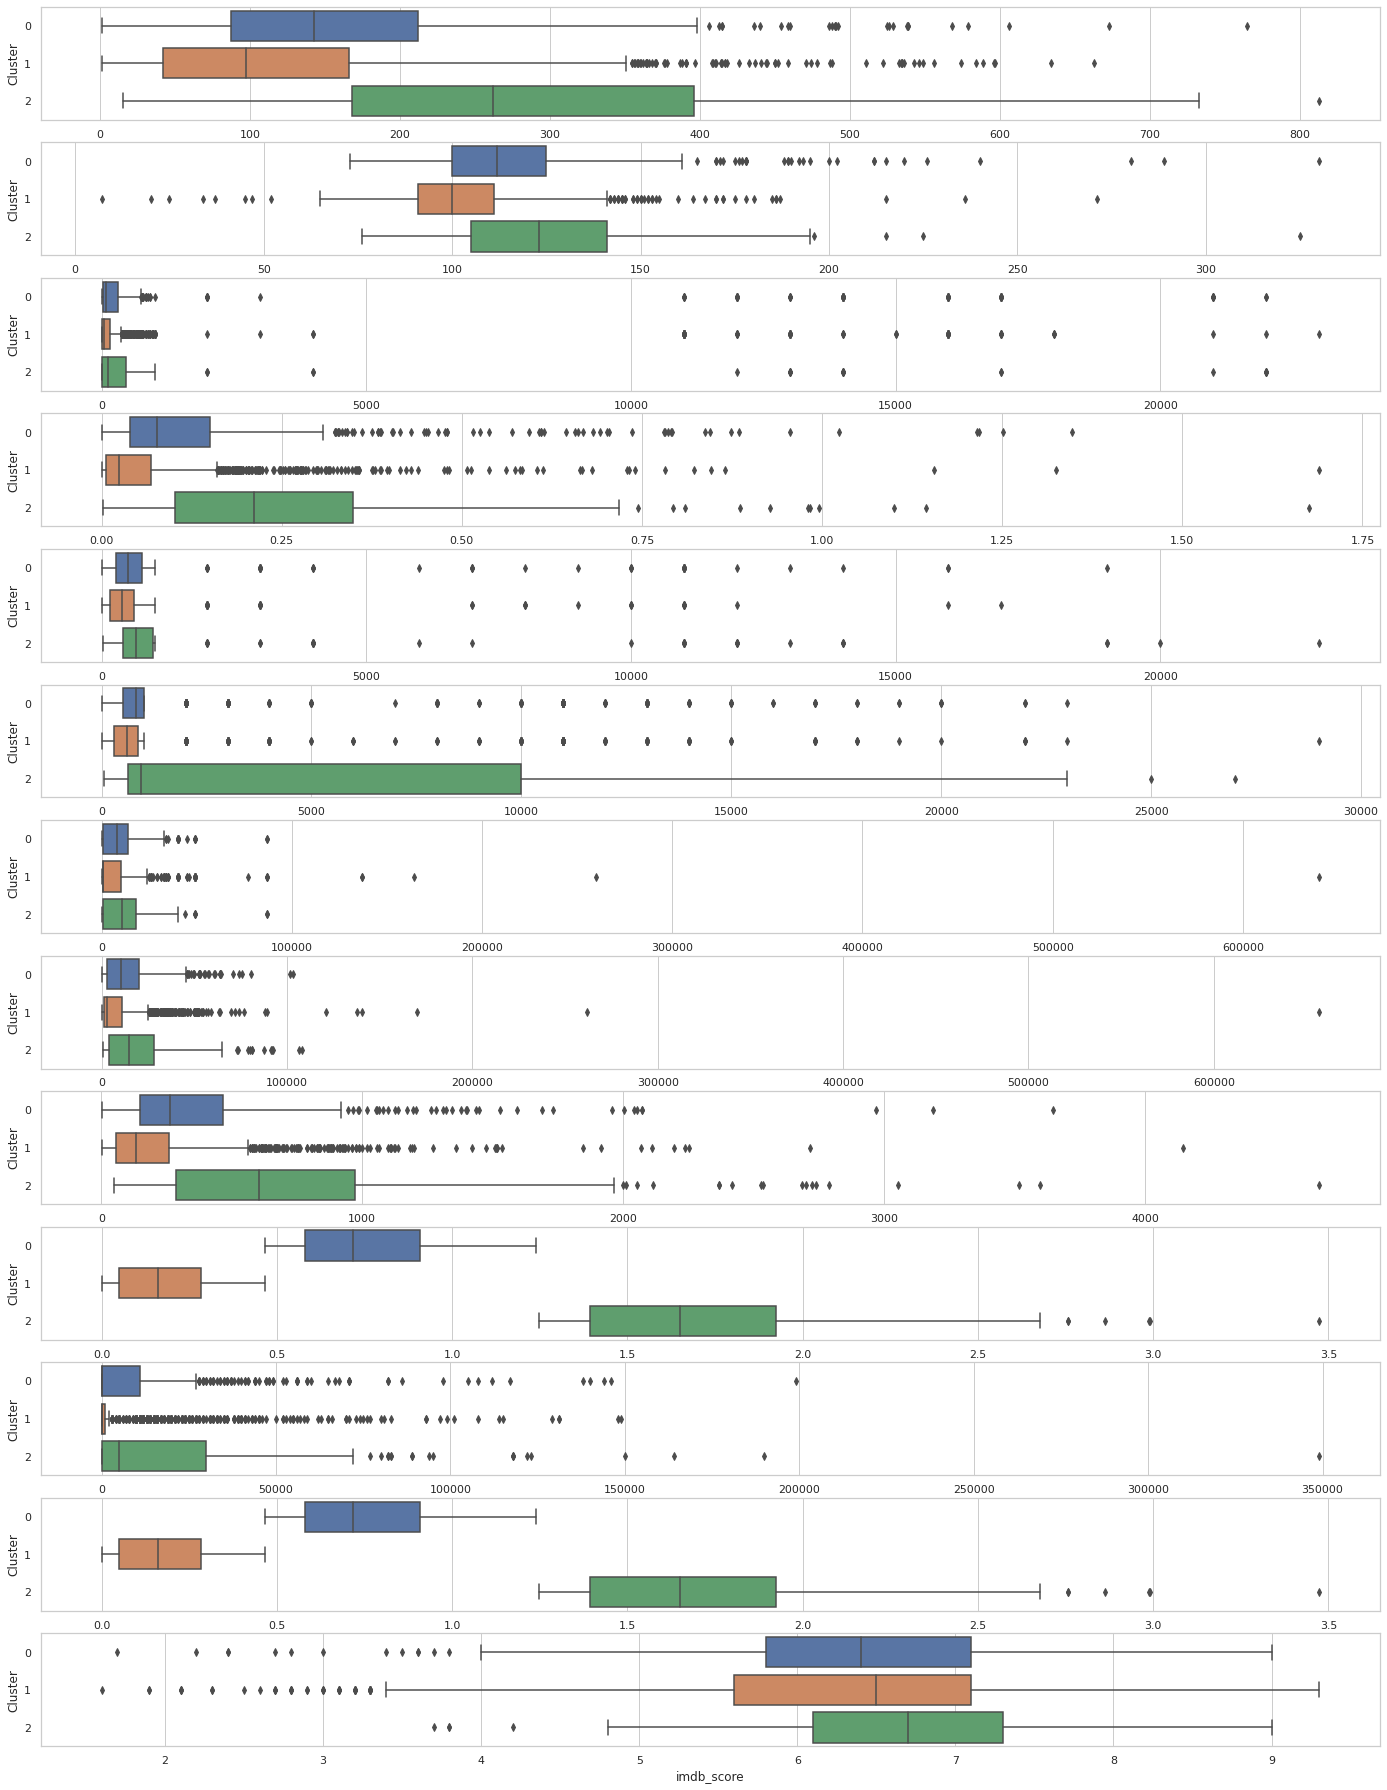

In [ ]:
# Boxplots for all Features against the Clusters
f, axes = plt.subplots(13, 1, figsize=(24,32))
sb.boxplot(x = 'num_critic_for_reviews', y = 'Cluster', data = imdb_numk_labeled, ax = axes[0])
sb.boxplot(x = 'duration', y = 'Cluster', data = imdb_numk_labeled, ax = axes[1])
sb.boxplot(x = 'director_facebook_likes', y = 'Cluster', data = imdb_numk_labeled, ax = axes[2])
sb.boxplot(x = 'num_voted_users', y = 'Cluster', data = imdb_numk_labeled, ax = axes[3])
sb.boxplot(x = 'actor_3_facebook_likes', y = 'Cluster', data = imdb_numk_labeled, ax = axes[4])
sb.boxplot(x = 'actor_2_facebook_likes', y = 'Cluster', data = imdb_numk_labeled, ax = axes[5])
sb.boxplot(x = 'actor_1_facebook_likes', y = 'Cluster', data = imdb_numk_labeled, ax = axes[6])
sb.boxplot(x = 'cast_total_facebook_likes', y = 'Cluster', data = imdb_numk_labeled, ax = axes[7])
sb.boxplot(x = 'num_user_for_reviews', y = 'Cluster', data = imdb_numk_labeled, ax = axes[8])
sb.boxplot(x = 'budget', y = 'Cluster', data = imdb_numk_labeled, ax = axes[9])
sb.boxplot(x = 'movie_facebook_likes', y = 'Cluster', data = imdb_numk_labeled, ax = axes[10])
sb.boxplot(x = 'budget', y = 'Cluster', data = imdb_numk_labeled, ax = axes[11])
sb.boxplot(x = 'imdb_score', y = 'Cluster', data = imdb_numk_labeled, ax = axes[12])

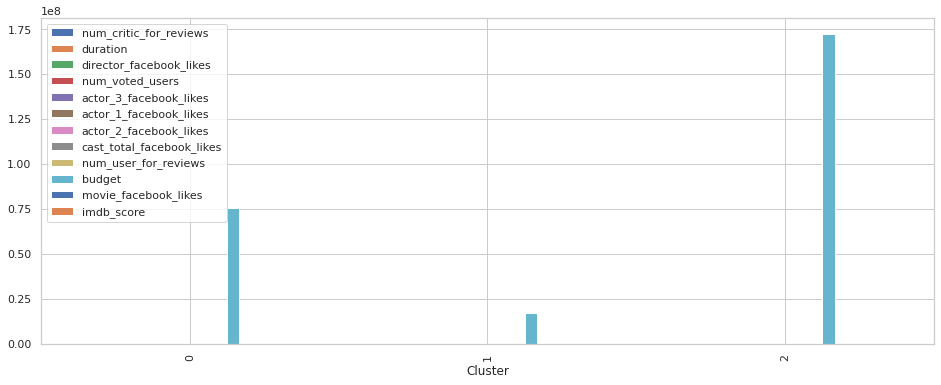

In [ ]:
# Average Behaviour of each Cluster
cluster_data = pd.DataFrame(imdb_numk_labeled.groupby(by = "Cluster").mean())
cluster_data.plot.bar(figsize = (16,6))